In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
from scipy.spatial import Delaunay
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import defaultdict
from Geometry3D import *
import copy
import ast
import random
import itertools
import statistics
from scipy.stats import truncnorm
from scipy.stats import bernoulli
from IPython.display import Image
import math
import shapely
from shapely.geometry import Point as pointpoint
from shapely.geometry.polygon import Polygon as polygonpolygon
from shapely.geometry import MultiPolygon
from itertools import permutations
import shapely.geometry as sg
import pandas as pd
import time
import json
epsilon = 10e-5
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sect.triangulation import Triangulation
from ground.base import get_context
#https://github.com/lycantropos/sect

In [2]:
with open('efficientset.json', 'r') as file:
    data = json.load(file)

# Преобразование данных в список списков
efficient_set = [[item[0], item[1]] for item in data]
efficient_set

[[4.040404040404041, 0.0],
 [4.141414141414141, 0.0],
 [4.242424242424242, 0.0],
 [4.343434343434343, 0.0],
 [4.444444444444445, 0.0],
 [4.545454545454545, 0.0],
 [4.646464646464646, 0.0],
 [4.747474747474747, 0.0],
 [4.848484848484849, 0.0],
 [4.94949494949495, 0.0],
 [5.05050505050505, 0.0],
 [5.151515151515151, 0.0],
 [5.252525252525253, 0.0],
 [5.353535353535354, 0.0],
 [5.454545454545454, 0.0],
 [5.555555555555555, 0.0],
 [5.656565656565657, 0.0],
 [5.757575757575758, 0.0],
 [5.858585858585858, 0.0],
 [5.959595959595959, 0.0],
 [4.040404040404041, 0.10101010101010101],
 [4.141414141414141, 0.10101010101010101],
 [4.242424242424242, 0.10101010101010101],
 [4.343434343434343, 0.10101010101010101],
 [4.444444444444445, 0.10101010101010101],
 [4.545454545454545, 0.10101010101010101],
 [4.646464646464646, 0.10101010101010101],
 [4.747474747474747, 0.10101010101010101],
 [4.848484848484849, 0.10101010101010101],
 [4.94949494949495, 0.10101010101010101],
 [5.05050505050505, 0.10101010101

In [3]:
#box 10x10

P_0 = [[9, 10], [8, 7], [5, 6], [3, 0], [0, 1], [5, 1], [2, 3], [0, 4], [7, 9], [3, 2], [8, 5], [10, 2], [7, 7], [7, 2], [8, 6], [9, 1], [9, 9], [1, 6], [2, 5], [2, 4], [0, 3], [4, 1], [5, 4], [6, 2], [7, 1], [10, 10], [8, 0], [2, 10], [10, 0], [1, 10], [2, 8], [9, 4], [1, 3], [6, 5], [8, 3], [10, 4], [3, 3], [3, 1], [6, 4], [5, 9], [1, 2], [3, 6], [6, 7], [1, 4], [9, 2], [6, 0], [8, 9], [1, 1], [4, 6], [5, 10]]

print(len(P_0))

50


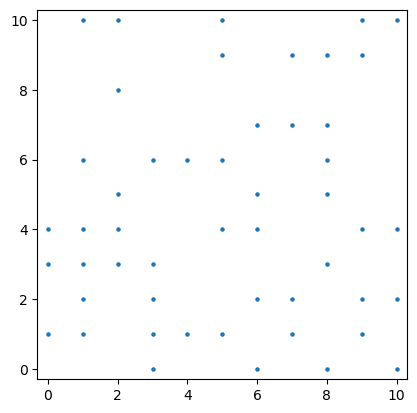

In [4]:
def vis_plot(P_0):
    x = [p[0] for p in P_0]
    y = [p[1] for p in P_0]
    plt.scatter(x=x, y=y, s = 5)
    plt.axis('scaled')
#     plt.grid()
    plt.xlim(-0.3, 10.3)
    plt.ylim(-0.3, 10.3)

    
vis_plot(P_0)

In [5]:
def my_distance(a, b):
    if (len(a)==2) and (len(b)==2):
        return np.sqrt((a[1]-b[1])**2 + (a[0]-b[0])**2)
    else:
        print(a, b)

my_distance(P_0[5], P_0[9])

2.23606797749979

In [6]:
def my_euclidean_distance(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    return np.linalg.norm(p1 - p2)

def my_hausdorff_distance(A, B):
    A = np.array(A)
    B = np.array(B)
   
    # Calculate the bidirectional Hausdorff distance
    def my_directed_hausdorff(A, B):
        return np.max([np.min([my_euclidean_distance(a, b) for b in B]) for a in A])
    
    # Calculate the bidirectional Hausdorff distance
    d_AB = my_directed_hausdorff(A, B)
    d_BA = my_directed_hausdorff(B, A)
    
    return max(d_AB, d_BA)



In [7]:
def matrix_of_distances(P):
    M = np.zeros((len(P), len(P)))
    for i in range(len(P)):
        for j in range(len(P)):
            if (i<j):
                M[i][j] = my_distance(P[i], P[j])
                M[j][i] = M[i][j]
    return M

matrix_of_distances(P_0)

array([[ 0.        ,  3.16227766,  5.65685425, ..., 12.04159458,
         6.40312424,  4.        ],
       [ 3.16227766,  0.        ,  3.16227766, ...,  9.21954446,
         4.12310563,  4.24264069],
       [ 5.65685425,  3.16227766,  0.        , ...,  6.40312424,
         1.        ,  4.        ],
       ...,
       [12.04159458,  9.21954446,  6.40312424, ...,  0.        ,
         5.83095189,  9.8488578 ],
       [ 6.40312424,  4.12310563,  1.        , ...,  5.83095189,
         0.        ,  4.12310563],
       [ 4.        ,  4.24264069,  4.        , ...,  9.8488578 ,
         4.12310563,  0.        ]])

# Objectives

In [8]:
def obj1(a):
    return - (a[0]-5)**2/1000

In [9]:
def obj2(a):
    return -(((a[0]-5)**2 + (a[1]-5) - 11)**2 + ((a[0]-5) + (a[1]-5)**2 - 7)**2)/1000

# Mutation operator

In [10]:
def mutation(a, mutation_rate):
    angle = random.random()
    return [a[0] + np.cos(angle * 2 * math.pi)*mutation_rate*random.random(), a[1] + np.sin(angle * 2 * math.pi) * mutation_rate*random.random()]

# Useful functions for optimization

In [11]:
#Sort by values

def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_of(min(values),values) in list1:
            sorted_list.append(index_of(min(values),values))
        values[index_of(min(values),values)] = math.inf
    return sorted_list

In [12]:
#Function to find index of list

def index_of(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1

In [13]:
#Sort solutions to Pareto front 

def fast_non_dominated_sort(values1, values2):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
#             print(values2[q], values2[p])
            if ((values1[p] > values1[q]) and (values2[p] > values2[q])) or ((values1[p] >= values1[q]) and (values2[p] > values2[q])) or ((values1[p] > values1[q]) and (values2[p] >= values2[q])):
                if q not in S[p]:
                    S[p].append(q)
            elif ((values1[q] > values1[p]) and (values2[q] > values2[p])) or ((values1[q] >= values1[p]) and (values2[q] > values2[p])) or ((values1[q] > values1[p]) and (values2[q] >= values2[p])):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front

In [14]:
#Sort solutions to Pareto front with epsilon-dominance parameter НЕ СДЕЛАЛА!!!!валотжыоваи

def fast_non_dominated_sort_eps(values1, values2, eps):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
#             print(values2[q], values2[p])
            if ((values1[p]*(1 + eps) > values1[q]) and (values2[p]*(1 + eps) > values2[q])) or ((values1[p]*(1 + eps) >= values1[q]) and (values2[p]*(1 + eps) > values2[q])) or ((values1[p]*(1 + eps) > values1[q]) and (values2[p]*(1 + eps) >= values2[q])):
                if q not in S[p]:
                    S[p].append(q)
            elif ((values1[q]*(1 + eps) > values1[p]) and (values2[q]*(1 + eps) > values2[p])) or ((values1[q]*(1 + eps) >= values1[p]) and (values2[q]*(1 + eps) > values2[p])) or ((values1[q]*(1 + eps) > values1[p]) and (values2[q]*(1 + eps) >= values2[p])):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front

In [15]:
#Function to calculate crowding distance

def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 4444444444444444
    distance[len(front) - 1] = 4444444444444444
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
    return distance

In [16]:
#Function to calculate hypervolumes

def hypervolumes(values1, values2, front):
    r = [0, 0]
    volumes = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    for k in range(0,len(front)):
        volumes[k] = (values1[sorted1[k]] - r[0]) * (values2[sorted1[k]] - r[1])
    return volumes

In [17]:
#Class for working with json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [18]:
#Vizualization of pareto fronts in population

def pareto_fronts(objjs, it, max_gen):
    with open(objjs, 'r') as f:
        data = f.readlines()
    dt = data[0]
    dt = dt[1:]
    df = []
    
    a = defaultdict()
    for k in range(it):
        n=0
        a[k] = ''
        for i in range(len(dt)):
            if (dt[i] == '}'):
                dt = dt[(n+3):]
                break
            else:
                a[k] = a[k] + dt[i]
            n += 1
        
        a[k] = a[k] + '}'
    for k in range(it):
        df.append(pd.DataFrame.from_dict(json.loads(a[k])))
            
    for k in range(it):
        df[k].columns = df[k].columns.astype(int)
        
    fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(17, 17))
    plt.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle("Pareto fronts", fontsize=15, y=0.95)
    for q in range(it):
        ax = plt.subplot(6, 5, q + 1)
        function1 = [i*(-1) for i in non_dominated([x for y in [df[q][t][0] for t in range(1, max_gen)] for x in y], [x for y in [df[q][t][1] for t in range(1, max_gen)] for x in y])[0]]
        function2 = [j*(-1) for j in non_dominated([x for y in [df[q][t][0] for t in range(1, max_gen)] for x in y], [x for y in [df[q][t][1] for t in range(1, max_gen)] for x in y])[1]]
        plt.xlabel('Objective 1', fontsize=7)
        plt.ylabel('Objective 2', fontsize=7)
        plt.tick_params(axis='both', which='major', labelsize=5)
        plt.tick_params(axis='both', which='minor', labelsize=5)
        plt.scatter(function1, function2, s = 1)
    plt.show()

In [19]:
#Vizualization of pareto fronts in population

def pareto_fronts_eps(objjs, it, max_gen, eps):
    with open(objjs, 'r') as f:
        data = f.readlines()
    dt = data[0]
    dt = dt[1:]
    df = []
    
    a = defaultdict()
    for k in range(it):
        n=0
        a[k] = ''
        for i in range(len(dt)):
            if (dt[i] == '}'):
                dt = dt[(n+3):]
                break
            else:
                a[k] = a[k] + dt[i]
            n += 1
        
        a[k] = a[k] + '}'
    for k in range(it):
        df.append(pd.DataFrame.from_dict(json.loads(a[k])))
            
    for k in range(it):
        df[k].columns = df[k].columns.astype(int)
        
    fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(17, 17))
    plt.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle("Pareto fronts", fontsize=15, y=0.95)
    for q in range(it):
        ax = plt.subplot(6, 5, q + 1)
        function1 = [i*(-1) for i in non_dominated_eps([x for y in [df[q][t][0] for t in range(1, max_gen)] for x in y], [x for y in [df[q][t][1] for t in range(1, max_gen)] for x in y], eps)[0]]
        function2 = [j*(-1) for j in non_dominated_eps([x for y in [df[q][t][0] for t in range(1, max_gen)] for x in y], [x for y in [df[q][t][1] for t in range(1, max_gen)] for x in y], eps)[1]]
        plt.xlabel('Objective 1', fontsize=7)
        plt.ylabel('Objective 2', fontsize=7)
        plt.tick_params(axis='both', which='major', labelsize=5)
        plt.tick_params(axis='both', which='minor', labelsize=5)
        plt.scatter(function1, function2, s = 1)
    plt.show()

In [20]:
#Total pareto fronts for all solutions among different iterations and generations

def one_pareto_front(js, it, max_gen):
    with open(js, 'r') as f:
        data = f.readlines()
    dt = data[0]
    dt = dt[1:]
    df = []
    
    a = defaultdict()
    for k in range(it):
        n=0
        a[k] = ''
        for i in range(len(dt)):
            if (dt[i] == '}'):
                dt = dt[(n+3):]
                break
            else:
                a[k] = a[k] + dt[i]
            n += 1
        
        a[k] = a[k] + '}'
    for k in range(it):
        df.append(pd.DataFrame.from_dict(json.loads(a[k])))
            
    for k in range(it):
        df[k].columns = df[k].columns.astype(int)
        
        
    X = []
    Y = []
    for q in range(it):
        X.append([i*(-1) for i in non_dominated([x for y in [df[q][t][0] for t in range(1, max_gen)] for x in y], [x for y in [df[q][t][1] for t in range(1, max_gen)] for x in y])[0]])
        Y.append([j*(-1) for j in non_dominated([x for y in [df[q][t][0] for t in range(1, max_gen)] for x in y], [x for y in [df[q][t][1] for t in range(1, max_gen)] for x in y])[1]])
    X = [x for y in X for x in y]
    Y = [x for y in Y for x in y]
    function1 = non_dominated(X, Y)[0]   
    function2 = non_dominated(X, Y)[1]
    plt.xlabel('Objective 1', fontsize=7)
    plt.ylabel('Objective 2', fontsize=7)
    plt.tick_params(axis='both', which='major', labelsize=5)
    plt.tick_params(axis='both', which='minor', labelsize=5)
    plt.scatter(function1, function2, s = 1)
    plt.show()
    return non_dominated(X, Y)

In [21]:
#Total pareto fronts for all solutions among different iterations and generations

def one_pareto_front_eps(js, it, max_gen, eps):
    with open(js, 'r') as f:
        data = f.readlines()
    dt = data[0]
    dt = dt[1:]
    df = []
    
    a = defaultdict()
    for k in range(it):
        n=0
        a[k] = ''
        for i in range(len(dt)):
            if (dt[i] == '}'):
                dt = dt[(n+3):]
                break
            else:
                a[k] = a[k] + dt[i]
            n += 1
        
        a[k] = a[k] + '}'
    for k in range(it):
        df.append(pd.DataFrame.from_dict(json.loads(a[k])))
            
    for k in range(it):
        df[k].columns = df[k].columns.astype(int)
        
        
    X = []
    Y = []
    for q in range(it):
        X.append([i*(-1) for i in non_dominated_eps([x for y in [df[q][t][0] for t in range(1, max_gen)] for x in y], [x for y in [df[q][t][1] for t in range(1, max_gen)] for x in y], eps)[0]])
        Y.append([j*(-1) for j in non_dominated_eps([x for y in [df[q][t][0] for t in range(1, max_gen)] for x in y], [x for y in [df[q][t][1] for t in range(1, max_gen)] for x in y], eps)[1]])
    X = [x for y in X for x in y]
    Y = [x for y in Y for x in y]
    function1 = non_dominated_eps(X, Y, eps)[0]   
    function2 = non_dominated_eps(X, Y, eps)[1]
    plt.xlabel('Objective 1', fontsize=7)
    plt.ylabel('Objective 2', fontsize=7)
    plt.tick_params(axis='both', which='major', labelsize=5)
    plt.tick_params(axis='both', which='minor', labelsize=5)
    plt.scatter(function1, function2, s = 1)
    plt.show()
    return non_dominated(X, Y)

In [22]:
# Non-dominated solutions

def non_dominated(values1, values2):
    M = []
    for q in range(0,len(values1)):
        for p in range(0,len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or (values1[p] >= values1[q] and values2[p] > values2[q]) or (values1[p] > values1[q] and values2[p] >= values2[q]):
                M.append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or (values1[q] >= values1[p] and values2[q] > values2[p]) or (values1[q] > values1[p] and values2[q] >= values2[p]):
                M.append(p)
    return [np.delete(values1, M, axis = 0), np.delete(values2, M, axis = 0)]


In [23]:
# Non-dominated solutions with epsilon-dominance parameter

def non_dominated_eps(values1, values2, eps):
    M = []
    for q in range(0,len(values1)):
        for p in range(0,len(values1)):
            if (values1[p]*(1 + eps) > values1[q] and values2[p]*(1 + eps) > values2[q]) or (values1[p]*(1 + eps) >= values1[q] and values2[p]*(1 + eps) > values2[q]) or (values1[p]*(1 + eps) > values1[q] and values2[p]*(1 + eps) >= values2[q]):
                M.append(q)
            elif (values1[q]*(1 + eps) > values1[p] and values2[q]*(1 + eps) > values2[p]) or (values1[q]*(1 + eps) >= values1[p] and values2[q]*(1 + eps) > values2[p]) or (values1[q]*(1 + eps) > values1[p] and values2[q]*(1 + eps) >= values2[p]):
                M.append(p)
    return [np.delete(values1, M, axis = 0), np.delete(values2, M, axis = 0)]


In [24]:
# Transformation to dataframe

def df_correct_to_Andre(js, it):
    with open(js, 'r') as f:
        data = f.readlines()
    dt = data[0]
    dt = dt[1:]
    df = []
    
    a = defaultdict()
    for k in range(it):
        n=0
        a[k] = ''
        for i in range(len(dt)):
            if (dt[i] == '}'):
                dt = dt[(n+3):]
                break
            else:
                a[k] = a[k] + dt[i]
            n += 1
        
        a[k] = a[k] + '}'
    for k in range(it):
        df.append(pd.DataFrame.from_dict(json.loads(a[k])))
            
    for k in range(it):
        df[k].columns = df[k].columns.astype(int)
        
    return df

In [25]:
# For solution vizualization

def sol(js, it):
    with open(js, 'r') as f:
        data = f.readlines()
    dt = data[0]
    dt = dt[1:]
    
    df = []
    a = defaultdict()
    for k in range(it):
        n=0
        a[k] = ''
        for i in dt:
            if i != '}':
                a[k] = a[k] + i
            else:
                dt = dt[(n+3):]
                break
            n += 1
        
        a[k] = a[k] + '}'
    for k in range(it):
        df.append(pd.DataFrame.from_dict(json.loads(a[k])))
            
    for k in range(it):
        df[k].columns = df[k].columns.astype(int)
        
    return df

# NOAH basic functions (sample, reflectpoint, objopt, boundchange)

20


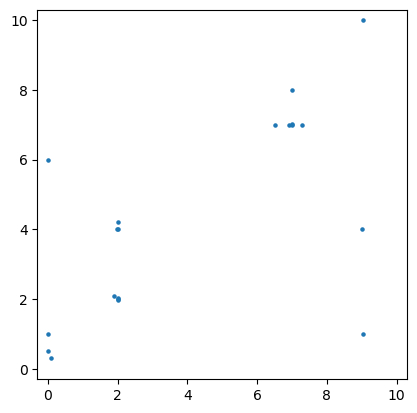

In [26]:
#box 10x10

#unformly distributed sample
# P_0 = [[0, 1], [5, 1], [2, 3], [0, 4], [7, 9], [3, 2], [8, 5], [10, 2], [7, 7], [7, 2], [8, 6], [9, 1], [5, 4], [6, 2], [7, 1], [10, 10], [2, 2], [0, 6], [4, 6], [5, 10]]

#not uniformly distributed sample
P_0 = [[0, 1], [0, 0.5], [2, 4], [2, 4.2], [1.97, 4], [1.9, 2.1], [6.9, 7], [9, 4], [7, 7], [7, 8], [7, 7.03], [9.05, 1], [6.5, 7], [2, 2.04], [7.3, 7], [9.03, 10], [2, 2], [0, 6], [0.1, 0.3], [2, 1.98]]

print(len(P_0))
vis_plot(P_0)

In [27]:
def reflect_point(x, y, box_border):
    # Отражаем по оси x
    if x < 0:
        x = -x
    elif x > box_border:
        x = 2 * box_border - x
    
    # Отражаем по оси y
    if y < 0:
        y = -y
    elif y > box_border:
        y = 2 * box_border - y
    
    return x, y

reflect_point(-5, 12, 10)

(5, 8)

In [28]:
def objOpt(P_0, mutation_rate, it, max_gen, pop_size, b, box_border):
#     
#     print("pbjopt", P_0, mutation_rate, it, max_gen, pop_size, b, box_border)
    start_time = time.time()

    a_fp = open('./obj_evolution_with_b_simple_' + str(mutation_rate) + '.json', 'w')
    b_fp = open('./sol_evolution_with_b_simple_' + str(mutation_rate) + '.json', 'w')
    iteration = 0
    B = []
    D = []
    for iteration in range(it):
        print("iteration", iteration)
        
        #Main program starts here

        #Initialization
        min_x=-55
        max_x=55
        A = defaultdict()
        C = defaultdict()
        solution = P_0

        gen_no=0
        while(gen_no<max_gen):
#             print("GENERATION", gen_no)
            function1_values = [obj1(solution[i]) for i in range(0,pop_size)]
            function2_values = [obj2(solution[i]) for i in range(0,pop_size)]
            non_dominated_sorted_solution = fast_non_dominated_sort(function1_values[:],function2_values[:])

            solution2 = solution[:]
            
            
#             for i in range(len(solution)):
#                 print(-obj1(solution[i]), -obj2(solution[i]))
            
#             print("offsprings")

            #Generating offsprings
            while(len(solution2)!=2*pop_size):
                
                s = 0
                while s == 0:
                    a1 = random.randint(0,pop_size-1)
                    app = mutation(solution[a1], mutation_rate) 
                    if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                        app = reflect_point(app[0], app[1], box_border)
                    if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (app[0]<=box_border) and (app[1]<=box_border) :
                        solution2.append(app)
#                         print(app)
#                         print(-obj1(app), -obj2(app))
                        s = 1
                    else:
                        pass
                    
            
            function1_values2 = [obj1(solution2[i]) for i in range(0,2*pop_size)]
            function2_values2 = [obj2(solution2[i]) for i in range(0,2*pop_size)]

            A[gen_no] = [function1_values, function2_values]
            non_dominated_sorted_solution2 = fast_non_dominated_sort(function1_values2[:],function2_values2[:])
            crowding_distance_values2=[]

            for i in range(0,len(non_dominated_sorted_solution2)):
                crowding_distance_values2.append(crowding_distance(function1_values2[:],function2_values2[:],non_dominated_sorted_solution2[i][:]))


            new_solution= []
            for i in range(0,len(non_dominated_sorted_solution2)):
                non_dominated_sorted_solution2_1 = [index_of(non_dominated_sorted_solution2[i][j],non_dominated_sorted_solution2[i] ) for j in range(0,len(non_dominated_sorted_solution2[i]))]
                front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
                front = [non_dominated_sorted_solution2[i][front22[j]] for j in range(0,len(non_dominated_sorted_solution2[i]))]
                front.reverse()
                for value in front:
                    new_solution.append(value)
                    if(len(new_solution)==pop_size):
                        break
                if (len(new_solution) == pop_size):
                    break
            solution = [solution2[i] for i in new_solution] 
#             vis_plot(solution)
            C[gen_no] = solution
            gen_no = gen_no + 1
        B.append(A)   
        D.append(C)
        iteration +=1  
        
        print("A[max_gen-1]", A[max_gen-1])
        for i in range(len(A[max_gen-1][0])):
            if (-A[max_gen-1][0][i] - b[0]>=epsilon) or (-A[max_gen-1][1][i] - b[1]>=epsilon):
                print('objopt final generation contains solutions >= b for iteration ', iteration)
        
    json.dump(B, a_fp)
    json.dump(D, b_fp, cls=NpEncoder)            
    a_fp.close()
    b_fp.close()

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return D[-1][max_gen-1]

# objOpt_minmax(P_0, mutation_rate, it, max_gen, pop_size, b, box_border=10)

In [29]:
def boundChange(P, b, r_number, global_bound):
    
    bound = copy.deepcopy(b)
    print("b", b)
    #Делаем маленький шаг по 2 координатам
    
    step0 = bound[0]/10000
    step1 = bound[1]/10000
    
    #Будущее значение финальной популяции из r элементов и значении b при котором это так
    fitting_conditions = [P, bound]
    
#     Пока стартовое щначение порога не уменьшится до v делаем то что делаем
#     Нам нужно найти минимальное b при котором в выборку попадает r элементов с меньше чем b обджективами
    while (bound[0]>global_bound[0]) and (bound[1]>global_bound[1]):
#         print("a")
        satisfying_sol = []
        
#       Проходимся по каждому значению популяции 
        for i in range(len(P)):
#             print(-obj1(P, i, heights), bound[0])
        
        
#         Если обджективы меньше b, добавляем их в список
            if (-obj1(P[i])<bound[0]) and (-obj2(P[i])<bound[1]):
                
                satisfying_sol.append(P[i])
#         print(satisfying_sol)
            
#             Если в списоке уже r элементов, то попробуем уменьшить b еще сильнее
        if len(satisfying_sol)>=r_number:
#         Но запомним значение при котором было r элемнтов подходящих, если вдруг при следующем уменьшении b уже не будет r, выходим из функции
            fitting_conditions = [satisfying_sol, bound]
            if random.random()<0.5:
                bound[0]-=step0
            else:
                bound[1]-=step1
        else:
            return fitting_conditions
        
    return fitting_conditions

# boundChange(P_0, heights, b, r_number, global_bound)[0]

# NOAH with min-max

In [30]:
def Diversity_minmax(P):
    M = matrix_of_distances(P)
    
    indices = []
    for i in range(len(P)):
        indices.append(i)
        
    diversity = 1000
    for i in range(len(indices)):
        for j in range(len(indices)):
            if i<j:
                if M[indices[i]][indices[j]]<diversity:
                    diversity = M[indices[i]][indices[j]]
#                     print([i, j, indices[i], indices[j]])
    return diversity

In [31]:
def SelectDiv_minmax(P, n):
#     print("P", P)
    M = matrix_of_distances(P)
    
    indices = []
    
    all_indices = []
    for i in range(len(P)):
        all_indices.append(i)
        
    #n^2 - первый элемент
    index_max_sum = -1
    max_sum = -1
    for i in range(len(P)):
        column_sum = 0
        for j in range(len(P)):
            column_sum = column_sum + M[i][j]
        if column_sum>max_sum:
            max_sum = column_sum
            index_max_sum = i
    
    indices.append(index_max_sum)
    
    
    #n^3
    for i in range(n-1):
        
#         print("i", i)
        #не выбранные индексы из всех индексов
        rest = [x for x in all_indices if x not in indices]
#         print(rest)
        
        best_index = -1000
        max_dist = -1000
        best_summa = -1000
        
    
        #цикл по еще не выбранным точкам
        for j in range(len(rest)):
            
            #находим минимальное расстояние от не выбранной точки j до всех выбранных точек
            minim_dist = 10000
            summa = 0
            sum_picked_dist = 0
            for k in range(len(indices)):
#                 print("indices", indices[k], rest[j])
                summa+=M[rest[j]][indices[k]]
                if M[rest[j]][indices[k]]< minim_dist:
                    minim_dist = M[rest[j]][indices[k]]
#                     print("minim dist", minim_dist)
#             print("final", minim_dist) 
                for q in range(len(indices)):
                    if k<q:
                        sum_picked_dist+=M[indices[k], indices[q]]
                        
            #нашли самое большое из таких 
            if minim_dist >max_dist:
                max_dist = minim_dist
                best_index = rest[j]
                    
#         print(best_index, best_summa, max_dist)
        if best_index>-1000:
            indices.append(best_index)
        
#     print("final indices", indices) 
#     print("indices", indices)
    diversity = 1000
    for i in range(len(indices)):
        for j in range(len(indices)):
            if i<j:
                if M[indices[i]][indices[j]]<diversity:
                    diversity = M[indices[i]][indices[j]]
#                     print([i, j, indices[i], indices[j]])
    
#     print("indices", [P_0[i] for i in indices])
#     vis_plot([P[i] for i in indices])
    
    
    contributions = []
    #Исключает элемент с индексом i
#     print(indices)
    exc = lambda s, i: s[:i] + s[i+1:]
    #Element for which we calculate the contribution
    for k in range(len(indices)):
        diversity_dropout = 1000 
        indices_dropout = exc(indices, k)
#         print(indices_dropout)
        for i in range(len(indices_dropout)):
            for j in range(len(indices_dropout)):
                if i<j:
                    if M[indices_dropout[i]][indices_dropout[j]]<diversity_dropout:
                        diversity_dropout = M[indices_dropout[i]][indices_dropout[j]]
#                     print([i, j, indices[i], indices[j]])
#         print(diversity_dropout)
        contributions.append(diversity - diversity_dropout)
#         print(diversity, diversity_dropout, indices)
    
#     print([indices[i] for i in list(np.nonzero(contributions)[0])], contributions)
    best = [indices[i] for i in list(np.nonzero(contributions)[0])]
    return [diversity, indices, best, [P[i] for i in best]]
    
SelectDiv_minmax(P_0, 15)


[0.15620499351813322,
 [15, 18, 11, 17, 12, 7, 2, 19, 9, 14, 0, 6, 1, 3, 5],
 [19, 5],
 [[2, 1.98], [1.9, 2.1]]]

In [32]:
#WITH B and counter - РАБОТАЕТ ЛУЧШЕ, СТОИТ ОСТАВИТЬ


#c - параметр схождения, если c раз подряд значение diversity не меняется, значит, все
# На входе будет r элементов популяции, на выходе надо n = pop_size

def divOpt_simple_minmax(P, it, pop_size, b, c, mutation_rate, box_border):
    
    start_time = time.time()

    a_fp = open('./obj_div_simple_minmax_' + str(mutation_rate) + '.json', 'w')
    b_fp = open('./sol_div_simple_minmax_' + str(mutation_rate) + '.json', 'w')
    c_fp = open('./0.9statistic_div_simple_minmax_' + str(mutation_rate) + '.json', 'w')
    iteration = 0
    A = []
    B = []
    S = []
    for iteration in range(it):
        print("iteration", iteration)
        
        #Main program starts here

        #Initialization
        min_x=-55
        max_x=55
        A = defaultdict()
        C = defaultdict()
        solution = P
        diversity = []
        
        iteration_no_change = 0

        
        selec = SelectDiv_minmax(solution, len(solution))
        diversity.append(selec[0])

        gen_no=0
        
        while(len(solution)!=pop_size):
                
                #Поменяла на len(P)=r, было pop_size
                #здесь надо выбирать только из элементов с индексами solution
#                 a1 = random.randint(0,len(P)-1)
                 
    
            s = 0
            while s == 0:
                a1 = random.randint(0,len(P)-2)
                app = mutation(solution[a1], mutation_rate)
                if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                    app = reflect_point(app[0], app[1], box_border)
                
                min_distance_from_new = 1000
                for z in range(len(solution)):
                    if my_distance(solution[z], app)<min_distance_from_new:
                        min_distance_from_new = my_distance(solution[z], app)
                            
                if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (min_distance_from_new>=diversity[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
                    solution.append(app)
                    
                    s = 1
                else:
                    pass
        
        while(iteration_no_change < c):
        #and (diversity[-1]<1.9):
#             print("GENERATION", gen_no)
            
            solution2 = solution[:]
            
            #Just printing
            
#             for i in range(len(solution)):
#                 print(-obj1(solution[i]), -obj2(solution[i]))
        
#             Generating offsprings
#             print("offsprings")

            while(len(solution2)!=pop_size+1):
                
                #Поменяла на len(P)=r, было pop_size
                #здесь надо выбирать только из элементов с индексами solution
#                 a1 = random.randint(0,len(P)-1)
                 
                s = 0
                counter = 0
                while (s == 0) and (counter < 700):
                    a1 = random.randint(0,len(P)-1)
                    app = mutation(solution[a1], mutation_rate)
                    if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                        app = reflect_point(app[0], app[1], box_border)
                    min_distance_from_new = 1000
                    for z in range(len(solution)):
                        if my_distance(solution[z], app)<min_distance_from_new:
                            min_distance_from_new = my_distance(solution[z], app)
    #                 print(min_distance_from_new)    
    #УБРАЛА  (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and
                    if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (min_distance_from_new>=diversity[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
                        solution2.append(app)
#                         print(-obj1(app), -obj2(app))
                        s = 1
                    else:
                        counter += 1
#                 print("counter", counter)
                
                if counter>=700:
                    solution2.append(solution2[random.randint(0,len(P)-2)])
                    break 
#             print("offsprings are ready")
            
            # When it is [0, 2, .., 9] it is not supposed to chenge, but it's getting lower
            
            solution = []
            
            select_div = SelectDiv_minmax(solution2, pop_size) 
#             print("select_div", select_div)
            #не забыть все нужные параметры вставить
    
    
    
    
            if np.abs(select_div[0]-diversity[-1])<epsilon:
                iteration_no_change+=1
            else:
                iteration_no_change = 0
#             print(iteration_no_change)
            diversity.append(select_div[0])  
            indices = select_div[1]
            
#             print(indices)
            
            for i in range(2*pop_size):
                if i in indices:
                    solution.append(solution2[i])
                         
#             print(heights)
            
#             save = select_div[0]
            
             
            
#             print("len solution", len(solution), len(solution[0]))
#             print(solution)
            C[gen_no] = solution
            gen_no = gen_no + 1
            max_reached_gen = gen_no
#             print(solution)
            
#         print(max_reached_gen)
        print("diversity", diversity[-1])
        S.append(max_reached_gen)
        B.append(C)
        iteration +=1  
#         print(solution)
        
    json.dump(B, b_fp, cls=NpEncoder)  
    json.dump(S, c_fp, cls=NpEncoder)            

    a_fp.close()
    b_fp.close()
    c_fp.close()

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return solution

# divOpt_simple_minmax(P_0, 100, pop_size, b, 20, 10, 10)

In [33]:
def NOAH_minmax(P, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border):
    
    global_iteration = 0
    dfhaudorf = []
    combined_rows = []

    all_diversities_minmax = []
    count = 1
    plt.subplots(figsize=(15, 60))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    
    while (b[0]>global_bound[0]) and (b[1]>global_bound[1]) and (global_iteration<max_global_iteration):
        
        print("Global_iteration: ", global_iteration, "b is ", b)
        
        #Генерим из популяции размера 10 еще 10 дополнительных потомков, но таких, чтобы были меньше b, выбираем из 20 всего 10 лучших
        #И так делаем итерации и поколения
        #На выходе новая популяция 
        print("OBJOPT", P)
        plt.subplot(max_global_iteration,6,count).set_title(f'Global iteration: {round((count-1)//6.)} \n Starting set \n Diversity: {round(Diversity_minmax(P), 5)}', size=8)
        vis_plot(P)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1
        
        all_diversities_minmax.append(
            {
                'SP diversity': SP_diversity(P, theta)/10,
                'Min-max diversity': Diversity_minmax(P),
                'S-energy diversity': s_energy(P, s)/100,
                'Average Himmelblaus function (obj1)': statistics.mean([-obj1(p) for p in P]),
                'Average x**2 function (obj1)': statistics.mean([-obj2(p) for p in P])
            }
        )
        
        plt.subplot(max_global_iteration,6,count).set_title(f'Objectives \n Average objectives: \n {round(statistics.mean([-obj1(p) for p in P]), 5)}, {round(statistics.mean([-obj2(p) for p in P]), 5)}', size=8)
        x_obj = [-obj1(p) for p in P]
        y_obj = [-obj2(p) for p in P]
        plt.scatter(x=x_obj, y=y_obj, s = 5)
        plt.axis('scaled')
        plt.xlim(-0.003, 0.1)
        plt.ylim(-0.003, 0.1)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1


        P0 = objOpt(P, mutation_rate, it, max_gen, pop_size, b, box_border)
        
        dfhaudorf.append(
            {
                'Optimization': my_hausdorff_distance(P0, efficient_set)
            }
        )
        
        plt.subplot(max_global_iteration,6,count).set_title(f'After optimization \n Diversity: {round(Diversity_minmax(P0), 5)}', size=8)
        vis_plot(P0)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1
        
        plt.subplot(max_global_iteration,6,count).set_title(f'Objectives \n Average objectives: \n {round(statistics.mean([-obj1(p) for p in P0]), 5)}, {round(statistics.mean([-obj2(p) for p in P0]), 5)}', size=8)
        x_obj = [-obj1(p) for p in P0]
        y_obj = [-obj2(p) for p in P0]
        plt.scatter(x=x_obj, y=y_obj, s = 5)
        plt.axis('scaled')
        plt.xlim(-0.003, 0.1)
        plt.ylim(-0.003, 0.1)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1

        
        print("objopt for global iteration ", global_iteration, " is ready")
        
        print("b before boundchange: ", b)
        
        #Опускаем b до мнимального значения, при котором итоговая популяция содержит r элементов с обдж меньше b
        #P содержит r элементов, надо проверить что все меньше нового b 
        bound_fun = boundChange(P0, b, r_number, global_bound)
        P1 = bound_fun[0]
        b = bound_fun[1]
        print("b after boundchange: ", b)
        print(P1)
        print(" and size of P is", len(P1))
        print("DIVOPT")
        print("parameters for divopt", P1, pop_size, b, c, mutation_rate_div, box_border)
        #Сейчас популяция размера r должна быть, достраиваем ее до 20 так чтобы все были меньше нового b 
        #Из них выбираем 10 самых разнообразных, повторяем это max_gen раз 
        P2 = divOpt_simple_minmax(P1, it, pop_size, b, c, mutation_rate_div, box_border)
        dfhaudorf.append(
            {
                'Diversity Optimization': my_hausdorff_distance(P2, efficient_set)
            }
        )
        plt.subplot(max_global_iteration,6,count).set_title(f'After diversity optimization \n Diversity: {round(Diversity_minmax(P2), 5)}', size=8)
        vis_plot(P2)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1
        
        plt.subplot(max_global_iteration,6,count).set_title(f'Objectives \n Average objectives: \n {round(statistics.mean([-obj1(p) for p in P2]), 5)}, {round(statistics.mean([-obj2(p) for p in P2]), 5)}', size=8)
        x_obj = [-obj1(p) for p in P2]
        y_obj = [-obj2(p) for p in P2]
        plt.scatter(x=x_obj, y=y_obj, s = 5)
        plt.axis('scaled')
        plt.xlim(-0.003, 0.1)
        plt.ylim(-0.003, 0.1)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1

        
        P = P2
        
        
        global_iteration+=1
        
#     print(all_diversities_minmax)
    df = pd.DataFrame(all_diversities_minmax) 
    df2 = pd.DataFrame(dfhaudorf)
    
    for i in range(0, len(df2), 2):
        optimization_val = df2['Optimization'].iloc[i] if not pd.isna(df2['Optimization'].iloc[i]) else df2['Optimization'].iloc[i + 1]
        diversity_val = df2['Diversity Optimization'].iloc[i + 1] if not pd.isna(df2['Diversity Optimization'].iloc[i + 1]) else df2['Diversity Optimization'].iloc[i]
        combined_rows.append([optimization_val, diversity_val])

# Create a new DataFrame with combined values
    combined_df = pd.DataFrame(combined_rows, columns=['Optimization', 'Diversity Optimization'])
    
    plt.savefig('minmaxiterations.png')
    
    
    lines = df.plot.line(xlim = (1, 15), ylim = (0, 2.1))
    plt.show()
    return [P, df, combined_df]

In [34]:
def NOAH_minmax_noplots(P, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border):
    
    dfhaudorf = []
    combined_rows = []
    
    global_iteration = 0
    
    all_diversities_minmax = []
        
    while (b[0]>global_bound[0]) and (b[1]>global_bound[1]) and (global_iteration<max_global_iteration):
        
        print("Global_iteration: ", global_iteration, "b is ", b)
        
        #Генерим из популяции размера 10 еще 10 дополнительных потомков, но таких, чтобы были меньше b, выбираем из 20 всего 10 лучших
        #И так делаем итерации и поколения
        #На выходе новая популяция 
#         print("OBJOPT", P)
        
        all_diversities_minmax.append(
            {
                'SP diversity': SP_diversity(P, theta)/10,
                'Min-max diversity': Diversity_minmax(P),
                'S-energy diversity': s_energy(P, s)/100
            }
        )

        P0 = objOpt(P, mutation_rate, it, max_gen, pop_size, b, box_border)
        
#         print("objopt for global iteration ", global_iteration, " is ready")
        
#         print("b before boundchange: ", b)

        dfhaudorf.append(
            {
                'Optimization': my_hausdorff_distance(P0, efficient_set)
            }
        )
        
        #Опускаем b до мнимального значения, при котором итоговая популяция содержит r элементов с обдж меньше b
        #P содержит r элементов, надо проверить что все меньше нового b 
        bound_fun = boundChange(P0, b, r_number, global_bound)
        P1 = bound_fun[0]
        b = bound_fun[1]
#         print("b after boundchange: ", b)
#         print(P1)
#         print(" and size of P is", len(P1))
#         print("DIVOPT")
#         print("parameters for divopt", P1, pop_size, b, c, mutation_rate_div, mutation_rate, box_border)
        #Сейчас популяция размера r должна быть, достраиваем ее до 20 так чтобы все были меньше нового b 
        #Из них выбираем 10 самых разнообразных, повторяем это max_gen раз 
        P2 = divOpt_simple_minmax(P1, it, pop_size, b, c, mutation_rate_div, box_border)
        
        dfhaudorf.append(
            {
                'Diversity Optimization': my_hausdorff_distance(P2, efficient_set)
            }
        )

        P = P2
        
        global_iteration+=1
    df = pd.DataFrame(all_diversities_minmax)  
    df2 = pd.DataFrame(dfhaudorf)
    
    for i in range(0, len(df2), 2):
        optimization_val = df2['Optimization'].iloc[i] if not pd.isna(df2['Optimization'].iloc[i]) else df2['Optimization'].iloc[i + 1]
        diversity_val = df2['Diversity Optimization'].iloc[i + 1] if not pd.isna(df2['Diversity Optimization'].iloc[i + 1]) else df2['Diversity Optimization'].iloc[i]
        combined_rows.append([optimization_val, diversity_val])

# Create a new DataFrame with combined values
    combined_df = pd.DataFrame(combined_rows, columns=['Optimization', 'Diversity Optimization'])

    
    return [P, df, combined_df]
# NOAH_minmax_noplots(P_0, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border)


In [35]:
def NOAH_minmax_repeats(P, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border):
    all_diversities_minmax = []
    list_of_dfs = []
    
    list_of_hausdorfs = []
    
    b_initial = copy.deepcopy(b)

    for repeat in range(repeats):
        
        print("REPEAT: ", repeat)
        b = b_initial
        
        res = NOAH_minmax_noplots(P_0, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border)

        list_of_dfs.append(res[1])
        list_of_hausdorfs.append(res[2])

    df_concat = pd.concat(list_of_dfs)
    by_row_index = df_concat.groupby(df_concat.index)
    finaldf = by_row_index.mean()
    finaldfsem = by_row_index.sem()
    df_add = finaldf + finaldfsem
    df_sub = finaldf - finaldfsem
    
    hdf_concat = pd.concat(list_of_hausdorfs)
    hby_row_index = hdf_concat.groupby(hdf_concat.index)
    hfinaldf = hby_row_index.mean()
    
    ax = finaldf.plot(xlim = (1, max_global_iteration-1), ylim = (0, 2.1), color = ['pink', 'cyan', 'orange'], linestyle = '-') 
    dashlines1 = df_sub.plot.line(ax = ax, xlim = (1, max_global_iteration-1), ylim = (0, 2), color = ['pink', 'cyan', 'orange'], linestyle = '--')
    dashlines2 = df_add.plot.line(ax = ax, xlim = (1, max_global_iteration-1), ylim = (0, 2), color = ['pink', 'cyan', 'orange'], linestyle = '--')
    ax.legend(['SP', 'Max-min', 's-Energy/100'], loc='upper right', fontsize = 12)
    ax.set_xlabel('Iteration')
    
    plt.savefig('minmaxrepeats.png')
    
    ax2 = hfinaldf.plot(xlim = (1, max_global_iteration-1), ylim = (0, 10), color = ['pink', 'cyan', 'orange'], linestyle = '-')
    
    return [finaldf, hfinaldf]


# NOAH with s-energy

In [36]:
#calculation of s-energy in N^2

def s_energy(P, s):
    sum_of_k = 0
    if s==0:
        for i in range(len(P)):
            for j in range(len(P)):
                if (i!=j):
                    sum_of_k+= -np.log(my_distance(P[i], P[j]))
    else:
        for i in range(len(P)):
            for j in range(len(P)):
                if (i!=j):
                    sum_of_k+=(my_distance(P[i], P[j]))**(-s)
#                     print((my_distance(P[i], P[j]))**(-s))
    return sum_of_k
                


In [37]:
#subset selection based on s-energy, delte elements one by one which contribute the most
def SelectDiv_senergy(P, n, s):
    
    # dissimilarity matrix
    M = np.zeros((len(P), len(P)))
    # memoization structure
    r = []
    for i in range(len(P)):
        summa = 0
        for j in range(len(P)):
            if i!=j:
                if s==0:
                    M[i][j] = -np.log(my_distance(P[i], P[j]))
                    summa += M[i][j]
                else:
                    M[i][j] = (my_distance(P[i], P[j]))**(-s)
                    summa += M[i][j]
                    
        r.append(summa) 
#     print("M", M)
#     print(r)
    
    P_new = copy.deepcopy(P)
    indices_new = list(range(len(P)))
    r_new = copy.deepcopy(r)
#     print(indices_new)
    #number of deletions
    
#     print("initial P", P_new)

    for i in range(len(P)-n):
        
        #calculate all contributions j = 0, len(P_new)-1
        contribution = np.zeros(len(P_new))
        max_contrib = -1000
        arg_max = -1
        
        for j in range(len(P_new)):
    
            r_new_temp = r_new - M[:, j] #вычли из столбца сумм столбец соответствующий элементу j 
            energy_without_j = np.sum(r_new_temp)- r_new_temp[j] # теперь вычли строчку j 
#             print(energy_without_j, "energy_without_j") 
            contribution[j] = np.sum(r_new) - energy_without_j #
#             print(contribution[j], "contribution[j]", r_new_temp[j])
            if contribution[j]>max_contrib:
                max_contrib = contribution[j]
                arg_max = j
        
        P_new.pop(arg_max)
        indices_new.pop(arg_max)
        
#         print("new P", P_new, indices_new)
    return [s_energy(P_new, s), indices_new]

# SelectDiv_senergy(P_0, 9, 3)

In [38]:
#c - параметр схождения, если c раз подряд значение diversity не меняется, значит, все
# На входе будет r элементов популяции, на выходе надо n = pop_size

def divOpt_simple_senergy(P, it, pop_size, b, c, mutation_rate, box_border, s_par):
    
    start_time = time.time()

    a_fp = open('./obj_div_simple_senergy_' + str(mutation_rate) + '.json', 'w')
    b_fp = open('./sol_div_simple_senergy_' + str(mutation_rate) + '.json', 'w')
    c_fp = open('./statistic_div_simple_senergy_' + str(mutation_rate) + '.json', 'w')
    iteration = 0
    A = []
    B = []
    S = []
    for iteration in range(it):
        print("iteration", iteration)
        
        #Main program starts here

        #Initialization
        min_x=-55
        max_x=55
        A = defaultdict()
        C = defaultdict()
        solution = P
        energies = []
        
        iteration_no_change = 0

        
        selec = SelectDiv_senergy(solution, len(solution), s_par)
        energies.append(selec[0])
        
#         print(selec)

        gen_no=0
    
        
        while(len(solution)!=pop_size):
                
                #Поменяла на len(P)=r, было pop_size
                #здесь надо выбирать только из элементов с индексами solution
#                 a1 = random.randint(0,len(P)-1)
                 
    
            s = 0
            while s == 0:
                a1 = random.randint(0,len(P)-2)
                app = mutation(solution[a1], mutation_rate)
                if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                    app = reflect_point(app[0], app[1], box_border)
                        
                new_set = copy.deepcopy(solution)
                new_set.pop(a1)
                new_set.append(app)
    
    
                if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (s_energy(new_set, s_par)<=energies[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
                    solution.append(app)
#                         print(-obj1(app), -obj2(app))
                    s = 1
                else:
                    pass
        
        while(iteration_no_change < c):
            print("GENERATION", gen_no)
            
            solution2 = solution[:]
            
            #Just printing
            
#             for i in range(len(solution)):
#                 print(-obj1(solution[i]), -obj2(solution[i]))
        
#             Generating offsprings
#             print("offsprings")

            while(len(solution2)!=pop_size+1):
                
                #Поменяла на len(P)=r, было pop_size
                #здесь надо выбирать только из элементов с индексами solution
#                 a1 = random.randint(0,len(P)-1)
                 
    
                s = 0
                counter = 0
                while (s == 0) and (counter < 700):
                    a1 = random.randint(0,len(P)-1)
                    app = mutation(solution[a1], mutation_rate)
                    if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                        app = reflect_point(app[0], app[1], box_border)
                        
                        
                        
#                     min_distance_from_new = 1000
#                     for z in range(len(solution)):
#                         if my_distance(solution[z], app)<min_distance_from_new:
#                             min_distance_from_new = my_distance(solution[z], app)
                    
                    new_set = copy.deepcopy(solution)
                    new_set.pop(a1)
                    new_set.append(app)
                    
    
                    if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (s_energy(new_set, s_par)<=energies[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
                        solution2.append(app)
#                         print(-obj1(app), -obj2(app))
                        s = 1
                    else:
                        counter += 1
#                 print("counter", counter)
                if counter >= 700:
#                     solution2.append(solution2[random.randint(0,len(P)-2)])
                    break
#             print("offsprings are ready")
            
            # When it is [0, 2, .., 9] it is not supposed to chenge, but it's getting lower
            
            solution = []
            
            select_div = SelectDiv_senergy(solution2, pop_size, s_par) 
#             print("select_div", select_div)
            #не забыть все нужные параметры вставить
    
    
    
    
            if np.abs(select_div[0]-energies[-1])<epsilon:
                iteration_no_change+=1
            else:
                iteration_no_change = 0
#             print(iteration_no_change)
            energies.append(select_div[0])  
            
            indices = select_div[1]
            
            for i in range(2*pop_size):
                if i in indices:
                    solution.append(solution2[i])
                 
            C[gen_no] = solution
            gen_no = gen_no + 1
            max_reached_gen = gen_no
#             print(solution)
            
#         print(max_reached_gen)
#         print("diversity", diversity[-1])
        S.append(max_reached_gen)
        B.append(C)
        iteration +=1  
#         print(solution)
    print("all energies", energies, solution)    
    json.dump(B, b_fp, cls=NpEncoder)  
    json.dump(S, c_fp, cls=NpEncoder)            

    a_fp.close()
    b_fp.close()
    c_fp.close()

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return solution

# divOpt_simple_senergy(P_0, 5, pop_size, b, c, 10, 10, 3)

In [39]:
def NOAH_senergy(P, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, s):
    
    global_iteration = 0
    dfhaudorf = []
    combined_rows = []
    
    all_diversities_senergy = []
    
    count = 1
    plt.subplots(figsize=(15, 60))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    
    
    while (b[0]>global_bound[0]) and (b[1]>global_bound[1]) and (global_iteration<max_global_iteration):
        
        print("Global_iteration: ", global_iteration, "b is ", b)
        
        #Генерим из популяции размера 10 еще 10 дополнительных потомков, но таких, чтобы были меньше b, выбираем из 20 всего 10 лучших
        #И так делаем итерации и поколения
        #На выходе новая популяция 
        print("OBJOPT", P)
        plt.subplot(max_global_iteration,6,count).set_title(f'Global iteration: {round((count-1)//6.)} \n Starting set \n Diversity: {round(s_energy(P, s), 5)}', size=8)
        vis_plot(P)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1
        
        all_diversities_senergy.append(
            {
                'SP diversity': SP_diversity(P, theta)/10,
                'Min-max diversity': Diversity_minmax(P),
                'S-energy diversity': s_energy(P, s)/1000,
                'Average Himmelblaus function (obj1)': statistics.mean([-obj1(p) for p in P]),
                'Average x**2 function (obj1)': statistics.mean([-obj2(p) for p in P])
            }
        )
        
        plt.subplot(max_global_iteration,6,count).set_title(f'Objectives \n Average objectives: \n {round(statistics.mean([-obj1(p) for p in P]), 5)}, {round(statistics.mean([-obj2(p) for p in P]), 5)}', size=8)
        x_obj = [-obj1(p) for p in P]
        y_obj = [-obj2(p) for p in P]
        plt.scatter(x=x_obj, y=y_obj, s = 5)
        plt.axis('scaled')
        plt.xlim(-0.003, 0.1)
        plt.ylim(-0.003, 0.1)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1


        P0 = objOpt(P, mutation_rate, it, max_gen, pop_size, b, box_border)
        dfhaudorf.append(
            {
                'Optimization': my_hausdorff_distance(P0, efficient_set)
            }
        )
        plt.subplot(max_global_iteration,6,count).set_title(f'After optimization \n Diversity: {round(s_energy(P0, s), 5)}', size=8)
        vis_plot(P0)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1
        
        plt.subplot(max_global_iteration,6,count).set_title(f'Objectives \n Average objectives: \n {round(statistics.mean([-obj1(p) for p in P0]), 5)}, {round(statistics.mean([-obj2(p) for p in P0]), 5)}', size=8)
        x_obj = [-obj1(p) for p in P0]
        y_obj = [-obj2(p) for p in P0]
        plt.scatter(x=x_obj, y=y_obj, s = 5)
        plt.axis('scaled')
        plt.xlim(-0.003, 0.1)
        plt.ylim(-0.003, 0.1)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1

        
        print("objopt for global iteration ", global_iteration, " is ready")
        
        print("b before boundchange: ", b)
        
        #Опускаем b до мнимального значения, при котором итоговая популяция содержит r элементов с обдж меньше b
        #P содержит r элементов, надо проверить что все меньше нового b 
        bound_fun = boundChange(P0, b, r_number, global_bound)
        P1 = bound_fun[0]
        b = bound_fun[1]
        print("b after boundchange: ", b)
        print(P1)
        print(" and size of P is", len(P1))
        print("DIVOPT")
        print("parameters for divopt", P1, pop_size, b, c, mutation_rate_div, box_border, s)
        #Сейчас популяция размера r должна быть, достраиваем ее до 20 так чтобы все были меньше нового b 
        #Из них выбираем 10 самых разнообразных, повторяем это max_gen раз 
        P2 = divOpt_simple_senergy(P1, it, pop_size, b, c, mutation_rate_div, box_border, s)
        dfhaudorf.append(
            {
                'Diversity Optimization': my_hausdorff_distance(P2, efficient_set)
            }
        )
        
        plt.subplot(max_global_iteration,6,count).set_title(f'After diversity optimization \n Diversity: {round(s_energy(P2, s), 5)}', size=8)
        vis_plot(P2)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1
        
        plt.subplot(max_global_iteration,6,count).set_title(f'Objectives \n Average objectives: \n {round(statistics.mean([-obj1(p) for p in P2]), 5)}, {round(statistics.mean([-obj2(p) for p in P2]), 5)}', size=8)
        x_obj = [-obj1(p) for p in P2]
        y_obj = [-obj2(p) for p in P2]
        plt.scatter(x=x_obj, y=y_obj, s = 5)
        plt.axis('scaled')
        plt.xlim(-0.003, 0.1)
        plt.ylim(-0.003, 0.1)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1

        
        P = P2
        
        global_iteration+=1
        
    df = pd.DataFrame(all_diversities_senergy)
    df2 = pd.DataFrame(dfhaudorf)
    
    for i in range(0, len(df2), 2):
        optimization_val = df2['Optimization'].iloc[i] if not pd.isna(df2['Optimization'].iloc[i]) else df2['Optimization'].iloc[i + 1]
        diversity_val = df2['Diversity Optimization'].iloc[i + 1] if not pd.isna(df2['Diversity Optimization'].iloc[i + 1]) else df2['Diversity Optimization'].iloc[i]
        combined_rows.append([optimization_val, diversity_val])

# Create a new DataFrame with combined values
    combined_df = pd.DataFrame(combined_rows, columns=['Optimization', 'Diversity Optimization'])
    
    plt.savefig('senergyiterations.png')
    plt.show()
    lines = df.plot.line(xlim = (1, 15), ylim = (0, 2.1))
    return [P, df, combined_df]

In [40]:
def NOAH_senergy_noplots(P, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, s):
    
    global_iteration = 0
    dfhaudorf = []
    combined_rows = []
    
    all_diversities_senergy = []
   
    while (b[0]>global_bound[0]) and (b[1]>global_bound[1]) and (global_iteration<max_global_iteration):
        
        print("Global_iteration: ", global_iteration, "b is ", b)
        
        #Генерим из популяции размера 10 еще 10 дополнительных потомков, но таких, чтобы были меньше b, выбираем из 20 всего 10 лучших
        #И так делаем итерации и поколения
        #На выходе новая популяция 

        
        all_diversities_senergy.append(
            {
                'SP diversity': SP_diversity(P, theta)/10,
                'Min-max diversity': Diversity_minmax(P),
                'S-energy diversity': s_energy(P, s)/1000
            }
        )

        P0 = objOpt(P, mutation_rate, it, max_gen, pop_size, b, box_border)
        
        dfhaudorf.append(
            {
                'Optimization': my_hausdorff_distance(P0, efficient_set)
            }
        )
        
        #Опускаем b до мнимального значения, при котором итоговая популяция содержит r элементов с обдж меньше b
        #P содержит r элементов, надо проверить что все меньше нового b 
        bound_fun = boundChange(P0, b, r_number, global_bound)
        P1 = bound_fun[0]
        b = bound_fun[1]
        #Сейчас популяция размера r должна быть, достраиваем ее до 20 так чтобы все были меньше нового b 
        #Из них выбираем 10 самых разнообразных, повторяем это max_gen раз 
        P2 = divOpt_simple_senergy(P1, it, pop_size, b, c, mutation_rate_div, box_border, s)
        
        dfhaudorf.append(
            {
                'Diversity Optimization': my_hausdorff_distance(P2, efficient_set)
            }
        )
        
        P = P2
        
        global_iteration+=1
        
    df = pd.DataFrame(all_diversities_senergy)
    df2 = pd.DataFrame(dfhaudorf)
    
    for i in range(0, len(df2), 2):
        optimization_val = df2['Optimization'].iloc[i] if not pd.isna(df2['Optimization'].iloc[i]) else df2['Optimization'].iloc[i + 1]
        diversity_val = df2['Diversity Optimization'].iloc[i + 1] if not pd.isna(df2['Diversity Optimization'].iloc[i + 1]) else df2['Diversity Optimization'].iloc[i]
        combined_rows.append([optimization_val, diversity_val])

# Create a new DataFrame with combined values
    combined_df = pd.DataFrame(combined_rows, columns=['Optimization', 'Diversity Optimization'])
    
    return [P, df, combined_df]

In [41]:
def NOAH_senergy_repeats(P, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, s):
    all_diversities_minmax = []
    list_of_dfs = []
    list_of_hausdorfs = []
    
    b_initial = copy.deepcopy(b)

    for repeat in range(repeats):
        
        print("REPEAT: ", repeat)
        b = b_initial
        
        res = NOAH_senergy_noplots(P, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, s)
        list_of_dfs.append(res[1])
        list_of_hausdorfs.append(res[2])
        
    df_concat = pd.concat(list_of_dfs)
    by_row_index = df_concat.groupby(df_concat.index)
    finaldf = by_row_index.mean()
    finaldfsem = by_row_index.sem()
    df_add = finaldf + finaldfsem
    df_sub = finaldf - finaldfsem
    
    hdf_concat = pd.concat(list_of_hausdorfs)
    hby_row_index = hdf_concat.groupby(hdf_concat.index)
    hfinaldf = hby_row_index.mean()
    
    ax = finaldf.plot(xlim = (1, max_global_iteration-1), ylim = (0, 2.1), color = ['pink', 'cyan', 'orange'], linestyle = '-') 
    dashlines1 = df_sub.plot.line(ax = ax, xlim = (1, max_global_iteration-1), ylim = (0, 2.1), color = ['pink', 'cyan', 'orange'], linestyle = '--')
    dashlines2 = df_add.plot.line(ax = ax, xlim = (1, max_global_iteration-1), ylim = (0, 2.1), color = ['pink', 'cyan', 'orange'], linestyle = '--')
    ax.legend(['SP/10', 'Max-min', 's-Energy/1000'], loc='upper left', fontsize = 12)
    plt.savefig('senergyrepeats.png')
    ax.set_xlabel('Iteration')
    
    
    ax2 = hfinaldf.plot(xlim = (1, max_global_iteration-1), ylim = (0, 10), color = ['pink', 'cyan', 'orange'], linestyle = '-')
    
    return [finaldf, hfinaldf]


# NOAH with S-P

In [42]:
def SelectDiv_SP(P, n, theta):
    
    if (n>len(P)) or (n<1):
        print("wrong n", len(P), n)
        return -1
    
#     print(len(P))
    indices = []
    #Создаем матрицу
    M = np.exp(-matrix_of_distances(P) * theta)
#     print("M is calculated")
#     print("M", M)
    #     Берем обратную матрицу
    Dp = np.linalg.inv(M)
#     print(np.sum(Dp), M, Dp)

#   Делаем список [0, 1, 2, ...]
    all_indices = list(range(len(P)))

#     Считаем сумму квадратов элементов по столбцам, деленную на диагональный элемент
    for k in range(len(P) - n):
        
        lis = []
        for i in range(len(Dp)):
            a = 0
            for j in range(len(Dp)):
                a+=Dp[i][j]
            a = (a**2)/Dp[i][i]
            lis.append(a)
            
#         print("optimal", b)
        
#         contributions = []
#         for i in range(len(Dp)):
#             A = np.delete(np.delete(M, i, 0), i, 1)
#             B = np.linalg.inv(A)
#             contributions.append(np.sum(Dp) - np.sum(B)) 
#         print("non-optimal", contributions)
        
#         minarg_cont = contributions.index(min(contributions))
            
# #      Находим номер столбца, при котором сумма столбца минимальна            
        minarg = lis.index(min(lis))
        
#       Записываем в список индексов
        indices.append(minarg)
          
#         print("before deletion", Dp)
#         print("what to subtract", np.outer(np.delete(b, minarg, 0), np.delete(b, minarg, 0))/Dp[minarg, minarg])
# #         Новая обратная матрица считается как старая обратная матрица без строки и столбца - произведение этого столбца на строку/диагональный элемент
#         Dp = np.delete(np.delete(Dp, minarg, 0), minarg, 1) - np.outer(np.delete(b, minarg, 0), np.delete(b, minarg, 0))/Dp[minarg, minarg]
#         print("after deletion", np.sum(Dp), Dp)
        
        
        Dp = np.linalg.inv(np.delete(np.delete(np.linalg.inv(Dp), minarg, 0), minarg, 1))
        
#         print(Dp, Dp_cont)
        #Проверить не оптимальным способом!!!!
#     print(indices)    
#     Удаляем все индексы из списка всех индексов, 
    for i in indices:
        del all_indices[i]
#     print(all_indices)    
#     Выводим финальное дайверсити после всех удалений и список оставшихся индексов
    return [np.sum(Dp), all_indices]

# SelectDiv_SP(P_0,5, 1)

In [43]:
def SP_diversity(P, theta):
    M = np.exp(-matrix_of_distances(P) * theta)
    Dp = np.linalg.inv(M)
    return np.sum(Dp)

# SP_diversity(P_0, 1)

In [44]:
#c - параметр схождения, если c раз подряд значение diversity не меняется, значит, все
# На входе будет r элементов популяции, на выходе надо n = pop_size

def divOpt_simple_SP(P, it, pop_size, b, c, mutation_rate, box_border, theta):
    
    start_time = time.time()

    a_fp = open('./obj_div_simple_SP_' + str(mutation_rate) + '.json', 'w')
    b_fp = open('./sol_div_simple_SP_' + str(mutation_rate) + '.json', 'w')
    c_fp = open('./statistic_div_simple_SP_' + str(mutation_rate) + '.json', 'w')
    iteration = 0
    A = []
    B = []
    S = []
    for iteration in range(it):
        print("iteration", iteration)
        
        #Main program starts here

        #Initialization
        min_x=-55
        max_x=55
        A = defaultdict()
        C = defaultdict()
        solution = P
        diversity = []
        
        iteration_no_change = 0

        
        selec = SelectDiv_SP(solution, len(solution), theta)
        diversity.append(selec[0])
        
#         print(selec)

        gen_no=0
    
    
    
        while(len(solution)!=pop_size):
                
                #Поменяла на len(P)=r, было pop_size
                #здесь надо выбирать только из элементов с индексами solution
#                 a1 = random.randint(0,len(P)-1)
                 
    
            s = 0
            counter = 0
            while s == 0:
                a1 = random.randint(0,len(P)-2)
                app = mutation(solution[a1], mutation_rate)
                if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                    app = reflect_point(app[0], app[1], box_border)
                        
                new_set = copy.deepcopy(solution)
                new_set.append(app)
    
    
                if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (SP_diversity(new_set, theta)>=diversity[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
                    solution.append(app)
#                         print(-obj1(app), -obj2(app))
                    s = 1
                else:
                    pass
    
    
    
    
    
    
        while(iteration_no_change < c):
            print("GENERATION", gen_no)
            
            solution2 = solution[:]
            
            #Just printing
            
#             for i in range(len(solution)):
#                 print(-obj1(solution[i]), -obj2(solution[i]))
        
#             Generating offsprings
#             print("offsprings")
#             print("before while (len(solution2)!=pop_size+1)", len(solution2), pop_size+1)
            while(len(solution2)!=pop_size+1):
                
                #Поменяла на len(P)=r, было pop_size
                #здесь надо выбирать только из элементов с индексами solution
#                 a1 = random.randint(0,len(P)-1)
                 
    
                s = 0
                counter = 0
                while (s == 0) and (counter < 700):
                    a1 = random.randint(0,len(P)-1)
                    app = mutation(solution[a1], mutation_rate)
                    if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                        app = reflect_point(app[0], app[1], box_border)
                        
                    new_set = copy.deepcopy(solution)
                    new_set.append(app)
    
    
                    if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (SP_diversity(new_set, theta)>=diversity[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
                        solution2.append(app)
#                         print(-obj1(app), -obj2(app))
                        s = 1
                    else:
                        counter += 1
#                 print("counter", counter)
                if counter>= 700:
#                     solution2.append(solution2[random.randint(0,len(P)-2)])
                    break
#             print("offsprings are ready")
            
            # When it is [0, 2, .., 9] it is not supposed to chenge, but it's getting lower
            
            solution = []
            
#             print("before the error in SelectDiv_SP(solution2, pop_size, theta)", len(solution2), pop_size)
            select_div = SelectDiv_SP(solution2, pop_size, theta) 
#             print("select_div", select_div)
            #не забыть все нужные параметры вставить
    
    
    
    
            if np.abs(select_div[0]-diversity[-1])<epsilon:
                iteration_no_change+=1
            else:
                iteration_no_change = 0
#             print(iteration_no_change)
            diversity.append(select_div[0])  
            
            indices = select_div[1]
            
            for i in range(2*pop_size):
                if i in indices:
                    solution.append(solution2[i])
                 
            C[gen_no] = solution
            gen_no = gen_no + 1
            max_reached_gen = gen_no
#             print(solution)
            
#         print(max_reached_gen)
#         print("diversity", diversity[-1])
        S.append(max_reached_gen)
        B.append(C)
        iteration +=1  
        print(solution)
    print("all diversities", diversity)    
    json.dump(B, b_fp, cls=NpEncoder)  
    json.dump(S, c_fp, cls=NpEncoder)            

    a_fp.close()
    b_fp.close()
    c_fp.close()

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return solution

# divOpt_simple_SP(P_0, 5, pop_size, b, c, 10, 10, 1)

In [45]:
###
def NOAH_SP(P, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta):
    
    all_diversities_SP = []
    dfhaudorf = []
    combined_rows = []
    global_iteration = 0
    
    count = 1
    plt.subplots(figsize=(15, 60))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    #len P = 20
    while (b[0]>global_bound[0]) and (b[1]>global_bound[1]) and (global_iteration<max_global_iteration):
        
        
        
        print("Global_iteration: ", global_iteration, "b is ", b)
        
        #Генерим из популяции размера 10 еще 10 дополнительных потомков, но таких, чтобы были меньше b, выбираем из 20 всего 10 лучших
        #И так делаем итерации и поколения
        #На выходе новая популяция 
        print("OBJOPT", P)
        plt.subplot(max_global_iteration,6,count).set_title(f'Global iteration: {round((count-1)//6.)} \n Starting set \n Diversity: {round(SP_diversity(P, theta), 5)}', size=8)
        vis_plot(P)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1
        
        all_diversities_SP.append(
            {
                'SP diversity': SP_diversity(P, theta)/10,
                'Min-max diversity': Diversity_minmax(P),
                'S-energy diversity': s_energy(P, s)/10000,
                'Average Himmelblaus function (obj1)': statistics.mean([-obj1(p) for p in P]),
                'Average x**2 function (obj1)': statistics.mean([-obj2(p) for p in P])
            }
        )
        
        plt.subplot(max_global_iteration,6,count).set_title(f'Objectives \n Average objectives: \n {round(statistics.mean([-obj1(p) for p in P]), 5)}, {round(statistics.mean([-obj2(p) for p in P]), 5)}', size=8)
        x_obj = [-obj1(p) for p in P]
        y_obj = [-obj2(p) for p in P]
        plt.scatter(x=x_obj, y=y_obj, s = 5)
        plt.axis('scaled')
        plt.xlim(-0.003, 0.1)
        plt.ylim(-0.003, 0.1)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1


        P0 = objOpt(P, mutation_rate, it, max_gen, pop_size, b, box_border)
        dfhaudorf.append(
            {
                'Optimization': my_hausdorff_distance(P0, efficient_set)
            }
        )
        # len P0 20
        plt.subplot(max_global_iteration,6,count).set_title(f'After optimization \n Diversity: {round(SP_diversity(P0, theta), 5)}', size=8)
        vis_plot(P0)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1
        
        plt.subplot(max_global_iteration,6,count).set_title(f'Objectives \n Average objectives: \n {round(statistics.mean([-obj1(p) for p in P0]), 5)}, {round(statistics.mean([-obj2(p) for p in P0]), 5)}', size=8)
        x_obj = [-obj1(p) for p in P0]
        y_obj = [-obj2(p) for p in P0]
        plt.scatter(x=x_obj, y=y_obj, s = 5)
        plt.axis('scaled')
        plt.xlim(-0.003, 0.1)
        plt.ylim(-0.003, 0.1)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1

        
        print("objopt for global iteration ", global_iteration, " is ready")
        
        print("b before boundchange: ", b)
        
        #Опускаем b до мнимального значения, при котором итоговая популяция содержит r элементов с обдж меньше b
        #P содержит r элементов, надо проверить что все меньше нового b 
        bound_fun = boundChange(P0, b, r_number, global_bound)
        #len P1 19 = r
        P1 = bound_fun[0]
        b = bound_fun[1]
        print("b after boundchange: ", b)
        print(P1)
        print(" and size of P is", len(P1))
        print("DIVOPT")
        print("parameters for divopt", P1, pop_size, b, c, mutation_rate_div, box_border, theta)
        #Сейчас популяция размера r должна быть, достраиваем ее до 20 так чтобы все были меньше нового b 
        #Из них выбираем 10 самых разнообразных, повторяем это max_gen раз 
        P2 = divOpt_simple_SP(P1, it, pop_size, b, c, mutation_rate_div, box_border, theta)
        dfhaudorf.append(
            {
                'Diversity Optimization': my_hausdorff_distance(P2, efficient_set)
            }
        )
        #len P2 20
        plt.subplot(max_global_iteration,6,count).set_title(f'After diversity optimization \n Diversity: {round(SP_diversity(P2, theta), 5)}', size=8)
        vis_plot(P2)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1
        
        plt.subplot(max_global_iteration,6,count).set_title(f'Objectives \n Average objectives: \n {round(statistics.mean([-obj1(p) for p in P2]), 5)}, {round(statistics.mean([-obj2(p) for p in P2]), 5)}', size=8)
        x_obj = [-obj1(p) for p in P2]
        y_obj = [-obj2(p) for p in P2]
        plt.scatter(x=x_obj, y=y_obj, s = 5)
        plt.axis('scaled')
        plt.xlim(-0.003, 0.1)
        plt.ylim(-0.003, 0.1)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7, rotation = 90)
        count+=1

        
        P = P2
        
        global_iteration+=1
        
    df = pd.DataFrame(all_diversities_SP)
    df2 = pd.DataFrame(dfhaudorf)
    
    for i in range(0, len(df2), 2):
        optimization_val = df2['Optimization'].iloc[i] if not pd.isna(df2['Optimization'].iloc[i]) else df2['Optimization'].iloc[i + 1]
        diversity_val = df2['Diversity Optimization'].iloc[i + 1] if not pd.isna(df2['Diversity Optimization'].iloc[i + 1]) else df2['Diversity Optimization'].iloc[i]
        combined_rows.append([optimization_val, diversity_val])

# Create a new DataFrame with combined values
    combined_df = pd.DataFrame(combined_rows, columns=['Optimization', 'Diversity Optimization'])
    
    
    
    plt.savefig('spiterations.png')
      
    plt.show()
    
    lines = df.plot.line(xlim = (1, 15), ylim = (0, 2.1))

    return [P, df, combined_df]

In [46]:
###
def NOAH_SP_noplots(P, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta):
    
    all_diversities_SP = []
    dfhaudorf = []
    combined_rows = []
    global_iteration = 0
    
    #len P = 20
    while (b[0]>global_bound[0]) and (b[1]>global_bound[1]) and (global_iteration<max_global_iteration):
        
        
        
        print("Global_iteration: ", global_iteration, "b is ", b)
        
        #Генерим из популяции размера 10 еще 10 дополнительных потомков, но таких, чтобы были меньше b, выбираем из 20 всего 10 лучших
        #И так делаем итерации и поколения
        #На выходе новая популяция 
#         print("OBJOPT", P)
        all_diversities_SP.append(
            {
                'SP diversity': SP_diversity(P, theta)/10,
                'Min-max diversity': Diversity_minmax(P),
                'S-energy diversity': s_energy(P, s)/10000
            }
        )
        

        P0 = objOpt(P, mutation_rate, it, max_gen, pop_size, b, box_border)
        
        dfhaudorf.append(
            {
                'Optimization': my_hausdorff_distance(P0, efficient_set)
            }
        )
        
        #Опускаем b до мнимального значения, при котором итоговая популяция содержит r элементов с обдж меньше b
        #P содержит r элементов, надо проверить что все меньше нового b 
        bound_fun = boundChange(P0, b, r_number, global_bound)
        #len P1 19 = r
        P1 = bound_fun[0]
        b = bound_fun[1]
        #Сейчас популяция размера r должна быть, достраиваем ее до 20 так чтобы все были меньше нового b 
        #Из них выбираем 10 самых разнообразных, повторяем это max_gen раз 
        P2 = divOpt_simple_SP(P1, it, pop_size, b, c, mutation_rate_div, box_border, theta)
        
        dfhaudorf.append(
            {
                'Diversity Optimization': my_hausdorff_distance(P2, efficient_set)
            }
        )
        #len P2 20
        
        P = P2
        
        global_iteration+=1
        
    df = pd.DataFrame(all_diversities_SP)
    df2 = pd.DataFrame(dfhaudorf)
    
    for i in range(0, len(df2), 2):
        optimization_val = df2['Optimization'].iloc[i] if not pd.isna(df2['Optimization'].iloc[i]) else df2['Optimization'].iloc[i + 1]
        diversity_val = df2['Diversity Optimization'].iloc[i + 1] if not pd.isna(df2['Diversity Optimization'].iloc[i + 1]) else df2['Diversity Optimization'].iloc[i]
        combined_rows.append([optimization_val, diversity_val])

# Create a new DataFrame with combined values
    combined_df = pd.DataFrame(combined_rows, columns=['Optimization', 'Diversity Optimization'])
    

    return [P, df, combined_df]

In [47]:
def NOAH_SP_repeats(P, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta):
    all_diversities_minmax = []
    list_of_dfs = []
    list_of_hausdorfs = []
    
    b_initial = copy.deepcopy(b)

    for repeat in range(repeats):
        
        print("REPEAT: ", repeat)
        b = b_initial
        
        res = NOAH_SP_noplots(P, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)
        list_of_dfs.append(res[1])
        list_of_hausdorfs.append(res[2])
    
    df_concat = pd.concat(list_of_dfs)
    by_row_index = df_concat.groupby(df_concat.index)
    finaldf = by_row_index.mean()
    finaldfsem = by_row_index.sem()
    df_add = finaldf + finaldfsem
    df_sub = finaldf - finaldfsem
    
    hdf_concat = pd.concat(list_of_hausdorfs)
    hby_row_index = hdf_concat.groupby(hdf_concat.index)
    hfinaldf = hby_row_index.mean()
    
    ax = finaldf.plot(xlim = (1, max_global_iteration-1), ylim = (0, 2.1), color = ['pink', 'cyan', 'orange'], linestyle = '-') 
    dashlines1 = df_sub.plot.line(ax = ax, xlim = (1, max_global_iteration-1), ylim = (0, 2.1), color = ['pink', 'cyan', 'orange'], linestyle = '--')
    dashlines2 = df_add.plot.line(ax = ax, xlim = (1, max_global_iteration-1), ylim = (0, 2.1), color = ['pink', 'cyan', 'orange'], linestyle = '--')
    ax.legend(['SP/10', 'Max-min', 's-Energy/10000'], loc='upper left', fontsize = 12)
    plt.savefig('sprepeats.png')
    ax.set_xlabel('Iteration')
    
    ax2 = hfinaldf.plot(xlim = (1, max_global_iteration-1), ylim = (0, 10), color = ['pink', 'cyan', 'orange'], linestyle = '-')
    
    return [finaldf, hfinaldf]




# Results

20


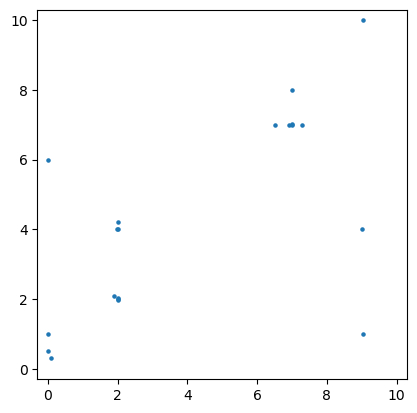

In [48]:
#not uniformly distributed sample
P_0 = [[0, 1], [0, 0.5], [2, 4], [2, 4.2], [1.97, 4], [1.9, 2.1], [6.9, 7], [9, 4], [7, 7], [7, 8], [7, 7.03], [9.05, 1], [6.5, 7], [2, 2.04], [7.3, 7], [9.03, 10], [2, 2], [0, 6], [0.1, 0.3], [2, 1.98]]

print(len(P_0))
vis_plot(P_0)

Global_iteration:  0 b is  [3, 3]
OBJOPT [[0, 1], [0, 0.5], [2, 4], [2, 4.2], [1.97, 4], [1.9, 2.1], [6.9, 7], [9, 4], [7, 7], [7, 8], [7, 7.03], [9.05, 1], [6.5, 7], [2, 2.04], [7.3, 7], [9.03, 10], [2, 2], [0, 6], [0.1, 0.3], [2, 1.98]]
iteration 0
A[max_gen-1] [[-0.00330149836769855, -0.005029070666353292, -0.0011301643248710627, -0.0032389865375623697, -0.002931201029124246, -0.0017981565672580207, -0.0003894286375366624, -0.004065111890461511, -0.002868943944800084, -0.009648701532833271, -0.004503704854868625, -0.0062233529044921, -0.003862874293737296, -0.004061764385830371, -0.004178744036805244, -0.004924289559544994, -0.005194303457092612, -0.002271697934141637, -0.005549308257783158, -0.0036504907155413806], [-0.028223812842016454, -0.01370099433978718, -0.05557640853502421, -0.03000960625576522, -0.032098842309429165, -0.04480053177055335, -0.08682407342607072, -0.021177848994928857, -0.03332420630451525, -0.001205532848353923, -0.018199227382419293, -0.007770826756925415, 

objopt for global iteration  2  is ready
b before boundchange:  [0.08984096999954762, 0.05726690999954569]
b [0.08984096999954762, 0.05726690999954569]
b after boundchange:  [0.07502619404662465, 0.04788659014161742]
[[3.787684454276794, 7.901786353692074], [2.317488835798782, 8.017164569848951], [2.598796619395763, 8.401283004139517], [2.2205744771474163, 8.014817449981189], [7.598519105491182, 7.08922811125021], [3.398120240274882, 8.063574165173213], [7.384485353039352, 7.062097800460531], [3.1219115918738796, 8.201213015639404], [3.713637171258988, 8.043457888169328], [7.508931442620954, 7.197230752776981], [3.1247826046279976, 8.416439614429114], [2.9594309736519873, 8.243884539152054], [8.080469593696584, 7.016628134502529], [7.994673884720964, 7.1711552331507935], [3.917282983355915, 7.922895846552235], [3.604117761215405, 7.795266786273193], [2.3970736938580277, 7.948803118924088], [3.8485023823653077, 7.771471466000934], [2.8935635022483104, 8.182231999929892]]
 and size of P 

diversity 0.8903200703801533
--- 0.2448127269744873 seconds ---
Global_iteration:  5 b is  [0.05665854156101777, 0.035810392771688834]
OBJOPT [[3.518815451844814, 7.837331317023737], [1.4347793672284426, 8.545044954302206], [7.773102987740509, 3.532754888062727], [8.372921646331301, 4.716291653063032], [0.7723516591806132, 1.1330095841916261], (2.429269807570646, 8.369153518094931), (1.731712988281911, 2.4450079697829574), (8.772783694556079, 2.110288108023458), (9.091581175651125, 3.6103598127887393), (7.830254677415245, 2.4725376828709287), (2.745520537108312, 7.238594375216658), (6.673032005788004, 7.591595750764785), (7.865476785085658, 5.885933569942264), [0.7242286861411298, 2.0899344165884544], [8.695957847538446, 7.470232125776866], (8.880232356726715, 5.809664941355285), [1.803290581450037, 1.4973767550038444], (7.6700681484410715, 7.3117734202654425), [1.6434112170643367, 7.500539815893738], (7.229727433538211, 6.509225307195953)]
iteration 0
A[max_gen-1] [[-0.005745604253356

iteration 0
A[max_gen-1] [[-0.0026478362351417986, -0.00844187585309033, -0.006235357081188489, -0.007273093571944001, -0.005328274938009462, -0.007018779240087111, -0.004359128716651976, -0.004027744845833278, -0.0044237186068014035, -0.0035201131358590255, -0.007533722230014708, -0.003591117358125293, -0.003383560481376071, -0.00809446963193995, -0.004645144085209518, -0.0033874766905526493, -0.009017929437488139, -0.0058666274549398585, -0.003056055246855426, -0.006884213214520625], [-0.0287800162247932, -0.00027264906191965964, -0.004173326528805216, -0.0026026100869884416, -0.010430454316016592, -0.003405749586997328, -0.015452424535153851, -0.01716546446702587, -0.012966343781812701, -0.02068075935175881, -0.0019636312109732944, -0.01910919180579682, -0.023761352906530156, -0.0018636310031208555, -0.012543903730122126, -0.02201122334053392, -0.00011610369084682096, -0.005465819270447351, -0.024770156128107897, -0.004433516198420172]]
--- 0.02315807342529297 seconds ---
objopt for

objopt for global iteration  9  is ready
b before boundchange:  [0.040266478385351606, 0.025513728875660627]
b [0.040266478385351606, 0.025513728875660627]
b after boundchange:  [0.03703710681884492, 0.02352876076913543]
[[3.1122383069773014, 7.823876367949084], [2.345165270579001, 7.949149985720985], [2.6254010564690686, 8.32938194329122], [2.8486367901437037, 8.159278669041624], [2.298406301395895, 7.929314205892998], [2.570414704871487, 7.938861675333801], [2.5275843342543274, 8.22538909616695], [1.2985078250814053, 1.7600640812056696], [2.870175662273632, 8.279700087076668], [2.8191421368096705, 8.173015217019037], [3.1735057854374102, 7.862922124765718], [2.973178415855606, 8.185905127298062], [2.9109519576184697, 8.022562449381951], [2.4936791319815903, 8.248740018644092], [3.0468354723573903, 8.021196430646672], [6.94763410549271, 7.454370167764245], [2.7671469856065, 7.902924737674771], [7.484222078821859, 7.584934727502825], [7.166906945338035, 7.323319885141307]]
 and size of

diversity 0.6201437574831958
--- 0.2604818344116211 seconds ---
Global_iteration:  12 b is  [0.024722991025163028, 0.01576498193091201]
OBJOPT [[2.976366697393132, 7.948176330865981], [7.257432211572819, 7.568008042381108], [1.760850165598577, 8.226072679329448], (2.2662915071504526, 7.683376856299514), (8.367686192277391, 7.415731974915286), [1.1561229224226848, 1.4836131556912457], [1.3291485342155391, 2.1970325344728217], [8.559375345302517, 5.288976887182027], (8.390853962511255, 4.534272197577611), (8.814710754715687, 2.6263806486755312), (7.540816765614684, 6.475288307717631), (8.437554183350903, 3.910642978124353), (8.056391713966114, 3.3296850669498266), (8.57600073472726, 6.19295774462816), (7.810070505775095, 7.8526019711663135), (1.7421794676162714, 1.7023851913398502), [9.080689335529307, 3.186589247764968], [8.032519818627389, 5.688660391074222], (8.10254532660023, 6.832710555823688), [2.3349518442409183, 8.659856762867129]]
iteration 0
A[max_gen-1] [[-0.005137825305099496

iteration 0
A[max_gen-1] [[-0.006419318802735581, -0.007306754213753986, -0.004838101017808322, -0.0076075707069495875, -0.008146810773717414, -0.00440836759963119, -0.0058563117625867345, -0.006182150518774252, -0.00710393493159656, -0.006153570243241395, -0.005901868524983211, -0.006749513997663315, -0.0056534999436075924, -0.0065667068722774224, -0.004540555555881929, -0.005185845251047597, -0.005174908711670824, -0.0052653840442542675, -0.008200874633026527, -0.007907235188607949], [-0.0022458939447167316, -0.000407344544438236, -0.009942475055257772, -0.00013375570817657025, -0.00013172579608335884, -0.012450369652870595, -0.004798452956298645, -0.003023728101251449, -0.0006690017891769216, -0.003269384361308059, -0.004126243149988372, -0.0012985723109165195, -0.005180443322719116, -0.002147349768135504, -0.011656535091583209, -0.00755587627641258, -0.010742334900750357, -0.009602404445853387, -0.0006955769778973226, -0.0011594535499174245]]
--- 0.02667403221130371 seconds ---
obj

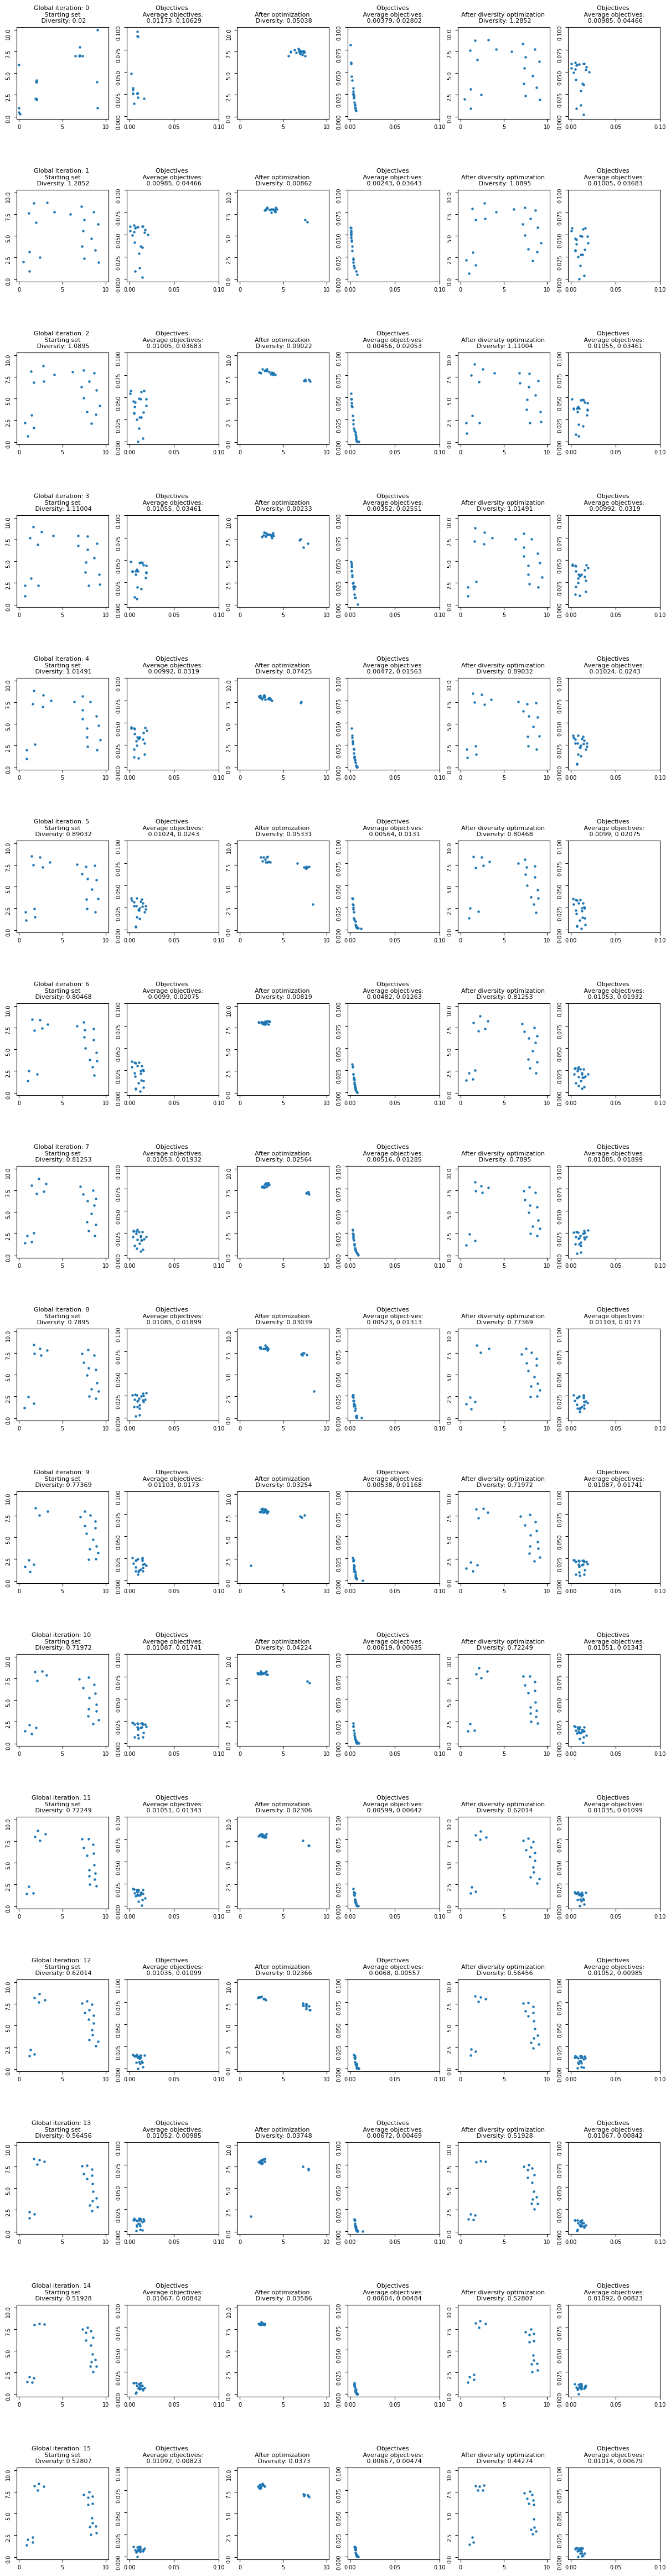

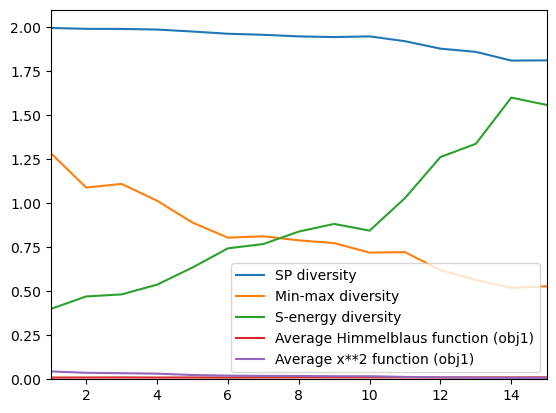

[[[2.740224295639772, 8.27626454737693],
  (8.458222229206783, 4.373164282443195),
  [7.377020751525875, 7.350771480008677],
  (1.7528235579370186, 8.20586806252437),
  [1.369239455996463, 2.2498473675184885],
  [7.672323887657777, 6.7304426859821564],
  (8.249917359139012, 7.174724952941998),
  (7.894347221001119, 6.190052174854474),
  [8.541628051839261, 3.4314011571248226],
  [8.721563002739796, 2.9655123464089517],
  [8.41978093221044, 6.545377583036139],
  [8.44294913581235, 6.019264990762702],
  [1.050306285908726, 1.4542435337486577],
  (2.564111988179058, 7.695888081069328),
  (7.999817332489892, 7.577358207312643),
  (1.4979508586309913, 1.7017296311962782),
  [2.033017573005581, 7.687054483912841],
  [2.185898405176128, 8.113864664810443],
  [8.320941062281939, 2.6558774274652595],
  (8.133477210014842, 3.1561416876673754)],
     SP diversity  Min-max diversity  S-energy diversity  \
 0       1.289199           0.020000          122.297488   
 1       1.996180           1.285

In [93]:
it = 1
max_gen = 5
pop_size = 20
b = [3, 3]
c = 3
global_bound = [0, 0]
r_number = 19
mutation_rate_div = 10
box_border = 10
max_global_iteration = 16
mutation_rate = 0.7
theta = 5
s = 2

random.seed(11)
NOAH_minmax(P_0, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border=10)

In [162]:
repeats = 50

random.seed(12)

# NOAH_minmax_repeats(P_0, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border)


Global_iteration:  0 b is  [3, 3]
OBJOPT [[0, 1], [0, 0.5], [2, 4], [2, 4.2], [1.97, 4], [1.9, 2.1], [6.9, 7], [9, 4], [7, 7], [7, 8], [7, 7.03], [9.05, 1], [6.5, 7], [2, 2.04], [7.3, 7], [9.03, 10], [2, 2], [0, 6], [0.1, 0.3], [2, 1.98]]
iteration 0
A[max_gen-1] [[-0.008166020092815387, -0.009211354419026407, -0.0037180541359442677, -0.007674009211378787, -0.0017853962726191324, -0.004837895135284681, -0.002215513913101793, -0.0053223352253439484, -0.0007033864655125641, -0.007833023114280135, -0.0024267253366718937, -0.0035859879521471724, -0.0052899999999999996, -0.004041789256707121, -0.004756667997547062, -0.0038776764193740377, -0.0015871907990019616, -0.006895612977522099, -0.0029204924198914326, -0.008522641569690499], [-0.0009085657425358462, -4.649312911210143e-05, -0.030788181779293, -0.002841654353570916, -0.05153881371718944, -0.01504811477835416, -0.043041115094948956, -0.012608970242230096, -0.05897675269584607, -0.0013719299733182834, -0.041108265059020495, -0.032586232

GENERATION 28
GENERATION 29
GENERATION 30
GENERATION 31
GENERATION 32
GENERATION 33
GENERATION 34
GENERATION 35
GENERATION 36
GENERATION 37
GENERATION 38
GENERATION 39
GENERATION 40
GENERATION 41
GENERATION 42
GENERATION 43
GENERATION 44
GENERATION 45
GENERATION 46
GENERATION 47
GENERATION 48
GENERATION 49
GENERATION 50
GENERATION 51
GENERATION 52
GENERATION 53
GENERATION 54
GENERATION 55
GENERATION 56
GENERATION 57
GENERATION 58
GENERATION 59
GENERATION 60
GENERATION 61
GENERATION 62
GENERATION 63
GENERATION 64
GENERATION 65
GENERATION 66
GENERATION 67
GENERATION 68
GENERATION 69
GENERATION 70
GENERATION 71
GENERATION 72
GENERATION 73
GENERATION 74
GENERATION 75
GENERATION 76
GENERATION 77
GENERATION 78
GENERATION 79
all energies [12114.931975602458, 2624.6518105197715, 1811.1657140970794, 1483.4704779697374, 1230.9832200419962, 1030.2809369336776, 816.8021555620537, 679.9859035796956, 568.9573097478464, 463.8560921670742, 421.57424221817524, 410.0364497114688, 361.33419354612766, 312

Global_iteration:  3 b is  [0.008113761809567403, 0.051147125999568874]
OBJOPT [[6.136120337246343, 7.674246042106308], [2.159051287164851, 8.209956200201994], (7.839314590467276, 7.485504741424039), (7.843878236954952, 8.343321351240773), [6.859995579524988, 6.384457366167888], (6.910000518678157, 8.169304278690841), [7.7387327979265725, 6.789290036647821], (3.0289493992307235, 7.013093765571622), (7.7987751643729375, 5.660161829729635), (2.224528027155192, 6.686716895485581), (3.290315429794434, 8.79275585425413), [7.417310328692888, 4.0290748729703765], [2.4691284362198744, 9.034035994164375], (2.2158795560902105, 2.700082486717376), [2.290615239974472, 1.7923529133566118], (3.9323541789127794, 8.295273973237627), [7.772682859584127, 3.260724500263826], (7.7998889382847185, 4.630665892475275), (7.741903726751897, 2.2896546870820313), [3.6423231034660852, 7.593900591761539]]
iteration 0
A[max_gen-1] [[-0.002970225866430868, -0.001436670885357752, -0.004764388399846526, -0.00309434581

objopt for global iteration  4  is ready
b before boundchange:  [0.007802193356080271, 0.04930071475098378]
b [0.007802193356080271, 0.04930071475098378]
b after boundchange:  [0.007488545183165691, 0.04760477016355045]
[[3.6765066135943054, 8.103945491983389], [6.684279102218147, 7.506691703826231], [3.6279671791854855, 7.890516824384942], [3.155145329529249, 8.054430519178478], [3.4153374850195695, 8.392836709729977], [2.656833718106467, 8.235735345608918], [2.33459030865015, 8.129421288628247], [2.4542521423221584, 8.071995043827322], [2.939021659498515, 8.205177815543886], [3.8082333044509618, 8.139090102779862], [3.737925115797566, 7.825910300978866], [6.735932417072867, 7.353639397608802], [2.4711574198030806, 7.852389448194192], [3.9195933608811746, 7.977799628192627], [7.2903965166535, 7.089255017929871], [3.2341129218733546, 7.905893552409511], [2.6667093864335745, 7.8642444647451075], [6.665581059781586, 7.591954284965594], [7.048625122319335, 7.48070667536574]]
 and size of 

GENERATION 34
GENERATION 35
GENERATION 36
GENERATION 37
GENERATION 38
GENERATION 39
GENERATION 40
GENERATION 41
GENERATION 42
GENERATION 43
GENERATION 44
GENERATION 45
GENERATION 46
GENERATION 47
GENERATION 48
GENERATION 49
GENERATION 50
GENERATION 51
all energies [9529.283996467424, 6253.849260780273, 5013.267943599207, 4531.667836308127, 3684.521444323106, 3025.5798541088006, 2328.7473066630055, 1889.2653370849541, 1499.3129641954563, 1284.813065310761, 1055.3333454587869, 885.1973712650681, 735.4497995182521, 622.5808783538267, 544.9573773385105, 453.39745226231855, 394.7823997765868, 339.9814735435942, 325.4484094213527, 314.7981189952964, 271.95551362834254, 252.46788390872837, 250.93763124086908, 226.48090216135287, 212.7351635872642, 208.02537392019173, 207.0626709451628, 206.1573481581735, 201.33928329396448, 201.2575331530698, 178.32536405920465, 177.11536555905724, 174.86407160625717, 173.59527016582436, 168.01182205707153, 167.30844564711225, 163.84808831360667, 163.84808831

Global_iteration:  7 b is  [0.007063213789270277, 0.044855159102957266]
OBJOPT [[3.7584590140637246, 8.216740921982645], [7.643368381989313, 6.823199278407965], (7.400537242726221, 5.567270480200118), [7.651365546938627, 5.022906154443796], (2.3479954436914405, 7.957322128755338), [6.7479582215693785, 6.751060581976697], (3.2307099143204674, 8.69718578155319), (2.41002861670558, 6.894761986479104), (6.986085567712649, 8.206488676192398), [3.6149752178281362, 7.7142916164768875], [3.0368429795286684, 7.171666735138029], (6.410183585524241, 7.74383405831378), [7.558370874588557, 2.7945389331631927], [7.61389570701501, 8.320536396493493], (2.3584672080547997, 8.98613779480373), (2.6613697071265645, 8.573818570887479), [7.622602845643204, 3.45049469778177], (7.447763017725803, 7.580756864088675), [7.103717440755464, 6.081088489511086], [7.51921320159904, 4.265014112259399]]
iteration 0
A[max_gen-1] [[-0.00421381551297436, -0.004235765467881436, -0.004054332793900635, -0.004770155119523504,

GENERATION 24
GENERATION 25
GENERATION 26
GENERATION 27
GENERATION 28
GENERATION 29
GENERATION 30
GENERATION 31
GENERATION 32
GENERATION 33
GENERATION 34
GENERATION 35
GENERATION 36
GENERATION 37
GENERATION 38
GENERATION 39
GENERATION 40
GENERATION 41
GENERATION 42
GENERATION 43
GENERATION 44
GENERATION 45
GENERATION 46
GENERATION 47
GENERATION 48
GENERATION 49
GENERATION 50
GENERATION 51
GENERATION 52
GENERATION 53
GENERATION 54
GENERATION 55
GENERATION 56
GENERATION 57
GENERATION 58
all energies [19528.814982728432, 13391.312269371245, 9078.1759870929, 6643.736778841672, 4504.070409355595, 3644.8613746507167, 2735.338014598314, 2179.536902525619, 1792.908808227671, 1412.033272910555, 1053.5356318320455, 857.6426553475685, 694.2857906713601, 570.1103626941552, 525.1157681162413, 489.867242831055, 450.14574574798206, 442.10015194134655, 425.8017174784553, 404.63099344044457, 402.9990382903378, 396.68064662529713, 358.47346911681257, 358.47346911681257, 358.47346911681257, 355.656726476

iteration 0
A[max_gen-1] [[-0.003827221582194847, -0.005289111203016632, -0.0025003313406426714, -0.0036363873850544354, -0.0018168968242549012, -0.002605961947984647, -0.0035123744941477726, -0.0053054669834880774, -0.002217473387472046, -0.0018058839256635095, -0.0021648202600734272, -0.0032170397980513525, -0.005915537819074684, -0.004302280555258351, -0.0021052918380613395, -0.0038874551665826966, -0.0024597542564260516, -0.0020886120159347285, -0.0028319196585849323, -0.00204302050775438], [-0.017041163061644906, -0.012088704367880697, -0.03023129659372882, -0.019673756222909233, -0.03852805746944067, -0.02904087368163652, -0.01994601500108295, -0.006816105233636553, -0.03555660834067432, -0.0389774872780486, -0.03578791657985085, -0.022648764739812206, -0.0047686515676082395, -0.015213645892006971, -0.03580145670441322, -0.01652826356177857, -0.032658300561220356, -0.03709615390369756, -0.02663568255960284, -0.03756970107833227]]
--- 0.03612685203552246 seconds ---
objopt for glo

GENERATION 29
GENERATION 30
GENERATION 31
GENERATION 32
GENERATION 33
GENERATION 34
GENERATION 35
GENERATION 36
GENERATION 37
GENERATION 38
GENERATION 39
all energies [28893.46728166175, 12476.977959764998, 8445.315556949352, 6361.775729135641, 4938.687092347861, 4278.034841917467, 3887.09170910638, 3424.281481020173, 2785.908079776662, 2405.528237513484, 1951.4572255959606, 1657.990843846508, 1496.406372994347, 1350.7538165609992, 1216.0550906749163, 1059.611434717505, 1047.5399150131639, 940.0390166783932, 878.5650978944916, 839.5741870901622, 765.4961938616331, 763.1118498173583, 707.502424935028, 666.3659736938216, 619.6612125157935, 619.6612125157935, 619.6612125157935, 599.3743459782971, 582.8703264387132, 576.2301760444212, 547.9208167723525, 547.9208167723525, 547.9208167723525, 544.1159163953781, 537.3797304815099, 509.61811110096716, 509.61811110096716, 491.29809545580355, 491.29809545580355, 491.29809545580355, 491.29809545580355] [[3.535021106186133, 8.226331530287498], [2.

objopt for global iteration  13  is ready
b before boundchange:  [0.005404465856664076, 0.03456873399495316]
b [0.005404465856664076, 0.03456873399495316]
b after boundchange:  [0.005336910033455791, 0.03417119355401095]
[[2.739001139923208, 8.096764412844054], [2.936671286456292, 8.098669651863789], [3.1493116933646172, 8.11091634336157], [2.7805215282694697, 7.944003892491715], [3.2484599174105036, 8.320835778314603], [3.159740892847488, 8.216485338415533], [3.498164066653271, 8.232353469212558], [2.7594785594365385, 8.022290869636453], [3.150750590183861, 8.193768828840435], [2.714685372921694, 8.237788379302614], [3.170761699931245, 8.186612560102153], [2.8741120800819804, 8.180600809566778], [3.3222356269822373, 7.910101452936798], [2.9878437025994207, 7.844573685600495], [3.243121581987199, 8.019877564584883], [3.4890434249960784, 7.88032257832882], [3.222826340966631, 8.096763458781517], [3.458733179911376, 7.837383131352863], [2.873560364425568, 8.072168953085503]]
 and size of

Global_iteration:  15 b is  [0.005222166467736552, 0.03341601017646773]
OBJOPT [[3.4567642027353953, 7.8721022131271345], [2.714685372921694, 8.237788379302614], [2.7805215282694697, 7.944003892491715], (3.0963086824460073, 8.538933322193454), [2.7741362788345385, 7.528641976527942], [6.916906593011405, 7.929308822303299], (6.962740735701251, 6.98287705351156), [3.0447476627353103, 7.447244358410634], (7.188440845843632, 8.077682739663171), [7.159792253385067, 6.62135454599982], (3.2174939744454223, 7.648960636574596), [2.7788533109354683, 7.226890938755705], (6.778840064210208, 7.351580709668749), (6.70484955994413, 7.720929781411508), (7.2666236938217335, 6.321886450959186), (7.267261910973472, 7.242325785880897), (3.3409578801631006, 8.26138489348103), [2.749460501074315, 8.777719581672248], (7.283731587049239, 6.953876412565999), [7.190746629365457, 7.57100458631774]]
iteration 0
A[max_gen-1] [[-0.004623485007579098, -0.004465387028501777, -0.0024724751035754547, -0.004885817063189

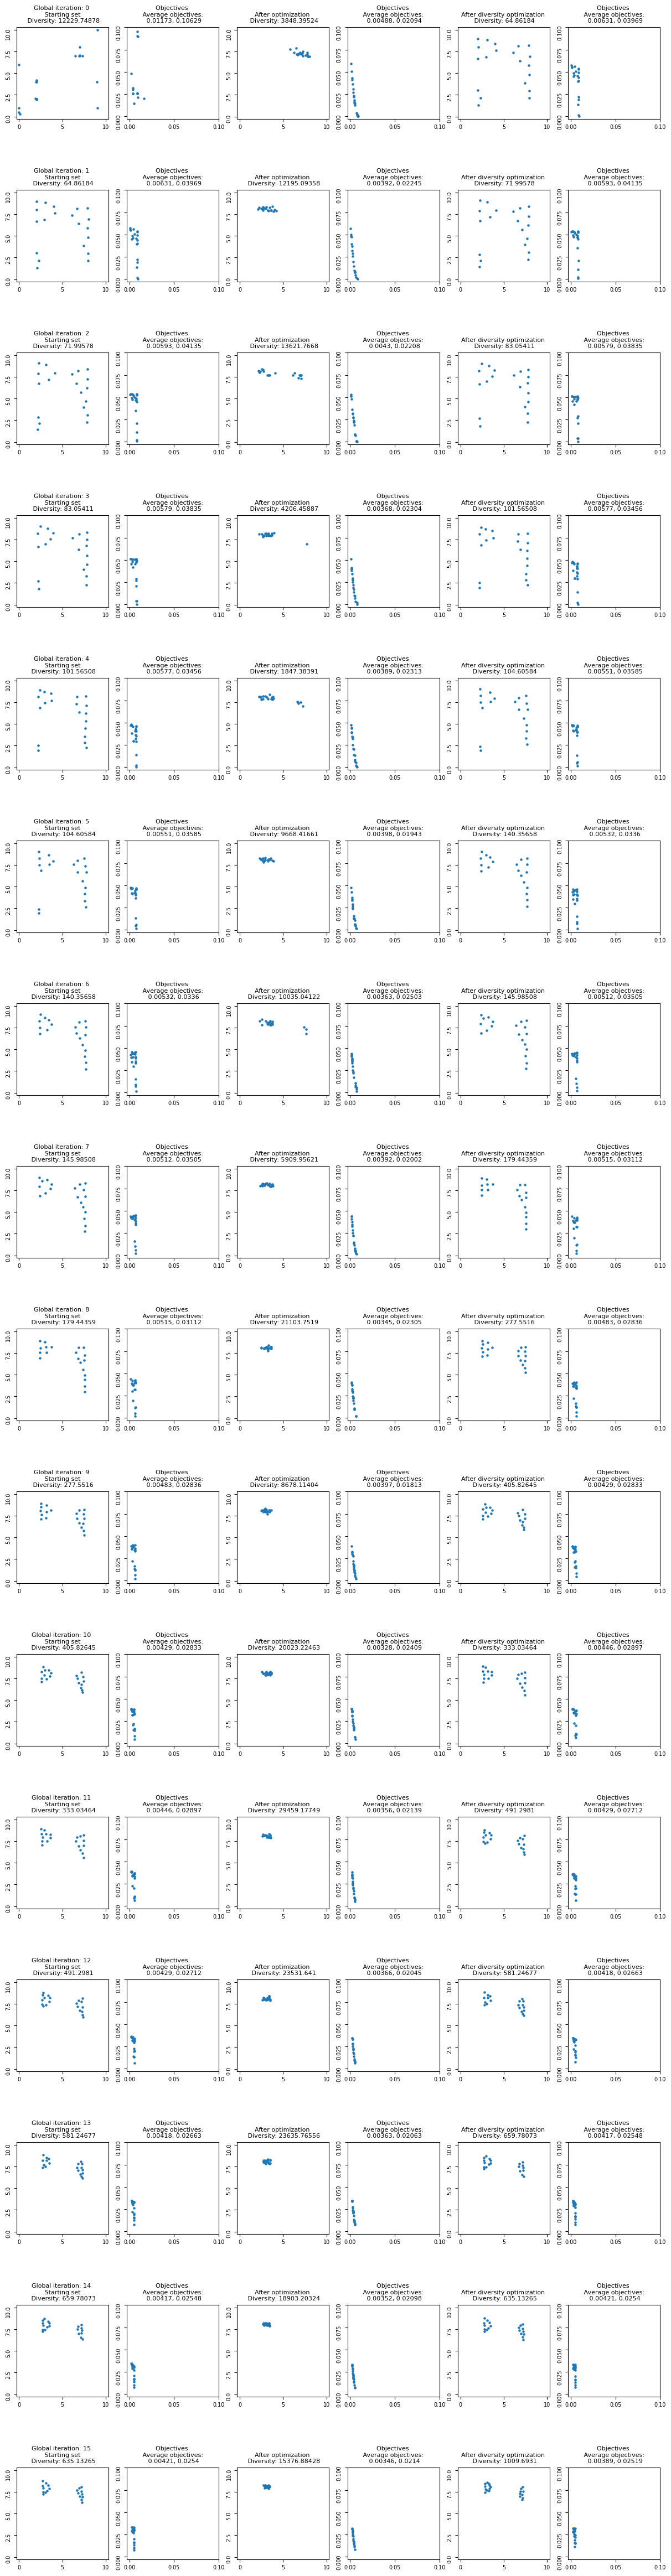

[[[2.8518810780026786, 8.17146044935456],
  [3.3357430064975704, 8.249895022665317],
  [3.4721470254665503, 8.089890868390238],
  [3.328946824666861, 7.896082808032407],
  (2.8330228558857775, 7.466182229769416),
  [7.219656803822366, 7.54940375139889],
  (2.8963661326778944, 7.80620916739948),
  [3.1061273871812505, 8.59125776485985],
  [6.831681591204527, 7.335038712828596],
  [6.893069917836936, 7.574509098096242],
  [6.973783301701221, 7.8869385457399295],
  (7.107564522831993, 7.207055293363185),
  [7.129782762511428, 6.609507239886705],
  (6.8841997560814026, 7.003020733840756),
  (3.259908066574578, 8.485984416761967),
  (7.179594124817295, 6.806961624170199),
  (7.2014288750851945, 8.08720988574149),
  [3.037899511204275, 7.674164480223014],
  (3.281155248829971, 7.660660046460663),
  [2.8162358576106725, 8.47107719953782]],
     SP diversity  Min-max diversity  S-energy diversity  \
 0       1.289199           0.020000           12.229749   
 1       1.971932           0.72045

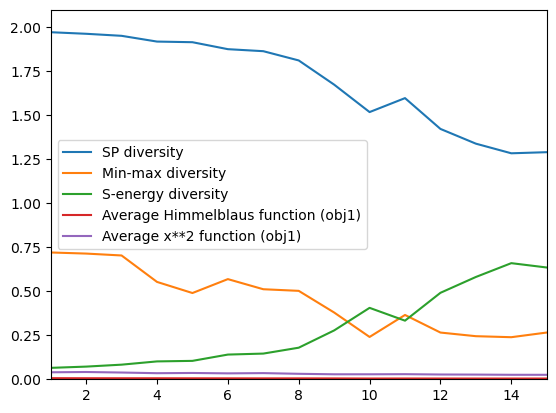

In [98]:
it = 1
max_gen = 5
pop_size = 20
b = [3, 3]
c = 3
global_bound = [0, 0]
r_number = 19
mutation_rate_div = 10
mutation_rate = 0.7
box_border = 10
max_global_iteration = 16
s = 2
theta = 5

random.seed(20)

NOAH_senergy(P_0, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, s)

In [176]:
repeats = 50

random.seed(14)


# NOAH_senergy_repeats(P_0, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, s)


In [155]:
it = 1
max_gen = 5
pop_size = 20
b = [3, 3]
mutation_rate = 0.7
c = 3
global_bound = [0, 0]
r_number = 19
mutation_rate_div = 10
box_border = 10
max_global_iteration = 16
theta = 1
s = 2

random.seed(15)

# NOAH_SP(P_0, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

In [157]:
repeats = 50

random.seed(16)

# 
# NOAH_SP_repeats(P_0, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

Global_iteration:  0 b is  [3, 3]
OBJOPT [[0, 1], [0, 0.5], [2, 4], [2, 4.2], [1.97, 4], [1.9, 2.1], [6.9, 7], [9, 4], [7, 7], [7, 8], [7, 7.03], [9.05, 1], [6.5, 7], [2, 2.04], [7.3, 7], [9.03, 10], [2, 2], [0, 6], [0.1, 0.3], [2, 1.98]]
iteration 0
A[max_gen-1] [[-0.0020405111969908174, -0.0037708506535054096, -0.001882627623644944, -0.004987734688670372, -0.007392767267281393, -0.003101153981570176, -0.006178943094230946, -0.0019591458342810377, -0.0016384283166638335, -0.0027692741801594012, -0.002965108261018944, -0.005619700245857962, -0.0011156042469266055, -0.003223410704262293, -0.0038330272314035, -0.00439394065445195, -0.0052720701167048925, -0.0032837037721681586, -0.003687392880730554, -0.007202559101837449], [-0.04191716089787235, -0.0264682689230083, -0.04374826164135492, -0.01504217563573021, -0.003364421786357126, -0.030246176507765378, -0.00708181345289689, -0.04283458806232402, -0.046771544805058574, -0.03785497145650548, -0.032653505238184576, -0.01009729870873567, 

Global_iteration:  2 b is  [0.046632719999549606, 0.039010349999552475]
OBJOPT [[3.6089104767284597, 8.277010813688223], [7.593009226394662, 7.527744416581127], [7.854345576307724, 6.778173469875476], [6.805572463984937, 7.253302696835668], [3.153328284443174, 8.435860394606593], [6.805656068267065, 7.686991427480631], [1.451562342259847, 7.5545595546540065], (7.627975902789987, 4.546899852448881), (8.847151592620666, 3.0575643614415506), [7.9692394946820375, 5.5090930298806935], [8.083359374836885, 5.077985605695666], (8.819950206198143, 6.907827502640728), [8.494160288521243, 2.2530696660544884], (8.119809052255633, 7.312569446817025), (3.1766511790011123, 7.401180445538075), (8.887859419711921, 4.053274871818782), [8.958118797657793, 5.642524837130883], [2.3109757737129177, 7.337220814743091], [2.57781787453807, 8.112239145948918], (8.061123866144516, 3.762892828550171)]
iteration 0
A[max_gen-1] [[-0.003178679667992031, -0.0031884586200001774, -0.005906677973964218, -0.0032382257008

GENERATION 45
GENERATION 46
GENERATION 47
[[3.360769532292886, 8.077174528826701], [1.4091125535699354, 1.9263527757242258], [8.779617756065328, 5.2935626976166015], (7.807183668723351, 7.754595153409237), [7.030992579601558, 7.293636769985642], (2.246801246457514, 8.646816130649121), (2.6533876242800436, 7.317069517593531), [1.753045283051235, 8.054463009351624], [8.02139127801194, 2.3966747070250305], (8.751786553694568, 4.604762622066226), (2.8253384528157, 8.403042059439596), [8.381910617912968, 2.940436808425658], (1.9637093912590706, 7.264348756692353), [8.057797832370968, 5.116663540835839], [9.119485072947104, 3.566532374515684], (8.312820770841814, 3.733221297223568), [7.75029978242517, 6.715798702718283], (7.6957810610191295, 5.858554144584804), (8.7222335785446, 6.284074074427844), [7.897231019623572, 4.537278566060697]]
all diversities [4.749963477974974, 5.7499742643682765, 6.642666752283981, 6.918066487044239, 7.915565071200126, 8.912653584541845, 9.838075502235714, 10.80

objopt for global iteration  5  is ready
b before boundchange:  [0.03173511190412458, 0.026276707680891208]
b [0.03173511190412458, 0.026276707680891208]
b after boundchange:  [0.026454389283279686, 0.02206980678118155]
[[2.895623447047683, 8.166893119544577], [2.2793763438140173, 8.203188854037684], [2.8756683247988493, 8.193913348487786], [2.9949552764821794, 8.127616539222112], [2.6045943636605604, 8.195768080906236], [2.362655445613683, 8.129395880122267], [3.04529234646719, 8.241652165340806], [2.7953328172016456, 8.168043566609846], [2.5404332105405985, 8.26070415006245], [2.4705637613476963, 7.995190160472123], [2.469461940255236, 8.228125121229724], [3.030802039285902, 7.96161720806463], [2.1531247885862475, 8.06747570756248], [2.460751256528631, 8.03169530040524], [2.660952541775642, 8.192468650294119], [3.018999322838694, 8.217024813327779], [3.127997687423667, 7.8540514278576365], [2.7274206938302403, 8.125223791722886], [3.0701790143710705, 8.20773630085072]]
 and size of P

Global_iteration:  7 b is  [0.02051008801132948, 0.017256381922202493]
OBJOPT [[7.892993052845205, 7.096703832894912], [2.897744014674877, 7.895257922662958], [8.567203302416997, 3.066698077889301], [2.813825119953854, 8.408623839124933], (7.417867271194444, 7.79259299412138), [8.012523793479986, 3.860757327934329], (8.332588990371624, 7.352976538676808), [2.262525039293359, 8.183459463116549], (8.949605444827736, 2.9466935533521976), (8.177602997650327, 4.800427439831832), [7.785549506246349, 6.419493998346148], (8.716574460523525, 2.5157389322012156), [8.16718430030695, 6.8296551668451775], [8.510545084282583, 3.861247505137724], (8.371014537267314, 5.44134295056907), [8.309201211096408, 5.957840337541174], (7.836905362838279, 7.824663610233994), (8.1236131363683, 2.588110289765959), [8.385634489679685, 6.342798805497248], [8.00965200287818, 5.4465937453322075]]
iteration 0
A[max_gen-1] [[-0.0045221921429925505, -0.0055889336943996445, -0.004423516081518617, -0.006802620829793534, -0

Global_iteration:  9 b is  [0.01272439296994806, 0.010754522341555403]
OBJOPT [[2.838358344773313, 8.092941739825301], [2.7413115907421437, 7.918828308910719], [8.067693706893799, 6.992302270267309], [8.567203302416997, 3.066698077889301], [2.6351074191071033, 8.408051139562186], [7.607127421867015, 7.142185735369024], [2.354034082759675, 8.305853400098902], [8.133464426375992, 3.494524224746667], (2.008524688085048, 8.446546758358966), [1.9932624957513807, 7.932099410228636], [7.381446295759175, 7.337111974604528], (2.0046548514027003, 7.694419106260749), [8.199528693139175, 5.993352330169516], [7.576763627168452, 7.604468747224499], (8.517693770737951, 4.314086178623612), (7.543086917702721, 6.718090711858277), [8.230990920439023, 6.336625505793191], [2.3578455788745583, 7.882588022494012], [7.931366249453168, 6.367895378842816], [8.442743366348298, 3.9646028360189356]]
iteration 0
A[max_gen-1] [[-0.006489062703475396, -0.00772158455697473, -0.009216922046375158, -0.00605221534666225

objopt for global iteration  10  is ready
b before boundchange:  [0.011953294755969276, 0.010089892860846958]
b [0.011953294755969276, 0.010089892860846958]
b after boundchange:  [0.010845224332091024, 0.009228216010531335]
[[2.5265234810403108, 8.106654738931034], [2.348011021008767, 8.078567203740542], [7.986248199170281, 6.9988308262312575], [2.554402381076623, 8.009999472187298], [2.62731739127875, 8.08676511852783], [2.668392717398908, 8.168367728528386], [2.538755182764732, 8.125268855539812], [2.6647232455798116, 8.177295587810995], [2.5628681256382704, 7.954016022190108], [2.370112678819538, 8.055610987120495], [2.7242408548565407, 8.20556945113692], [2.719215191642052, 8.206909684498516], [2.278314519504204, 8.054369480800053], [2.6552537233358144, 8.179805816972975], [2.5464894526343405, 8.121968826702235], [2.177793568416911, 8.124551577686914], [2.769964997763585, 8.225802413359974], [2.4630029250743806, 8.131589936727432], [2.3228779719707293, 8.053590452484805]]
 and size

Global_iteration:  12 b is  [0.010023156327718075, 0.008521334664124554]
OBJOPT [[2.762233166167485, 8.139356858048554], [2.341712216781505, 8.191777724449592], [2.4509641562219753, 8.179421154924501], (2.733511921290489, 8.022712663880553), [7.986248199170281, 6.9988308262312575], [2.192650147380946, 8.032096942389542], (2.3219093522506045, 7.8111873261743945), (2.515890630161483, 7.741932082008148), [7.6066833031074665, 7.590442444754134], [7.851808210519028, 7.652326133571618], (1.9431926786367186, 7.797243511059474), (7.76571510519388, 7.361079307338507), [2.1097723502585666, 8.23663502097057], (8.06910972741631, 7.169347831131134), (7.933369110411977, 7.354397047566888), [1.958532276476721, 7.706114949623355], [7.934886605791816, 6.5012153652916504], (7.7623968328284825, 6.648607919727915), [1.8610180074558267, 8.26999334573642], (7.906010596124643, 7.546103082584654)]
iteration 0
A[max_gen-1] [[-0.005196382804515115, -0.007910519229269867, -0.006637501956832373, -0.00713406361620

GENERATION 45
GENERATION 46
GENERATION 47
GENERATION 48
GENERATION 49
GENERATION 50
GENERATION 51
[(2.733511921290489, 8.022712663880553), [7.68162795678, 7.3435143429444745], (2.537203463505896, 8.405315461269144), [7.840726569676831, 7.127515238732639], (2.669508003464343, 8.201814072081376), (2.0891304983544536, 7.670184306255816), (8.025090435179852, 7.139471137664774), (1.975137614003799, 8.093644541657113), (2.204252065526972, 7.7301089761227555), (7.885509644693663, 6.33108052349866), [2.4815648454947006, 7.810292834504677], [8.042178276133894, 6.450255553736992], [7.9773076973886985, 6.231528398359244], (1.9157007809087725, 8.450482399876604), [7.97982166719062, 7.515736010938143], (1.9386454200471934, 7.859304301246933), [2.269384051191475, 8.17475943126824], [8.070072617643408, 6.6682293127196095], (7.683129663475627, 6.679599966743853), (2.2813302167544904, 8.481011684469273)]
all diversities [2.6206719346542817, 3.6525456890418395, 3.8198952798580112, 4.2882935275225496, 4.

objopt for global iteration  15  is ready
b before boundchange:  [0.009100762650060653, 0.007701647907197077]
b [0.009100762650060653, 0.007701647907197077]
b after boundchange:  [0.008426396137691012, 0.007075503932341801]
[[2.4310113817331063, 8.233283641483592], [2.279973416395886, 8.083793943474586], [2.632149138245416, 8.132079969387567], [2.70717196283481, 8.123310245080193], [2.564317102910718, 8.04090786011113], [2.3434643197025746, 8.120052258157546], [2.433969081544099, 8.229110720029883], [2.3904657781606877, 8.112404299578932], [2.2070735504017005, 8.110608771549325], [2.5417300480683496, 8.17717557930915], [2.4918742922677786, 8.181578025352925], [2.403793290799108, 8.084815705064406], [2.6361301392497807, 8.176753979456846], [2.5118792058834765, 8.158201368890962], [2.3802869005930396, 8.117774004622968], [2.41322977933229, 8.129230733207018], [2.425802106811263, 8.163158846893655], [2.308087177523807, 8.113284240616094], [2.5555758828357287, 8.046229440869311]]
 and size

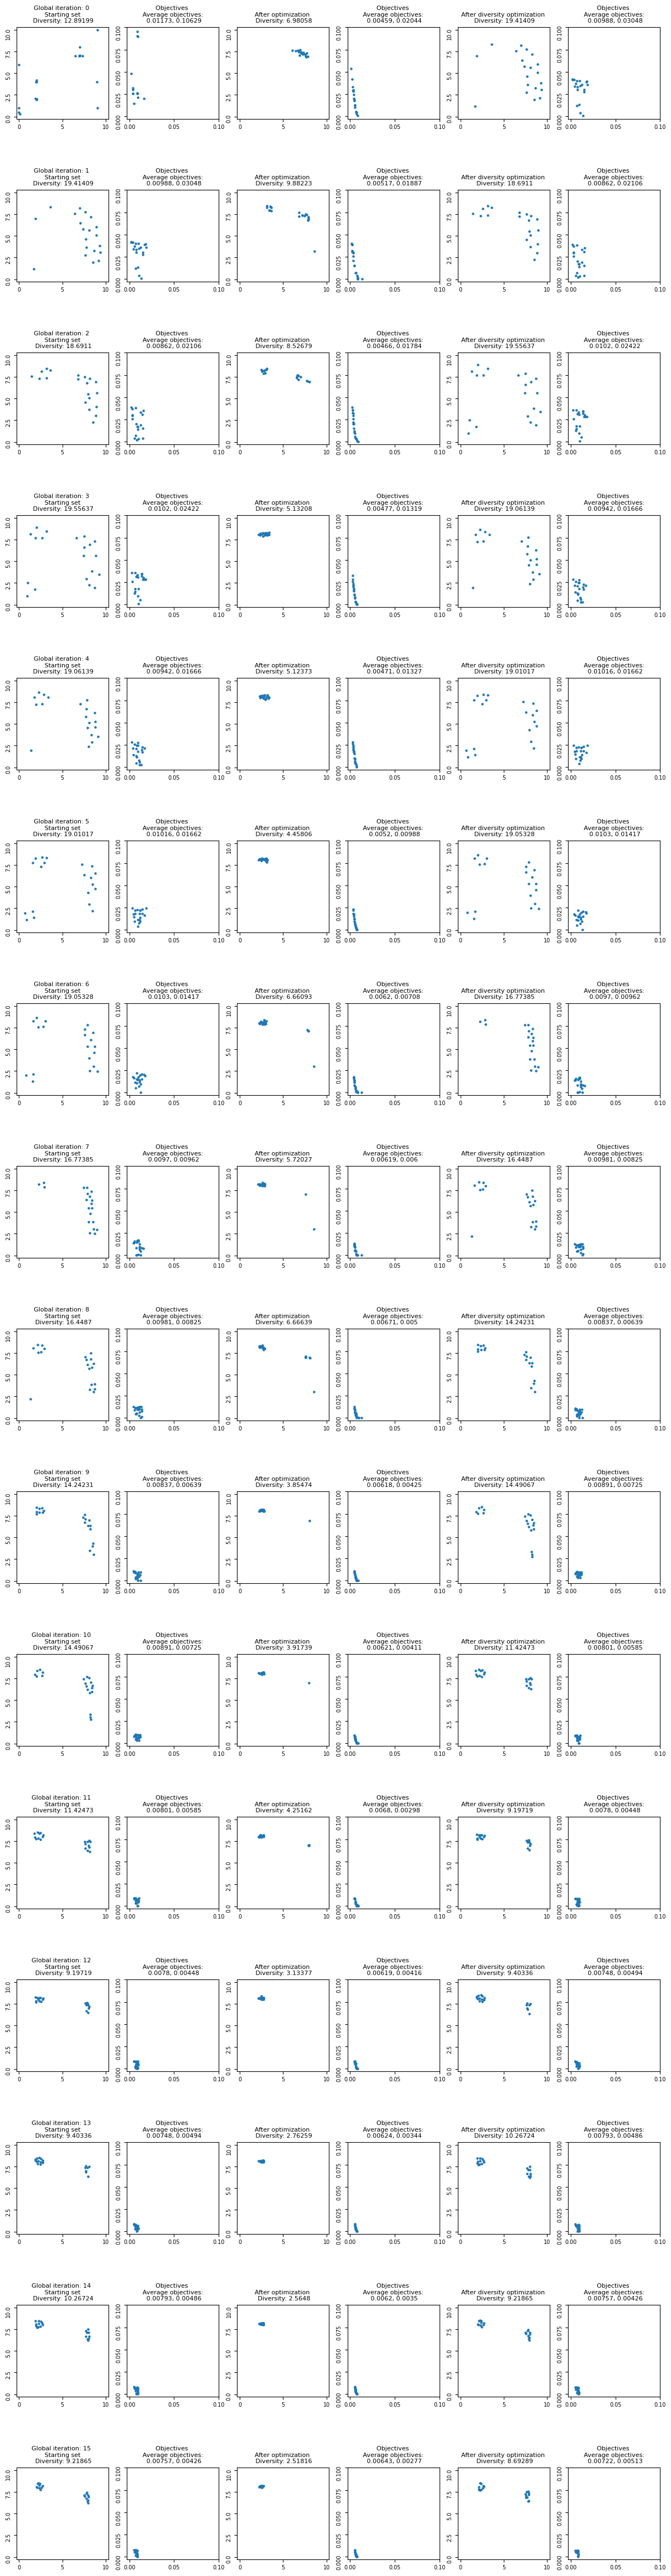

[[[2.70717196283481, 8.123310245080193],
  (2.1452517286984474, 7.842873723358807),
  (2.1568309394470546, 7.7346781257299755),
  (2.3735873777640313, 8.438074603162098),
  (7.637766522312711, 7.5044083618194),
  [7.495790487307261, 7.259318906912787],
  [7.691667701242253, 6.844563896993169],
  [2.5513273652954456, 7.93015505979159],
  (7.880545051492312, 7.17403575137881),
  [2.231624312000525, 8.510282046248413],
  (7.798335236226678, 7.586457466108957),
  [2.153134464596203, 8.085637211637643],
  [2.615906435306524, 8.214358596644155],
  [2.4001456896636113, 7.777859795116609],
  [7.856302523516758, 6.497300797677369],
  [7.585330881696198, 6.855158188863136],
  [7.576242224935269, 7.068777793795879],
  [7.902503244854905, 7.404202371346511],
  [7.828152505936615, 6.443102277569222],
  [2.291674971823377, 7.691586299237257]],
     SP diversity  Min-max diversity  S-energy diversity  \
 0       1.289199           0.020000            1.222975   
 1       1.941409           0.626128  

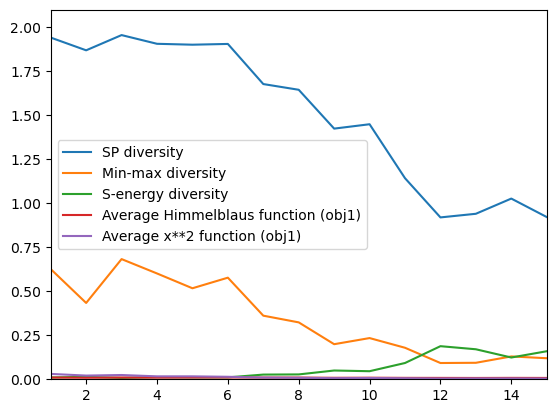

In [97]:
it = 1
max_gen = 5
pop_size = 20
b = [3, 3]
mutation_rate = 0.7
c = 3
global_bound = [0, 0]
r_number = 19
mutation_rate_div = 10
box_border = 10
max_global_iteration = 16
theta = 5
s = 2

random.seed(15)

NOAH_SP(P_0, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

In [70]:
repeats = 50

random.seed(16)


# NOAH_SP_repeats(P_0, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

In [71]:
it = 1
max_gen = 5
pop_size = 20
b = [3, 3]
c = 3
global_bound = [0, 0]
r_number = 19
mutation_rate = 0.7
mutation_rate_div = 10
box_border = 10
max_global_iteration = 16
theta = 5
s = 3

random.seed(15)

# NOAH_SP(P_0, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

In [75]:
repeats = 50

random.seed(16)

# NOAH_SP_repeats(P_0, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

In [79]:
it = 1
max_gen = 10
pop_size = 20
b = [3, 3]
mutation_rate = 0.7
c = 3
global_bound = [0, 0]
r_number = 19
mutation_rate_div = 10
box_border = 10
max_global_iteration = 16
theta = 1
s = 3

random.seed(15)

# NOAH_SP(P_0, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

In [81]:
repeats = 50

random.seed(16)


# NOAH_SP_repeats(P_0, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

In [82]:
it = 1
max_gen = 10
pop_size = 20
b = [3, 3]
mutation_rate = 0.7
c = 3
global_bound = [0, 0]
r_number = 19
mutation_rate_div = 10
box_border = 10
max_global_iteration = 16
theta = 3
s = 3

random.seed(15)

# NOAH_SP(P_0, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

In [84]:
repeats = 50

random.seed(16)


# NOAH_SP_repeats(P_0, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

In [76]:
it = 1
max_gen = 10
pop_size = 20
b = [3, 3]
c = 3
global_bound = [0, 0]
r_number = 19
mutation_rate = 0.7
mutation_rate_div = 10
box_border = 10
max_global_iteration = 16
theta = 5
s = 3

random.seed(15)

# NOAH_SP(P_0, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

In [78]:
repeats = 50

random.seed(16)

# NOAH_SP_repeats(P_0, repeats, it, max_global_iteration, max_gen, pop_size, global_bound, b, r_number, c, mutation_rate, mutation_rate_div, box_border, theta)

# Results for plots

In [50]:
SP_diversity_sp5t1 = [0.827946, 0.894669, 0.867436, 0.853449, 0.825766, 0.798052, 0.765285, 0.7662, 0.714289, 0.691949, 0.703693, 0.673135, 0.64414, 0.627574, 0.610752, 0.577751]
Min_max_diversity_sp5t1 = [0.02, 0.455351, 0.394811, 0.402896, 0.337384, 0.350491, 0.319665, 0.324075, 0.285367, 0.245339, 0.277485, 0.258619, 0.234443, 0.206631, 0.210188, 0.196807]
S_energy_diversity_sp5t1 = [44.586127, 0.013517, 0.028803, 0.021223, 0.102405, 0.084299, 0.155566, 0.04502, 1.346385, 1.992696, 0.413593, 0.252971, 0.87523, 0.248636, 0.832044, 0.668496]
Optimization_sp5t1 = [7.128928, 7.513717, 7.272574, 7.436208, 7.519713, 7.595396, 7.511392, 7.489417, 7.751083, 7.593754, 7.461159, 7.649855, 7.851952, 7.749631, 7.754202, 7.856791]
Diversity_Optimization_sp5t1 = [4.028556, 4.105137, 4.073749, 4.15711, 4.383941, 4.558195, 4.504846, 4.788322, 4.861559, 4.728026, 4.916912, 4.968511, 5.128731, 5.221385, 5.360201, 5.336582]

In [51]:
SP_diversity_sp5t3 = [1.143765, 1.711263, 1.697936, 1.64941, 1.623052, 1.599275, 1.569384, 1.515384, 1.451224, 1.421785, 1.346196, 1.289372, 1.249211, 1.190221, 1.15184, 1.11105]
Min_max_diversity_sp5t3 = [0.02, 0.57146, 0.61134, 0.530242, 0.487061, 0.501489, 0.481329, 0.436305, 0.398476, 0.391963, 0.333923, 0.317195, 0.293412, 0.264957, 0.253134, 0.243217]
S_energy_diversity_sp5t3 = [44.586127, 0.048778, 0.01557, 0.033947, 0.049993, 0.029061, 0.050208, 1.593926, 0.17919, 0.23348, 0.248343, 0.240176, 0.553477, 1.377019, 1.271459, 3.44056]
Optimization_sp5t3 = [7.126129, 7.526323, 7.547105, 7.663751, 7.598698, 7.651091, 7.544383, 7.705296, 7.704509, 7.745659, 7.643122, 7.919874, 7.940915, 7.929957, 7.938832, 7.936607]
Diversity_Optimization_sp5t3 = [4.368223, 4.379249, 4.292398, 4.342628, 4.483868, 4.583782, 4.670492, 4.857204, 4.882582, 5.035342, 5.198151, 5.237785, 5.390881, 5.485398, 5.622404, 5.56455]

In [52]:
SP_diversity_sp5t5 = [1.289199, 1.938398, 1.919761, 1.88849, 1.883625, 1.851633, 1.825086, 1.790456, 1.724009, 1.723001, 1.681564, 1.643595, 1.601806, 1.520449, 1.486533, 1.411538]
Min_max_diversity_sp5t5 = [0.02, 0.6534, 0.625388, 0.545855, 0.553463, 0.51983, 0.493157, 0.476336, 0.402142, 0.406913, 0.373325, 0.343621, 0.335944, 0.295665, 0.272264, 0.257059]
S_energy_diversity_sp5t5 = [44.586127, 0.009467, 0.012388, 0.016735, 0.017794, 0.026578, 0.029624, 0.039048, 0.068088, 0.071986, 0.077841, 0.151219, 0.162682, 0.200435, 0.284327, 0.548476]
Optimization_sp5t5 = [6.998954, 7.522206, 7.672666, 7.733568, 7.81731, 7.716275, 7.731648, 7.825558, 7.982074, 7.863616, 7.863031, 7.872661, 7.764749, 7.889546, 7.988529, 8.059184]
Diversity_Optimization_sp5t5 = [4.221989, 4.356454, 4.368354, 4.606096, 4.621211, 4.785098, 4.842656, 5.124889, 5.173239, 5.033169, 5.265757, 5.300172, 5.59555, 5.534795, 5.954914, 6.008957]

In [53]:
SP_diversity_sp10t1 = [0.827946, 0.917243, 0.86867, 0.836925, 0.807777, 0.796286, 0.73813, 0.744145, 0.717853, 0.678342, 0.672151, 0.641985, 0.594725, 0.564253, 0.531971, 0.501874]
Min_max_diversity_sp10t1 = [0.02, 0.491117, 0.423038, 0.404601, 0.340113, 0.343537, 0.282119, 0.29369, 0.311167, 0.268474, 0.246517, 0.231946, 0.194317, 0.180954, 0.175809, 0.15063]
S_energy_diversity_sp10t1 = [44.586127, 0.019408, 0.054554, 0.031026, 0.158708, 0.081603, 0.204546, 0.134623, 0.166679, 0.30307, 0.930425, 0.794353, 0.707529, 2.778543, 3.231869, 1.895481]
Optimization_sp10t1 = [7.579899, 7.791447, 7.817036, 8.003282, 8.003023, 7.956919, 8.072354, 8.139166, 8.196709, 8.175563, 8.263706, 8.274639, 8.318711, 8.399054, 8.417282, 8.467898]
Diversity_Optimization_sp10t1 = [3.893795, 4.243109, 4.415055, 4.361812, 4.457704, 4.722402, 4.567921, 4.730703, 4.942277, 4.947099, 5.062648, 5.373419, 5.516453, 5.686596, 5.971399, 6.141358]


In [54]:
SP_diversity_sp10t3 = [1.143765, 1.715022, 1.651671, 1.598064, 1.527274, 1.496082, 1.430569, 1.37014, 1.321176, 1.261494, 1.181294, 1.170502, 1.094741, 1.014238, 0.940746, 0.865973]
Min_max_diversity_sp10t3 = [0.02, 0.58154, 0.552984, 0.475511, 0.457146, 0.44551, 0.393945, 0.353775, 0.331957, 0.29314, 0.275113, 0.256536, 0.219732, 0.193311, 0.173048, 0.151687]
S_energy_diversity_sp10t3 = [44.586127, 0.011, 0.020234, 0.024438, 0.040947, 0.058875, 0.126347, 0.108691, 0.149397, 0.356252, 3.811322, 0.434826, 0.584238, 3.021569, 5.529288, 4.245652]
Optimization_sp10t3 = [7.503577, 7.877844, 7.903114, 8.053176, 7.985332, 8.150658, 8.143535, 8.225585, 8.235717, 8.195389, 8.294303, 8.368064, 8.364405, 8.296118, 8.455672, 8.457889]
Diversity_Optimization_sp10t3 = [4.394417, 4.492846, 4.555078, 4.676387, 4.862535, 5.0828, 5.080343, 5.2375, 5.361298, 5.523615, 5.505555, 5.71242, 5.861987, 6.154445, 6.394317, 6.544078]


In [55]:
SP_diversity_sp10t5 = [1.289199, 1.927432, 1.896705, 1.884303, 1.828136, 1.763698, 1.706608, 1.664759, 1.611397, 1.565367, 1.507457, 1.466256, 1.359178, 1.267272, 1.179423, 1.089477]
Min_max_diversity_sp10t5 = [0.02, 0.617341, 0.577449, 0.552979, 0.484319, 0.432277, 0.393826, 0.383804, 0.361133, 0.338804, 0.311547, 0.276095, 0.238986, 0.187577, 0.174254, 0.147008]
S_energy_diversity_sp10t5 = [44.586127, 0.010612, 0.017454, 0.016905, 0.029045, 0.049649, 0.101455, 0.095145, 0.232557, 0.259404, 0.437572, 0.581881, 0.865887, 1.298859, 24.380687, 3.913091]
Optimization_sp10t5 = [7.660128, 7.866724, 8.052744, 8.057015, 8.14856, 8.214376, 8.250162, 8.264824, 8.313255, 8.35786, 8.307351, 8.292727, 8.443417, 8.359729, 8.397949, 8.459415]
Diversity_Optimization_sp10t5 = [4.368516, 4.444201, 4.608151, 4.683444, 4.910408, 5.092588, 5.180989, 5.33218, 5.349438, 5.498276, 5.736422, 5.842756, 6.117446, 6.325706, 6.616862, 6.798582]


In [56]:
SP_diversity_mxmn5t1 = [0.827946, 1.012255, 0.980685, 0.948067, 0.914329, 0.891698, 0.870044, 0.841944, 0.813096, 0.785726, 0.764321, 0.724683, 0.699308, 0.661815, 0.632917, 0.600763]
Min_max_diversity_mxmn5t1 = [0.02, 1.064127, 1.009791, 0.960475, 0.912665, 0.875993, 0.83513, 0.807536, 0.761346, 0.731738, 0.687731, 0.632984, 0.597161, 0.551444, 0.504274, 0.466062]
S_energy_diversity_mxmn5t1 = [4458.612694, 0.34365, 0.401737, 0.5011, 0.602311, 0.725857, 0.827753, 1.076903, 1.50816, 2.020056, 2.341877, 3.344628, 4.866912, 7.130215, 12.12274, 16.364796]
Optimization_mxmn5t1 = [7.147449, 7.39274, 7.361452, 7.570524, 7.536045, 7.675254, 7.552975, 7.489, 7.643809, 7.608928, 7.820081, 7.630206, 7.716032, 7.911936, 7.999828, 7.596351]
Diversity_Optimization_mxmn5t1 = [3.582612, 3.641479, 3.696778, 3.833955, 3.913365, 3.954917, 4.080141, 4.195318, 4.309607, 4.340623, 4.503438, 4.646537, 4.876621, 5.01665, 5.215778, 5.326822]


In [57]:
SP_diversity_mxmn5t3 = [1.143765, 1.878491, 1.856358, 1.824731, 1.794155, 1.768278, 1.742407, 1.701523, 1.655441, 1.613975, 1.576516, 1.505471, 1.450685, 1.373231, 1.30129, 1.229313]
Min_max_diversity_mxmn5t3 = [0.02, 1.064127, 1.009791, 0.960475, 0.912665, 0.875993, 0.83513, 0.807536, 0.761346, 0.731738, 0.687731, 0.632984, 0.597161, 0.551444, 0.504274, 0.466062]
S_energy_diversity_mxmn5t3 = [4458.612694, 0.34365, 0.401737, 0.5011, 0.602311, 0.725857, 0.827753, 1.076903, 1.50816, 2.020056, 2.341877, 3.344628, 4.866912, 7.130215, 12.12274, 16.364796]
Optimization_mxmn5t3 = [7.147449, 7.39274, 7.361452, 7.570524, 7.536045, 7.675254, 7.552975, 7.489, 7.643809, 7.608928, 7.820081, 7.630206, 7.716032, 7.911936, 7.999828, 7.596351]
Diversity_Optimization_mxmn5t3 = [3.582612, 3.641479, 3.696778, 3.833955, 3.913365, 3.954917, 4.080141, 4.195318, 4.309607, 4.340623, 4.503438, 4.646537, 4.876621, 5.01665, 5.215778, 5.326822]


In [58]:
SP_diversity_mxmn5t5 = [1.289199, 1.986674, 1.98212, 1.973463, 1.964805, 1.955017, 1.946036, 1.926914, 1.900801, 1.877137, 1.85754, 1.812239, 1.767049, 1.7039, 1.635081, 1.566455]
Min_max_diversity_mxmn5t5 = [0.02, 1.064127, 1.009791, 0.960475, 0.912665, 0.875993, 0.83513, 0.807536, 0.761346, 0.731738, 0.687731, 0.632984, 0.597161, 0.551444, 0.504274, 0.466062]
S_energy_diversity_mxmn5t5 = [4458.612694, 0.34365, 0.401737, 0.5011, 0.602311, 0.725857, 0.827753, 1.076903, 1.50816, 2.020056, 2.341877, 3.344628, 4.866912, 7.130215, 12.12274, 16.364796]
Optimization_mxmn5t5 = [7.147449, 7.39274, 7.361452, 7.570524, 7.536045, 7.675254, 7.552975, 7.489, 7.643809, 7.608928, 7.820081, 7.630206, 7.716032, 7.911936, 7.999828, 7.596351]
Diversity_Optimization_mxmn5t5 = [3.582612, 3.641479, 3.696778, 3.833955, 3.913365, 3.954917, 4.080141, 4.195318, 4.309607, 4.340623, 4.503438, 4.646537, 4.876621, 5.01665, 5.215778, 5.326822]


In [59]:
SP_diversity_mxmn10t1 = [0.827946, 1.009393, 0.96072, 0.91726, 0.872558, 0.821837, 0.793816, 0.760795, 0.71757, 0.673512, 0.646451, 0.623768, 0.595221, 0.561424, 0.538147, 0.496486]
Min_max_diversity_mxmn10t1 = [0.02, 1.071297, 0.98906, 0.927381, 0.860887, 0.798831, 0.760155, 0.697626, 0.645129, 0.583994, 0.547796, 0.508086, 0.46739, 0.412514, 0.381676, 0.333298]
S_energy_diversity_mxmn10t1 = [4458.612694, 0.368283, 0.501803, 0.637951, 0.878587, 1.572072, 1.924303, 2.70753, 4.247306, 5.89944, 8.248875, 10.960976, 14.403977, 20.305693, 26.667048, 36.387964]
Optimization_mxmn10t1 = [7.33667, 7.933862, 7.9336, 7.943782, 8.087002, 8.117371, 8.093222, 8.013285, 8.221636, 8.354712, 8.343895, 8.261647, 8.310614, 8.423573, 8.412095, 8.476417]
Diversity_Optimization_mxmn10t1 = [3.534005, 3.731377, 3.84814, 4.075047, 4.30761, 4.3901, 4.462939, 4.708956, 4.926655, 4.99844, 5.111583, 5.226644, 5.432744, 5.54713, 5.884386, 6.101762]


In [60]:
SP_diversity_mxmn10t3 = [1.143765, 1.874181, 1.832405, 1.791627, 1.743039, 1.666946, 1.627472, 1.567167, 1.490604, 1.409719, 1.352628, 1.301532, 1.238252, 1.154808, 1.092746, 0.998247]
Min_max_diversity_mxmn10t3 = [0.02, 1.071297, 0.98906, 0.927381, 0.860887, 0.798831, 0.760155, 0.697626, 0.645129, 0.583994, 0.547796, 0.508086, 0.46739, 0.412514, 0.381676, 0.333298]
S_energy_diversity_mxmn10t3 = [4458.612694, 0.368283, 0.501803, 0.637951, 0.878587, 1.572072, 1.924303, 2.70753, 4.247306, 5.89944, 8.248875, 10.960976, 14.403977, 20.305693, 26.667048, 36.387964]
Optimization_mxmn10t3 = [7.33667, 7.933862, 7.9336, 7.943782, 8.087002, 8.117371, 8.093222, 8.013285, 8.221636, 8.354712, 8.343895, 8.261647, 8.310614, 8.423573, 8.412095, 8.476417]
Diversity_Optimization_mxmn10t3 = [3.534005, 3.731377, 3.84814, 4.075047, 4.30761, 4.3901, 4.462939, 4.708956, 4.926655, 4.99844, 5.111583, 5.226644, 5.432744, 5.54713, 5.884386, 6.101762]


In [61]:
SP_diversity_mxmn10t5 = [1.289199, 1.98457, 1.97338, 1.961531, 1.942612, 1.899274, 1.880144, 1.84239, 1.784702, 1.727518, 1.678105, 1.63557, 1.582821, 1.50348, 1.439918, 1.341895]
Min_max_diversity_mxmn10t5 = [0.02, 1.071297, 0.98906, 0.927381, 0.860887, 0.798831, 0.760155, 0.697626, 0.645129, 0.583994, 0.547796, 0.508086, 0.46739, 0.412514, 0.381676, 0.333298]
S_energy_diversity_mxmn10t5 = [4458.612694, 0.368283, 0.501803, 0.637951, 0.878587, 1.572072, 1.924303, 2.70753, 4.247306, 5.89944, 8.248875, 10.960976, 14.403977, 20.305693, 26.667048, 36.387964]
Optimization_mxmn10t5 = [7.33667, 7.933862, 7.9336, 7.943782, 8.087002, 8.117371, 8.093222, 8.013285, 8.221636, 8.354712, 8.343895, 8.261647, 8.310614, 8.423573, 8.412095, 8.476417]
Diversity_Optimization_mxmn10t5 = [3.534005, 3.731377, 3.84814, 4.075047, 4.30761, 4.3901, 4.462939, 4.708956, 4.926655, 4.99844, 5.111583, 5.226644, 5.432744, 5.54713, 5.884386, 6.101762]


In [62]:
SP_diversity_sen5t1 = [0.827946, 1.112734, 1.084178, 1.050957, 1.017529, 0.99516, 0.969499, 0.932586, 0.894077, 0.848098, 0.804772, 0.772584, 0.733533, 0.700571, 0.655247, 0.603631]
Min_max_diversity_sen5t1 = [0.02, 1.179653, 1.106703, 1.080694, 1.021992, 0.992158, 0.935924, 0.888475, 0.826611, 0.76489, 0.687158, 0.673137, 0.59515, 0.550442, 0.512359, 0.450847]
S_energy_diversity_sen5t1 = [445.861269, 0.022175, 0.025319, 0.031815, 0.040719, 0.045132, 0.060793, 0.083502, 0.111728, 0.177921, 0.267531, 0.374251, 0.490943, 0.584754, 0.813606, 1.269044]
Optimization_sen5t1 = [7.066386, 7.175701, 7.02146, 7.198933, 7.384228, 7.445311, 7.270749, 7.510778, 7.301137, 7.537199, 7.556314, 7.568644, 7.676347, 7.730722, 8.004552, 7.984493]
Diversity_Optimization_sen5t1 = [3.393179, 3.440108, 3.596642, 3.679572, 3.707216, 3.755194, 3.867299, 3.99117, 4.16048, 4.342721, 4.492078, 4.621098, 4.786738, 5.103232, 5.392898, 5.576103]


In [63]:
SP_diversity_sen5t3 = [1.143765, 1.931878, 1.918305, 1.897814, 1.871619, 1.857729, 1.833088, 1.792117, 1.750787, 1.685811, 1.617898, 1.56975, 1.497807, 1.439073, 1.353775, 1.246559]
Min_max_diversity_sen5t3 = [0.02, 1.179653, 1.106703, 1.080694, 1.021992, 0.992158, 0.935924, 0.888475, 0.826611, 0.76489, 0.687158, 0.673137, 0.59515, 0.550442, 0.512359, 0.450847]
S_energy_diversity_sen5t3 = [445.861269, 0.022175, 0.025319, 0.031815, 0.040719, 0.045132, 0.060793, 0.083502, 0.111728, 0.177921, 0.267531, 0.374251, 0.490943, 0.584754, 0.813606, 1.269044]
Optimization_sen5t3 = [7.066386, 7.175701, 7.02146, 7.198933, 7.384228, 7.445311, 7.270749, 7.510778, 7.301137, 7.537199, 7.556314, 7.568644, 7.676347, 7.730722, 8.004552, 7.984493]
Diversity_Optimization_sen5t3 = [3.393179, 3.440108, 3.596642, 3.679572, 3.707216, 3.755194, 3.867299, 3.99117, 4.16048, 4.342721, 4.492078, 4.621098, 4.786738, 5.103232, 5.392898, 5.576103]


In [64]:
SP_diversity_sen5t5 = [1.289199, 1.994478, 1.992393, 1.987404, 1.980458, 1.977029, 1.967421, 1.950758, 1.934288, 1.900758, 1.858858, 1.825568, 1.781817, 1.741296, 1.668827, 1.574668]
Min_max_diversity_sen5t5 = [0.02, 1.179653, 1.106703, 1.080694, 1.021992, 0.992158, 0.935924, 0.888475, 0.826611, 0.76489, 0.687158, 0.673137, 0.59515, 0.550442, 0.512359, 0.450847]
S_energy_diversity_sen5t5 = [445.861269, 0.022175, 0.025319, 0.031815, 0.040719, 0.045132, 0.060793, 0.083502, 0.111728, 0.177921, 0.267531, 0.374251, 0.490943, 0.584754, 0.813606, 1.269044]
Optimization_sen5t5 = [7.066386, 7.175701, 7.02146, 7.198933, 7.384228, 7.445311, 7.270749, 7.510778, 7.301137, 7.537199, 7.556314, 7.568644, 7.676347, 7.730722, 8.004552, 7.984493]
Diversity_Optimization_sen5t5 = [3.393179, 3.440108, 3.596642, 3.679572, 3.707216, 3.755194, 3.867299, 3.99117, 4.16048, 4.342721, 4.492078, 4.621098, 4.786738, 5.103232, 5.392898, 5.576103]


In [65]:
SP_diversity_sen10t1 = [0.827946, 1.107947, 1.060405, 1.020592, 0.983874, 0.943817, 0.905014, 0.863261, 0.81505, 0.771778, 0.726268, 0.685261, 0.659336, 0.617828, 0.566322, 0.518882]
Min_max_diversity_sen10t1 = [0.02, 1.166411, 1.093956, 1.021231, 0.973845, 0.904051, 0.869013, 0.788692, 0.735638, 0.651157, 0.58258, 0.545003, 0.498543, 0.455591, 0.381061, 0.335119]
S_energy_diversity_sen10t1 = [445.861269, 0.022672, 0.028795, 0.036788, 0.043719, 0.06339, 0.087365, 0.128745, 0.202213, 0.341477, 0.62493, 1.220075, 1.666877, 2.503627, 3.550711, 5.763334]
Optimization_sen10t1 = [7.576148, 7.823747, 7.820068, 7.863067, 7.981025, 8.044494, 7.962015, 8.042141, 8.073263, 8.23614, 8.30746, 8.297856, 8.304672, 8.425752, 8.408741, 8.3374]
Diversity_Optimization_sen10t1 = [3.375593, 3.494063, 3.665636, 3.787994, 3.969399, 4.051734, 4.147413, 4.306199, 4.476877, 4.627192, 4.807186, 4.916515, 5.178023, 5.452466, 5.818774, 5.941919]


In [66]:
SP_diversity_sen10t3 = [1.143765, 1.930114, 1.905657, 1.878511, 1.853638, 1.812023, 1.769399, 1.712552, 1.649555, 1.576872, 1.494262, 1.415107, 1.355693, 1.274967, 1.155236, 1.042744]
Min_max_diversity_sen10t3 = [0.02, 1.166411, 1.093956, 1.021231, 0.973845, 0.904051, 0.869013, 0.788692, 0.735638, 0.651157, 0.58258, 0.545003, 0.498543, 0.455591, 0.381061, 0.335119]
S_energy_diversity_sen10t3 = [445.861269, 0.022672, 0.028795, 0.036788, 0.043719, 0.06339, 0.087365, 0.128745, 0.202213, 0.341477, 0.62493, 1.220075, 1.666877, 2.503627, 3.550711, 5.763334]
Optimization_sen10t3 = [7.576148, 7.823747, 7.820068, 7.863067, 7.981025, 8.044494, 7.962015, 8.042141, 8.073263, 8.23614, 8.30746, 8.297856, 8.304672, 8.425752, 8.408741, 8.3374]
Diversity_Optimization_sen10t3 = [3.375593, 3.494063, 3.665636, 3.787994, 3.969399, 4.051734, 4.147413, 4.306199, 4.476877, 4.627192, 4.807186, 4.916515, 5.178023, 5.452466, 5.818774, 5.941919]


In [67]:
SP_diversity_sen10t5 = [1.289199, 1.994152, 1.989958, 1.983714, 1.978357, 1.962532, 1.944563, 1.916554, 1.882378, 1.835215, 1.774055, 1.711882, 1.657412, 1.594719, 1.484605, 1.356938]
Min_max_diversity_sen10t5 = [0.02, 1.166411, 1.093956, 1.021231, 0.973845, 0.904051, 0.869013, 0.788692, 0.735638, 0.651157, 0.58258, 0.545003, 0.498543, 0.455591, 0.381061, 0.335119]
S_energy_diversity_sen10t5 = [445.861269, 0.022672, 0.028795, 0.036788, 0.043719, 0.06339, 0.087365, 0.128745, 0.202213, 0.341477, 0.62493, 1.220075, 1.666877, 2.503627, 3.550711, 5.763334]
Optimization_sen10t5 = [7.576148, 7.823747, 7.820068, 7.863067, 7.981025, 8.044494, 7.962015, 8.042141, 8.073263, 8.23614, 8.30746, 8.297856, 8.304672, 8.425752, 8.408741, 8.3374]
Diversity_Optimization_sen10t5 = [3.375593, 3.494063, 3.665636, 3.787994, 3.969399, 4.051734, 4.147413, 4.306199, 4.476877, 4.627192, 4.807186, 4.916515, 5.178023, 5.452466, 5.818774, 5.941919]


In [68]:
SP_diversity_mxmn5t1s2 = [0.827946, 1.012255, 0.980685, 0.948067, 0.914329, 0.891698, 0.870044, 0.841944, 0.813096, 0.785726, 0.764321, 0.724683, 0.699308, 0.661815, 0.632917, 0.600763]
Min_max_diversity_mxmn5t1s2 = [0.020000, 1.064127, 1.009791, 0.960475, 0.912665, 0.875993, 0.835130, 0.807536, 0.761346, 0.731738, 0.687731, 0.632984, 0.597161, 0.551444, 0.504274, 0.466062]
S_energy_diversity_mxmn5t1s2 = [122.297488, 0.521083, 0.571845, 0.645392, 0.718027, 0.795117, 0.858402, 0.996692, 1.196636, 1.400375, 1.534904, 1.923127, 2.391072, 3.062893, 4.203074, 5.191774]
Optimization_mxmn5t1s2 = [7.147449, 7.392740, 7.361452, 7.570524, 7.536045, 7.675254, 7.552975, 7.489000, 7.643809, 7.608928, 7.820081, 7.630206, 7.716032, 7.911936, 7.999828, 7.596351]
Diversity_Optimization_mxmn5t1s2 = [3.582612, 3.641479, 3.696778, 3.833955, 3.913365, 3.954917, 4.080141, 4.195318, 4.309607, 4.340623, 4.503438, 4.646537, 4.876621, 5.016650, 5.215778, 5.326822]


In [69]:
SP_diversity_mxmn5t3s2 = [1.143765, 1.878491, 1.856358, 1.824731, 1.794155, 1.768278, 1.742407, 1.701523, 1.655441, 1.613975, 1.576516, 1.505471, 1.450685, 1.373231, 1.301290, 1.229313]
Min_max_diversity_mxmn5t3s2 = [0.020000, 1.064127, 1.009791, 0.960475, 0.912665, 0.875993, 0.835130, 0.807536, 0.761346, 0.731738, 0.687731, 0.632984, 0.597161, 0.551444, 0.504274, 0.466062]
S_energy_diversity_mxmn5t3s2 = [122.297488, 0.521083, 0.571845, 0.645392, 0.718027, 0.795117, 0.858402, 0.996692, 1.196636, 1.400375, 1.534904, 1.923127, 2.391072, 3.062893, 4.203074, 5.191774]
Optimization_mxmn5t3s2 = [7.147449, 7.392740, 7.361452, 7.570524, 7.536045, 7.675254, 7.552975, 7.489000, 7.643809, 7.608928, 7.820081, 7.630206, 7.716032, 7.911936, 7.999828, 7.596351]
Diversity_Optimization_mxmn5t3s2 = [3.582612, 3.641479, 3.696778, 3.833955, 3.913365, 3.954917, 4.080141, 4.195318, 4.309607, 4.340623, 4.503438, 4.646537, 4.876621, 5.016650, 5.215778, 5.326822]


In [70]:
SP_diversity_mxmn5t5s2 = [1.289199, 1.986674, 1.98212, 1.973463, 1.964805, 1.955017, 1.946036, 1.926914, 1.900801, 1.877137, 1.85754, 1.812239, 1.767049, 1.7039, 1.635081, 1.566455]
Min_max_diversity_mxmn5t5s2 = [0.02, 1.064127, 1.009791, 0.960475, 0.912665, 0.875993, 0.83513, 0.807536, 0.761346, 0.731738, 0.687731, 0.632984, 0.597161, 0.551444, 0.504274, 0.466062]
S_energy_diversity_mxmn5t5s2 = [122.297488, 0.521083, 0.571845, 0.645392, 0.718027, 0.795117, 0.858402, 0.996692, 1.196636, 1.400375, 1.534904, 1.923127, 2.391072, 3.062893, 4.203074, 5.191774]
Optimization_mxmn5t5s2 = [7.147449, 7.39274, 7.361452, 7.570524, 7.536045, 7.675254, 7.552975, 7.489, 7.643809, 7.608928, 7.820081, 7.630206, 7.716032, 7.911936, 7.999828, 7.596351]
Diversity_Optimization_mxmn5t5s2 = [3.582612, 3.641479, 3.696778, 3.833955, 3.913365, 3.954917, 4.080141, 4.195318, 4.309607, 4.340623, 4.503438, 4.646537, 4.876621, 5.01665, 5.215778, 5.326822]


In [71]:
SP_diversity_sen5t1s2 = [0.827946, 1.114120, 1.076265, 1.053943, 1.021472, 0.994209, 0.965194, 0.936943, 0.904612, 0.872281, 0.838149, 0.800270, 0.763423, 0.725191, 0.687940, 0.640588]
Min_max_diversity_sen5t1s2 = [0.020000, 1.100557, 1.043149, 1.016040, 0.955120, 0.919114, 0.876329, 0.839027, 0.795078, 0.748062, 0.713395, 0.646246, 0.601201, 0.575509, 0.521268, 0.468241]
S_energy_diversity_sen5t1s2 = [12.229749, 0.041698, 0.045804, 0.049521, 0.055850, 0.064736, 0.074058, 0.080465, 0.094321, 0.107452, 0.122797, 0.155122, 0.201335, 0.271665, 0.327882, 0.427618]
Optimization_sen5t1s2 = [7.044071, 7.150395, 7.034607, 7.058917, 7.225891, 7.159459, 7.283508, 7.191960, 7.545981, 7.352926, 7.453397, 7.541896, 7.784052, 7.687634, 7.926555, 7.887275]
Diversity_Optimization_sen5t1s2 = [3.434060, 3.494905, 3.617881, 3.703402, 3.749681, 3.816462, 3.925718, 4.014931, 4.078699, 4.238772, 4.410576, 4.588328, 4.738611, 4.922009, 5.194558, 5.293635]

In [72]:
SP_diversity_sen5t3s2 = [1.143765, 1.921560, 1.903960, 1.889148, 1.864391, 1.838071, 1.812377, 1.785429, 1.750734, 1.712678, 1.672457, 1.614276, 1.547140, 1.481025, 1.415242, 1.329879]
Min_max_diversity_sen5t3s2 = [0.020000, 1.100557, 1.043149, 1.016040, 0.955120, 0.919114, 0.876329, 0.839027, 0.795078, 0.748062, 0.713395, 0.646246, 0.601201, 0.575509, 0.521268, 0.468241]
S_energy_diversity_sen5t3s2 = [12.229749, 0.041698, 0.045804, 0.049521, 0.055850, 0.064736, 0.074058, 0.080465, 0.094321, 0.107452, 0.122797, 0.155122, 0.201335, 0.271665, 0.327882, 0.427618]
Optimization_sen5t3s2 = [7.044071, 7.150395, 7.034607, 7.058917, 7.225891, 7.159459, 7.283508, 7.191960, 7.545981, 7.352926, 7.453397, 7.541896, 7.784052, 7.687634, 7.926555, 7.887275]
Diversity_Optimization_sen5t3s2 = [3.434060, 3.494905, 3.617881, 3.703402, 3.749681, 3.816462, 3.925718, 4.014931, 4.078699, 4.238772, 4.410576, 4.588328, 4.738611, 4.922009, 5.194558, 5.293635]

In [73]:
SP_diversity_sen5t5s2 = [1.289199, 1.991127, 1.988195, 1.983800, 1.976653, 1.965953, 1.954847, 1.945895, 1.929680, 1.913104, 1.893976, 1.857169, 1.808075, 1.754706, 1.705654, 1.637552]
Min_max_diversity_sen5t5s2 = [0.020000, 1.100557, 1.043149, 1.016040, 0.955120, 0.919114, 0.876329, 0.839027, 0.795078, 0.748062, 0.713395, 0.646246, 0.601201, 0.575509, 0.521268, 0.468241]
S_energy_diversity_sen5t5s2 = [12.229749, 0.041698, 0.045804, 0.049521, 0.055850, 0.064736, 0.074058, 0.080465, 0.094321, 0.107452, 0.122797, 0.155122, 0.201335, 0.271665, 0.327882, 0.427618]
Optimization_sen5t5s2 = [7.044071, 7.150395, 7.034607, 7.058917, 7.225891, 7.159459, 7.283508, 7.191960, 7.545981, 7.352926, 7.453397, 7.541896, 7.784052, 7.687634, 7.926555, 7.887275]
Diversity_Optimization_sen5t5s2 = [3.434060, 3.494905, 3.617881, 3.703402, 3.749681, 3.816462, 3.925718, 4.014931, 4.078699, 4.238772, 4.410576, 4.588328, 4.738611, 4.922009, 5.194558, 5.293635]

In [74]:
SP_diversity_sp5t1s2 = [0.827946, 0.894669, 0.867436, 0.853449, 0.825766, 0.798052, 0.765285, 0.766200, 0.714289, 0.691949, 0.703693, 0.673135, 0.644140, 0.627574, 0.610752, 0.577751]
Min_max_diversity_sp5t1s2 = [0.020000, 0.455351, 0.394811, 0.402896, 0.337384, 0.350491, 0.319665, 0.324075, 0.285367, 0.245339, 0.277485, 0.258619, 0.234443, 0.206631, 0.210188, 0.196807]
S_energy_diversity_sp5t1s2 = [1.222975, 0.009313, 0.011537, 0.011525, 0.018967, 0.017926, 0.030689, 0.018643, 0.061989, 0.085764, 0.043339, 0.048648, 0.077969, 0.050831, 0.077331, 0.092384]
Optimization_sp5t1s2 = [7.128928, 7.513717, 7.272574, 7.436208, 7.519713, 7.595396, 7.511392, 7.489417, 7.751083, 7.593754, 7.461159, 7.649855, 7.851952, 7.749631, 7.754202, 7.856791]
Diversity_Optimization_sp5t1s2 = [4.028556, 4.105137, 4.073749, 4.157110, 4.383941, 4.558195, 4.504846, 4.788322, 4.861559, 4.728026, 4.916912, 4.968511, 5.128731, 5.221385, 5.360201, 5.336582]


In [75]:
SP_diversity_sp5t3s2 = [1.143765, 1.711263, 1.697936, 1.649410, 1.623052, 1.599275, 1.569384, 1.515384, 1.451224, 1.421785, 1.346196, 1.289372, 1.249211, 1.190221, 1.151840, 1.111050]
Min_max_diversity_sp5t3s2 = [0.020000, 0.571460, 0.611340, 0.530242, 0.487061, 0.501489, 0.481329, 0.436305, 0.398476, 0.391963, 0.333923, 0.317195, 0.293412, 0.264957, 0.253134, 0.243217]
S_energy_diversity_sp5t3s2 = [1.222975, 0.012594, 0.011075, 0.014912, 0.016599, 0.015522, 0.019431, 0.044335, 0.030659, 0.032942, 0.042615, 0.047710, 0.071314, 0.110640, 0.094614, 0.136641]
Optimization_sp5t3s2 = [7.126129, 7.526323, 7.547105, 7.663751, 7.598698, 7.651091, 7.544383, 7.705296, 7.704509, 7.745659, 7.643122, 7.919874, 7.940915, 7.929957, 7.938832, 7.936607]
Diversity_Optimization_sp5t3s2 = [4.368223, 4.379249, 4.292398, 4.342628, 4.483868, 4.583782, 4.670492, 4.857204, 4.882582, 5.035342, 5.198151, 5.237785, 5.390881, 5.485398, 5.622404, 5.564550]


In [76]:
SP_diversity_sp5t5s2 = [1.289199, 1.938398, 1.919761, 1.888490, 1.883625, 1.851633, 1.825086, 1.790456, 1.724009, 1.723001, 1.681564, 1.643595, 1.601806, 1.520449, 1.486533, 1.411538]
Min_max_diversity_sp5t5s2 = [0.020000, 0.653400, 0.625388, 0.545855, 0.553463, 0.519830, 0.493157, 0.476336, 0.402142, 0.406913, 0.373325, 0.343621, 0.335944, 0.295665, 0.272264, 0.257059]
S_energy_diversity_sp5t5s2 = [1.222975, 0.009498, 0.010770, 0.012821, 0.013454, 0.016221, 0.017786, 0.020765, 0.028272, 0.029104, 0.031560, 0.040474, 0.045318, 0.055651, 0.065764, 0.090075]
Optimization_sp5t5s2 = [6.998954, 7.522206, 7.672666, 7.733568, 7.817310, 7.716275, 7.731648, 7.825558, 7.982074, 7.863616, 7.863031, 7.872661, 7.764749, 7.889546, 7.988529, 8.059184]
Diversity_Optimization_sp5t5s2 = [4.221989, 4.356454, 4.368354, 4.606096, 4.621211, 4.785098, 4.842656, 5.124889, 5.173239, 5.033169, 5.265757, 5.300172, 5.595550, 5.534795, 5.954914, 6.008957]


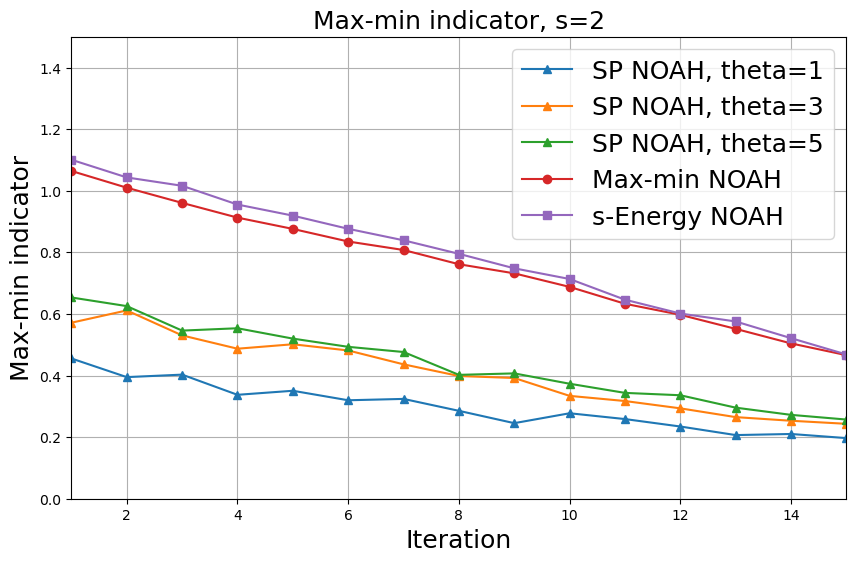

In [92]:
plt.figure(figsize=(10, 6))

plt.plot(Min_max_diversity_sp5t1s2, label='SP NOAH, theta=1', marker='^')
plt.plot(Min_max_diversity_sp5t3s2, label='SP NOAH, theta=3', marker='^')
plt.plot(Min_max_diversity_sp5t5s2, label='SP NOAH, theta=5', marker='^')
plt.plot(Min_max_diversity_mxmn5t5s2, label='Max-min NOAH', marker='o')
plt.plot(Min_max_diversity_sen5t5s2, label='s-Energy NOAH', marker='s')

# Adding titles and labels
plt.title('Max-min indicator, s=2', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Max-min indicator', fontsize=18)
plt.xlim((1, 15))
plt.ylim((0, 1.5))
plt.legend(prop = { "size": 18 }, loc ="upper right")
plt.grid(True)
plt.savefig('Maxmin5s2.png')

# Show the plot
plt.show()

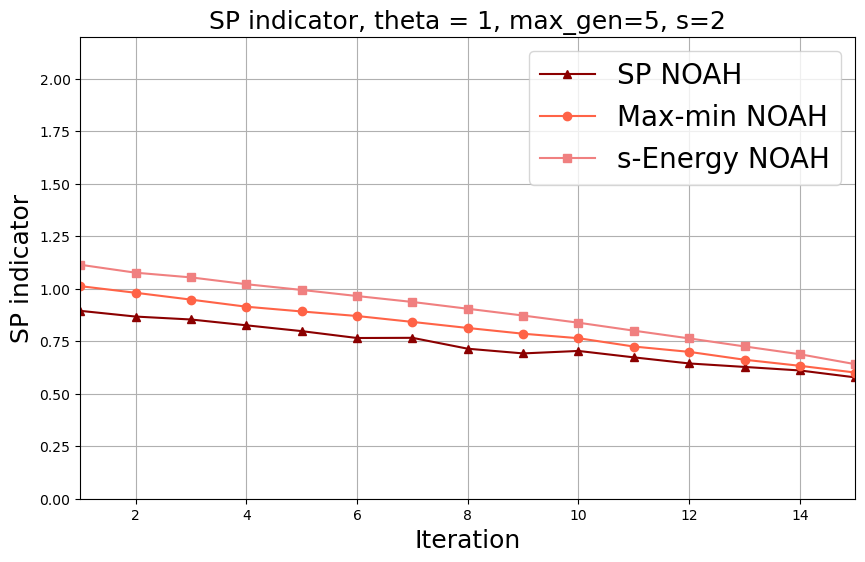

In [78]:
plt.figure(figsize=(10, 6))

plt.plot(SP_diversity_sp5t1s2, 'darkred', label='SP NOAH', marker='^')
plt.plot(SP_diversity_mxmn5t1s2, 'tomato', label='Max-min NOAH', marker='o')
plt.plot(SP_diversity_sen5t1s2, 'lightcoral', label='s-Energy NOAH', marker='s')


# Adding titles and labels
plt.title('SP indicator, theta = 1, max_gen=5, s=2', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('SP indicator', fontsize=18)
plt.xlim((1, 15))
plt.ylim((0, 2.2))
plt.legend(prop = { "size": 20 }, loc ="upper right")
plt.grid(True)
plt.savefig('SP5s2t1.png')

# Show the plot
plt.show()

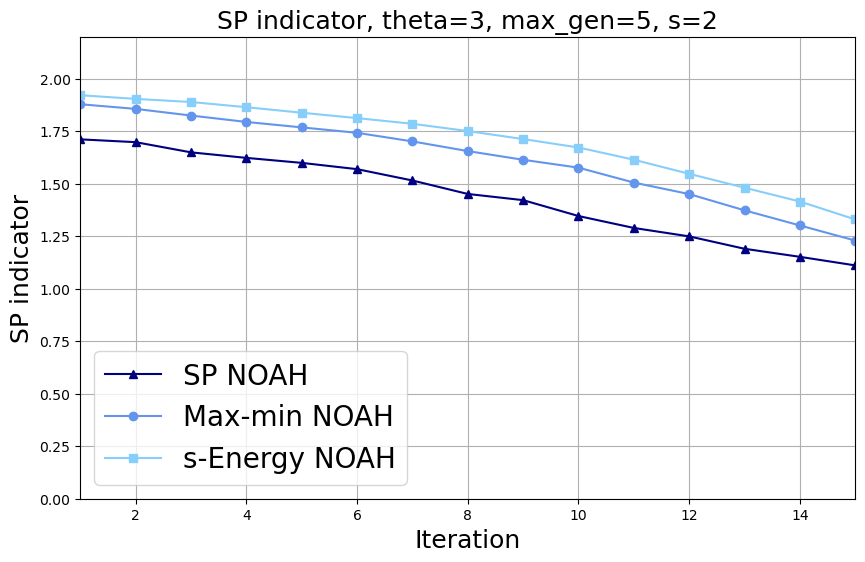

In [79]:
plt.figure(figsize=(10, 6))

plt.plot(SP_diversity_sp5t3s2, 'navy', label='SP NOAH', marker='^')
plt.plot(SP_diversity_mxmn5t3s2, 'cornflowerblue', label='Max-min NOAH', marker='o')
plt.plot(SP_diversity_sen5t3s2, 'lightskyblue', label='s-Energy NOAH', marker='s')


# Adding titles and labels
plt.title('SP indicator, theta=3, max_gen=5, s=2', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('SP indicator', fontsize=18)
plt.xlim((1, 15))
plt.ylim((0, 2.2))
plt.legend(prop = { "size": 20 }, loc ="lower left")
plt.grid(True)
plt.savefig('SP5s2t3.png')

# Show the plot
plt.show()

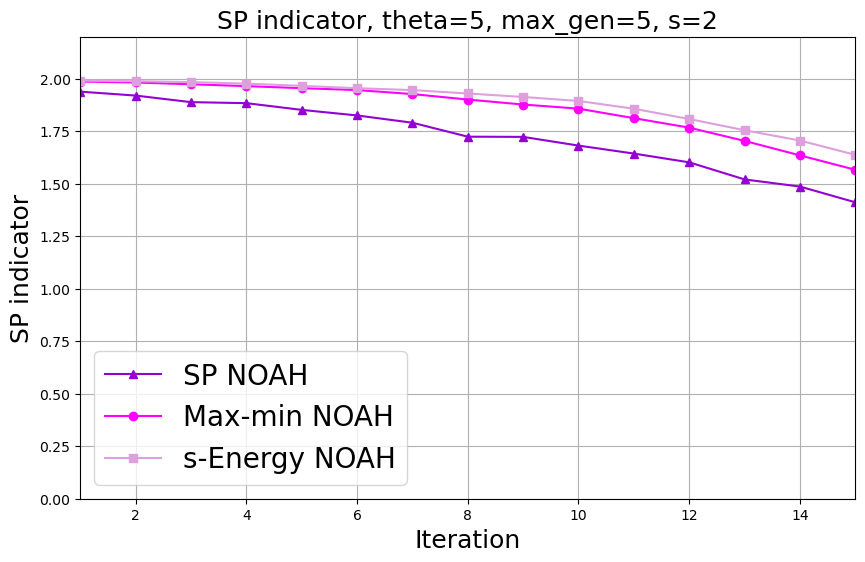

In [80]:
plt.figure(figsize=(10, 6))

plt.plot(SP_diversity_sp5t5s2, 'darkviolet', label='SP NOAH', marker='^')
plt.plot(SP_diversity_mxmn5t5s2, 'fuchsia', label='Max-min NOAH', marker='o')
plt.plot(SP_diversity_sen5t5s2, 'plum', label='s-Energy NOAH', marker='s')


# Adding titles and labels
plt.title('SP indicator, theta=5, max_gen=5, s=2', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('SP indicator', fontsize=18)
plt.xlim((1, 15))
plt.ylim((0, 2.2))
plt.legend(prop = { "size": 20 }, loc ="lower left")
plt.grid(True)
plt.savefig('SP5s2t5.png')

# Show the plot
plt.show()

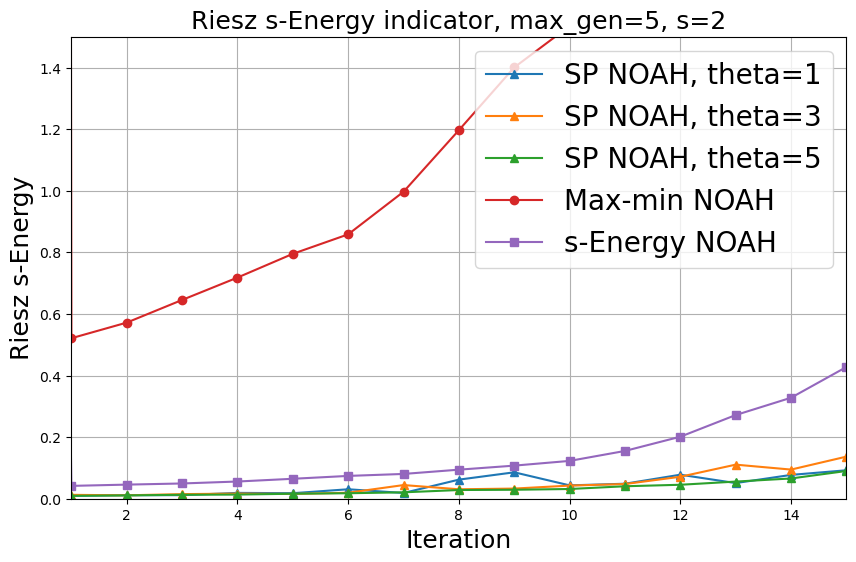

In [81]:
plt.figure(figsize=(10, 6))

plt.plot(S_energy_diversity_sp5t1s2, label='SP NOAH, theta=1', marker='^')
plt.plot(S_energy_diversity_sp5t3s2, label='SP NOAH, theta=3', marker='^')
plt.plot(S_energy_diversity_sp5t5s2, label='SP NOAH, theta=5', marker='^')
plt.plot(S_energy_diversity_mxmn5t5s2, label='Max-min NOAH', marker='o')
plt.plot(S_energy_diversity_sen5t5s2, label='s-Energy NOAH', marker='s')

# Adding titles and labels
plt.title('Riesz s-Energy indicator, max_gen=5, s=2', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Riesz s-Energy', fontsize=18)
plt.xlim((1, 15))
plt.ylim((0, 1.5))
plt.legend(prop = { "size": 20 }, loc ="upper right")
plt.grid(True)
plt.savefig('SEN5s2.png')

# Show the plot
plt.show()

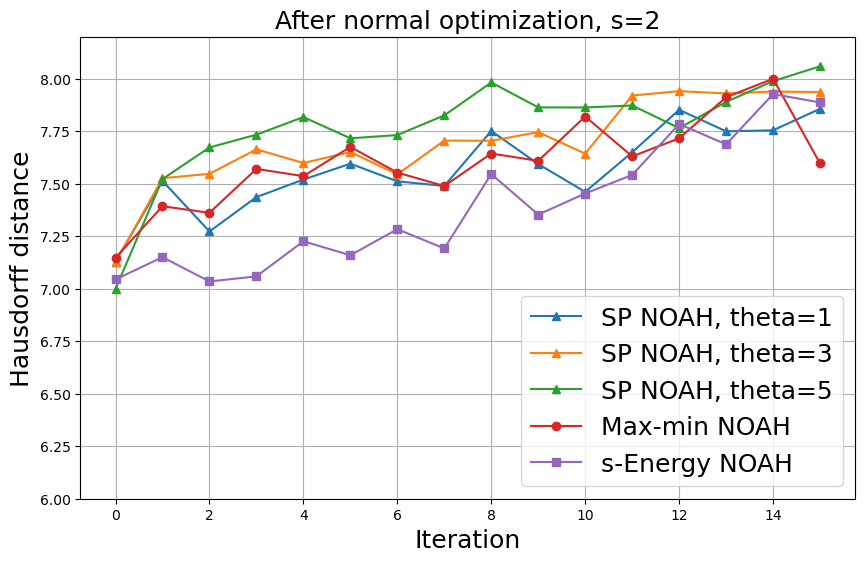

In [96]:
plt.figure(figsize=(10, 6))


plt.plot(Optimization_sp5t1s2, label='SP NOAH, theta=1', marker='^')
plt.plot(Optimization_sp5t3s2, label='SP NOAH, theta=3', marker='^')
plt.plot(Optimization_sp5t5s2, label='SP NOAH, theta=5', marker='^')
plt.plot(Optimization_mxmn5t5s2, label='Max-min NOAH', marker='o')
plt.plot(Optimization_sen5t5s2, label='s-Energy NOAH', marker='s')


# Adding titles and labels
plt.title('After normal optimization, s=2', fontsize=18)
plt.ylim((6, 8.2))
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Hausdorff distance', fontsize=18)
plt.legend(prop = { "size": 18 }, loc ="lower right")
plt.grid(True)
plt.savefig('Hausdorffcomparison_beforediv5s2.png')

# Show the plot
plt.show()

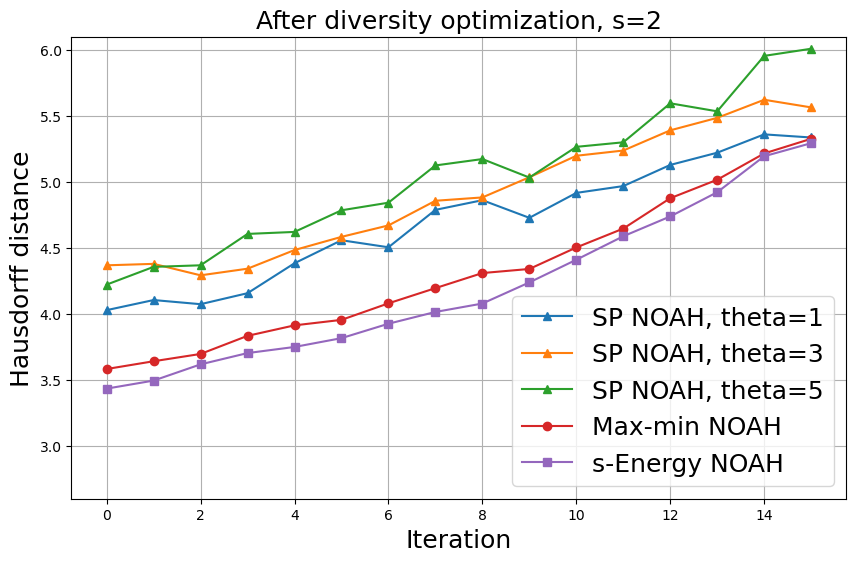

In [95]:
plt.figure(figsize=(10, 6))


plt.plot(Diversity_Optimization_sp5t1s2, label='SP NOAH, theta=1', marker='^')
plt.plot(Diversity_Optimization_sp5t3s2, label='SP NOAH, theta=3', marker='^')
plt.plot(Diversity_Optimization_sp5t5s2, label='SP NOAH, theta=5', marker='^')
plt.plot(Diversity_Optimization_mxmn5t5s2, label='Max-min NOAH', marker='o')
plt.plot(Diversity_Optimization_sen5t5s2, label='s-Energy NOAH', marker='s')


# Adding titles and labels
plt.title('After diversity optimization, s=2', fontsize=18)
plt.ylim((2.6, 6.1))
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Hausdorff distance', fontsize=18)
plt.legend(prop = { "size": 18 }, loc ="lower right")
plt.grid(True)
plt.savefig('Hausdorffcomparison_afterdiv5s2.png')

# Show the plot
plt.show()

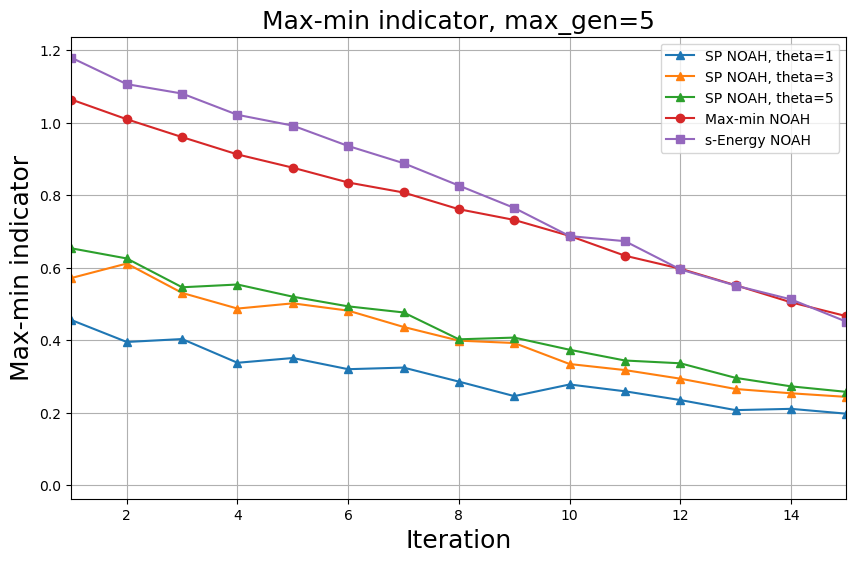

In [100]:
plt.figure(figsize=(10, 6))

plt.plot(Min_max_diversity_sp5t1, label='SP NOAH, theta=1', marker='^')
plt.plot(Min_max_diversity_sp5t3, label='SP NOAH, theta=3', marker='^')
plt.plot(Min_max_diversity_sp5t5, label='SP NOAH, theta=5', marker='^')
plt.plot(Min_max_diversity_mxmn5t5, label='Max-min NOAH', marker='o')
plt.plot(Min_max_diversity_sen5t5, label='s-Energy NOAH', marker='s')

# Adding titles and labels
plt.title('Max-min indicator, max_gen=5', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Max-min indicator', fontsize=18)
plt.xlim((1, 15))
plt.legend(prop = { "size": 10 }, loc ="upper right")
plt.grid(True)
plt.savefig('Maxmin5.png')

# Show the plot
plt.show()

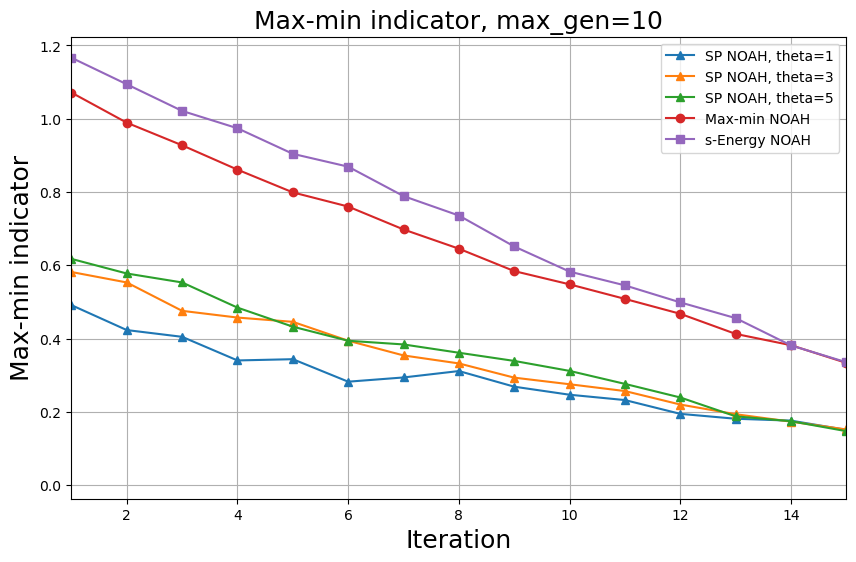

In [101]:
plt.figure(figsize=(10, 6))

plt.plot(Min_max_diversity_sp10t1, label='SP NOAH, theta=1', marker='^')
plt.plot(Min_max_diversity_sp10t3, label='SP NOAH, theta=3', marker='^')
plt.plot(Min_max_diversity_sp10t5, label='SP NOAH, theta=5', marker='^')
plt.plot(Min_max_diversity_mxmn10t5, label='Max-min NOAH', marker='o')
plt.plot(Min_max_diversity_sen10t5, label='s-Energy NOAH', marker='s')

# Adding titles and labels
plt.title('Max-min indicator, max_gen=10', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Max-min indicator', fontsize=18)
plt.xlim((1, 15))
plt.legend(prop = { "size": 10 }, loc ="upper right")
plt.grid(True)
plt.savefig('Maxmin10.png')

# Show the plot
plt.show()

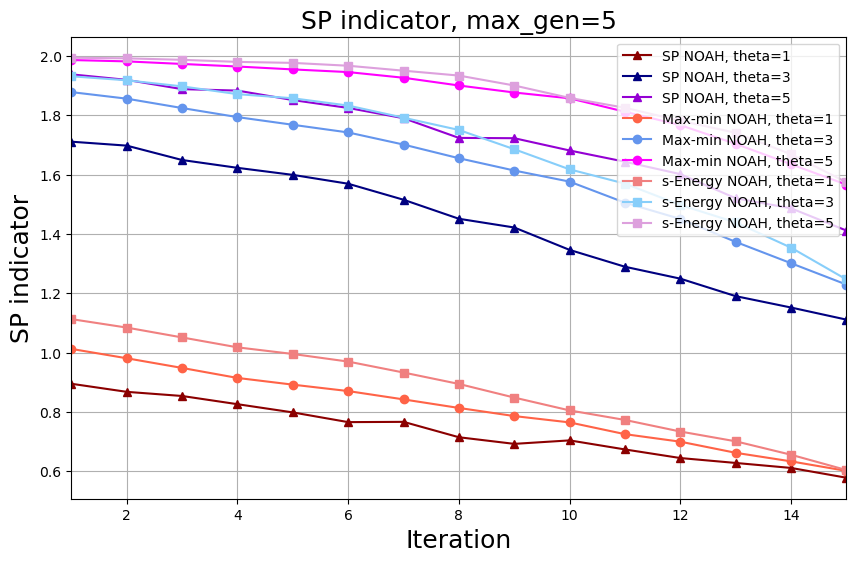

In [137]:
plt.figure(figsize=(10, 6))

plt.plot(SP_diversity_sp5t1, 'darkred', label='SP NOAH, theta=1', marker='^')
plt.plot(SP_diversity_sp5t3, 'navy', label='SP NOAH, theta=3', marker='^')
plt.plot(SP_diversity_sp5t5, 'darkviolet', label='SP NOAH, theta=5', marker='^')
plt.plot(SP_diversity_mxmn5t1, 'tomato', label='Max-min NOAH, theta=1', marker='o')
plt.plot(SP_diversity_mxmn5t3, 'cornflowerblue', label='Max-min NOAH, theta=3', marker='o')
plt.plot(SP_diversity_mxmn5t5, 'fuchsia', label='Max-min NOAH, theta=5', marker='o')
plt.plot(SP_diversity_sen5t1, 'lightcoral', label='s-Energy NOAH, theta=1', marker='s')
plt.plot(SP_diversity_sen5t3, 'lightskyblue', label='s-Energy NOAH, theta=3', marker='s')
plt.plot(SP_diversity_sen5t5, 'plum', label='s-Energy NOAH, theta=5', marker='s')


# Adding titles and labels
plt.title('SP indicator, max_gen=5', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('SP indicator', fontsize=18)
plt.xlim((1, 15))
plt.legend(prop = { "size": 10 }, loc ="upper right")
plt.grid(True)
plt.savefig('SP5.png')

# Show the plot
plt.show()

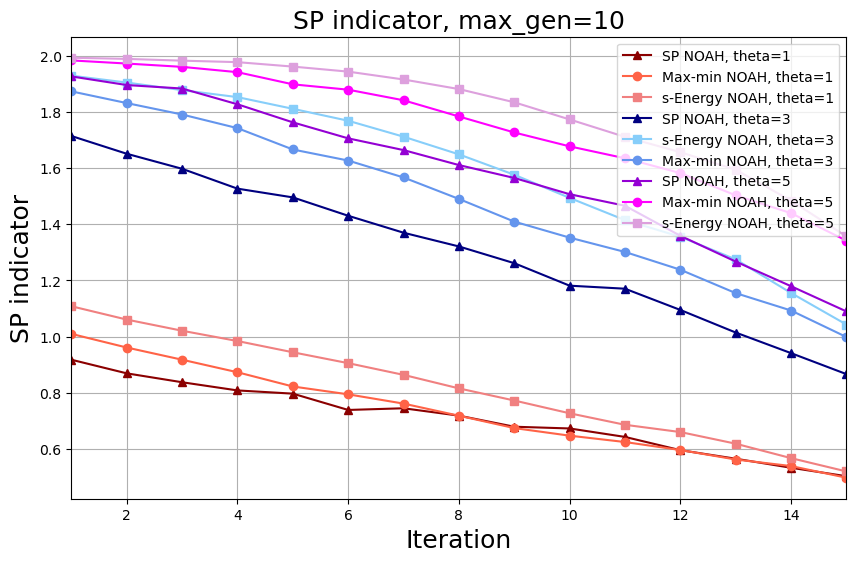

In [185]:
plt.figure(figsize=(10, 6))

plt.plot(SP_diversity_sp10t1, 'darkred', label='SP NOAH, theta=1', marker='^')
plt.plot(SP_diversity_mxmn10t1, 'tomato', label='Max-min NOAH, theta=1', marker='o')
plt.plot(SP_diversity_sen10t1, 'lightcoral', label='s-Energy NOAH, theta=1', marker='s')
plt.plot(SP_diversity_sp10t3, 'navy', label='SP NOAH, theta=3', marker='^')
plt.plot(SP_diversity_sen10t3, 'lightskyblue', label='s-Energy NOAH, theta=3', marker='s')
plt.plot(SP_diversity_mxmn10t3, 'cornflowerblue', label='Max-min NOAH, theta=3', marker='o')
plt.plot(SP_diversity_sp10t5, 'darkviolet', label='SP NOAH, theta=5', marker='^')
plt.plot(SP_diversity_mxmn10t5, 'fuchsia', label='Max-min NOAH, theta=5', marker='o')
plt.plot(SP_diversity_sen10t5, 'plum', label='s-Energy NOAH, theta=5', marker='s')


# Adding titles and labels
plt.title('SP indicator, max_gen=10', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('SP indicator', fontsize=18)
plt.xlim((1, 15))
plt.legend(prop = { "size": 10 }, loc ="upper right")
plt.grid(True)
plt.savefig('SP10.png')

# Show the plot
plt.show()

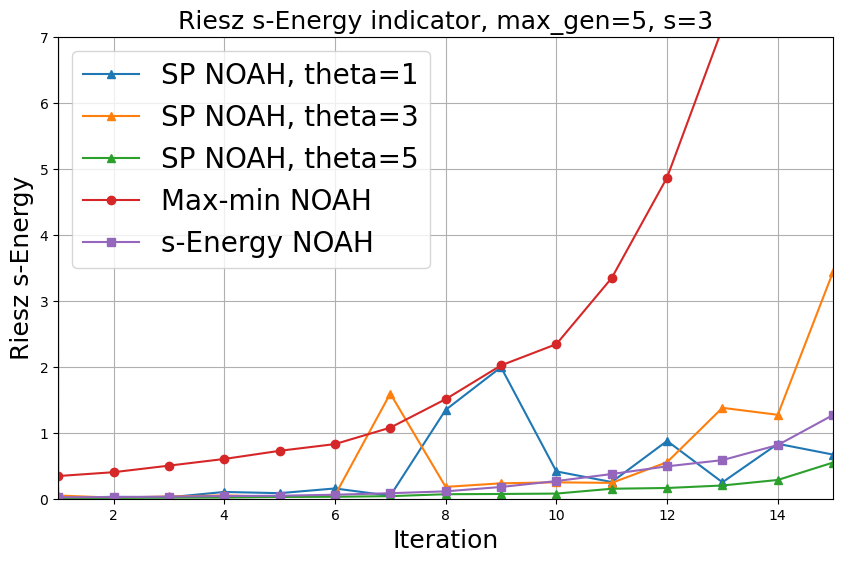

In [195]:
plt.figure(figsize=(10, 6))

plt.plot(S_energy_diversity_sp5t1, label='SP NOAH, theta=1', marker='^')
plt.plot(S_energy_diversity_sp5t3, label='SP NOAH, theta=3', marker='^')
plt.plot(S_energy_diversity_sp5t5, label='SP NOAH, theta=5', marker='^')
plt.plot(S_energy_diversity_mxmn5t5, label='Max-min NOAH', marker='o')
plt.plot(S_energy_diversity_sen5t5, label='s-Energy NOAH', marker='s')

# Adding titles and labels
plt.title('Riesz s-Energy indicator, max_gen=5, s=3', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Riesz s-Energy', fontsize=18)
plt.xlim((1, 15))
plt.ylim((0, 7))
plt.legend(prop = { "size": 20 }, loc ="upper left")
plt.grid(True)
plt.savefig('SEN5.png')

# Show the plot
plt.show()

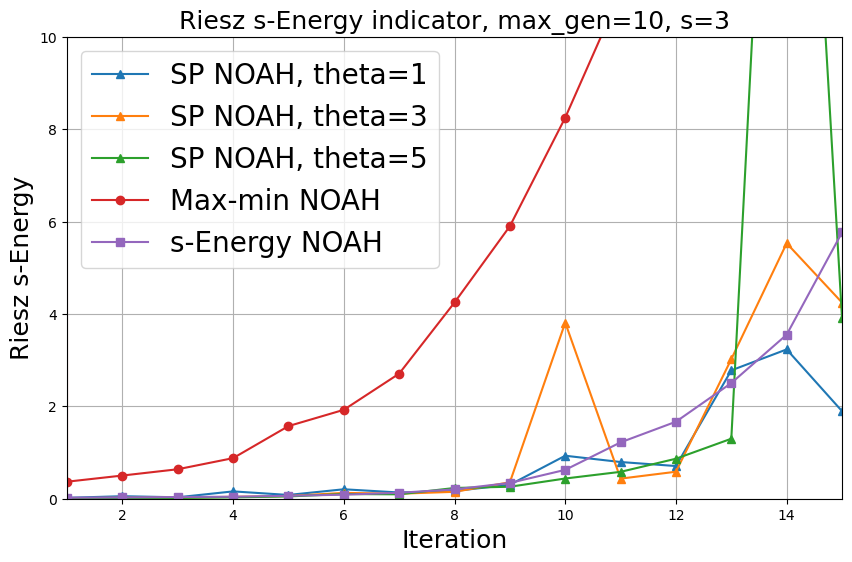

In [196]:
plt.figure(figsize=(10, 6))

plt.plot(S_energy_diversity_sp10t1, label='SP NOAH, theta=1', marker='^')
plt.plot(S_energy_diversity_sp10t3, label='SP NOAH, theta=3', marker='^')
plt.plot(S_energy_diversity_sp10t5, label='SP NOAH, theta=5', marker='^')
plt.plot(S_energy_diversity_mxmn10t5, label='Max-min NOAH', marker='o')
plt.plot(S_energy_diversity_sen10t5, label='s-Energy NOAH', marker='s')

# Adding titles and labels
plt.title('Riesz s-Energy indicator, max_gen=10, s=3', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Riesz s-Energy', fontsize=18)
plt.xlim((1, 15))
plt.ylim((0, 10))
plt.legend(prop = { "size": 20 }, loc ="upper left")
plt.grid(True)
plt.savefig('SEN10.png')

# Show the plot
plt.show()

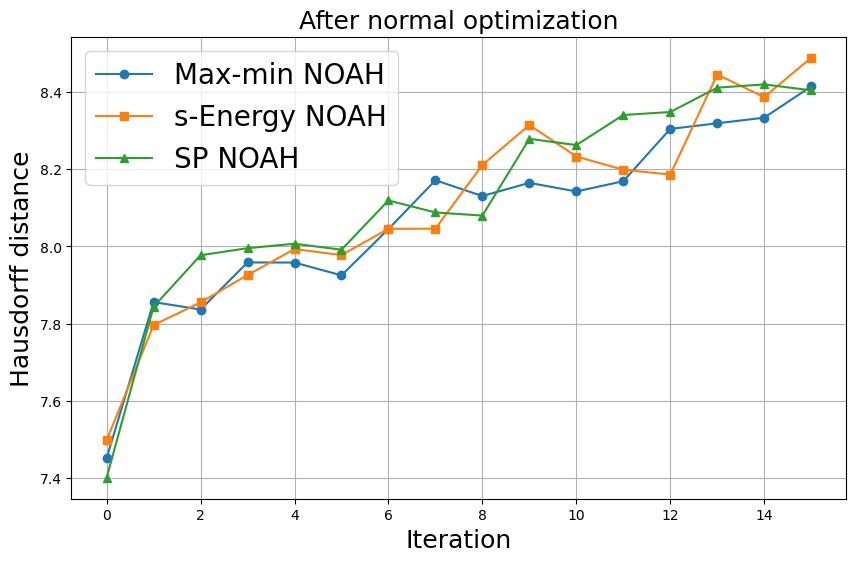

In [306]:
plt.figure(figsize=(10, 6))

plt.plot(Optimization_mxmn10t5, label='Max-min NOAH', marker='o')
plt.plot(Optimization_sen10t5, label='s-Energy NOAH', marker='s')
plt.plot(Optimization_sp10t5, label='SP NOAH', marker='^')

# Adding titles and labels
plt.title('After normal optimization', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Hausdorff distance', fontsize=18)
plt.legend(prop = { "size": 20 }, loc ="upper left")
plt.grid(True)
plt.savefig('Hausdorffcomparison_beforediv.png')

# Show the plot
plt.show()

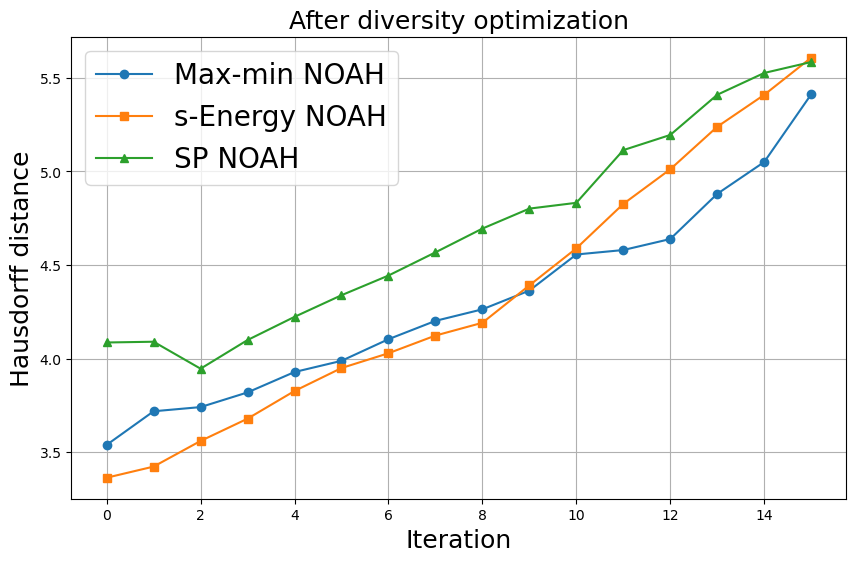

In [302]:
plt.figure(figsize=(10, 6))

plt.plot(diversity_optimization, label='Max-min NOAH', marker='o')
plt.plot(diversity_optimization_2, label='s-Energy NOAH', marker='s')
plt.plot(diversity_optimization_3, label='SP NOAH', marker='^')

# Adding titles and labels
plt.title('After diversity optimization', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Hausdorff distance', fontsize=18)
plt.legend(prop = { "size": 20 }, loc ="upper left")
plt.grid(True)

plt.savefig('Hausdorffcomparison_afterdiv.png')

# Show the plot
plt.show()

# Comparison of normal Max-min optimization and modified one 

In [281]:
#WITH B and counter - РАБОТАЕТ ЛУЧШЕ, СТОИТ ОСТАВИТЬ


#c - параметр схождения, если c раз подряд значение diversity не меняется, значит, все
# На входе будет r элементов популяции, на выходе надо n = pop_size

def divOpt_simple_minmax(P, it, pop_size, b, c, mutation_rate, box_border):
    
    start_time = time.time()

    a_fp = open('./obj_div_simple_minmax_' + str(mutation_rate) + '.json', 'w')
    b_fp = open('./sol_div_simple_minmax_' + str(mutation_rate) + '.json', 'w')
    c_fp = open('./0.9statistic_div_simple_minmax_' + str(mutation_rate) + '.json', 'w')
    iteration = 0
    A = []
    B = []
    S = []
    for iteration in range(it):
        print("iteration", iteration)
        
        #Main program starts here

        #Initialization
        min_x=-55
        max_x=55
        A = defaultdict()
        C = defaultdict()
        solution = P
        diversity = []
        
        iteration_no_change = 0

        
        selec = SelectDiv_minmax(solution, len(solution))
        diversity.append(selec[0])

        gen_no=0
        
        while(len(solution)!=pop_size):
                
                #Поменяла на len(P)=r, было pop_size
                #здесь надо выбирать только из элементов с индексами solution
#                 a1 = random.randint(0,len(P)-1)
                 
    
            s = 0
            while s == 0:
                a1 = random.randint(0,len(P)-2)
                app = mutation(solution[a1], mutation_rate)
                if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                    app = reflect_point(app[0], app[1], box_border)
                
                min_distance_from_new = 1000
                for z in range(len(solution)):
                    if my_distance(solution[z], app)<min_distance_from_new:
                        min_distance_from_new = my_distance(solution[z], app)
                            
                if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (min_distance_from_new>=diversity[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
                    solution.append(app)
                    
                    s = 1
                else:
                    pass
        
        while (diversity[-1]<1.9):
#             print("GENERATION", gen_no)
            
            solution2 = solution[:]
            
            #Just printing
            
#             for i in range(len(solution)):
#                 print(-obj1(solution[i]), -obj2(solution[i]))
        
#             Generating offsprings
#             print("offsprings")

            while(len(solution2)!=pop_size+1):
                
                #Поменяла на len(P)=r, было pop_size
                #здесь надо выбирать только из элементов с индексами solution
#                 a1 = random.randint(0,len(P)-1)
                 
                s = 0
                counter = 0
                while (s == 0) and (counter < 700):
                    a1 = random.randint(0,len(P)-1)
                    app = mutation(solution[a1], mutation_rate)
                    if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                        app = reflect_point(app[0], app[1], box_border)
                    min_distance_from_new = 1000
                    for z in range(len(solution)):
                        if my_distance(solution[z], app)<min_distance_from_new:
                            min_distance_from_new = my_distance(solution[z], app)
    #                 print(min_distance_from_new)    
    #УБРАЛА  (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and
                    if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (min_distance_from_new>=diversity[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
                        solution2.append(app)
#                         print(-obj1(app), -obj2(app))
                        s = 1
#             print("offsprings are ready")
            
            # When it is [0, 2, .., 9] it is not supposed to chenge, but it's getting lower
            
            solution = []
            
            select_div = SelectDiv_minmax(solution2, pop_size) 
#             print("select_div", select_div)
            #не забыть все нужные параметры вставить
    
    
    
    
            if np.abs(select_div[0]-diversity[-1])<epsilon:
                iteration_no_change+=1
            else:
                iteration_no_change = 0
#             print(iteration_no_change)
            diversity.append(select_div[0])  
            indices = select_div[1]
            
#             print(indices)
            
            for i in range(2*pop_size):
                if i in indices:
                    solution.append(solution2[i])
                         
#             print(heights)
            
#             save = select_div[0]
            
             
            
#             print("len solution", len(solution), len(solution[0]))
#             print(solution)
            C[gen_no] = solution
            gen_no = gen_no + 1
            max_reached_gen = gen_no
#             print(solution)
            
#         print(max_reached_gen)
        print("diversity", diversity[-1])
        S.append(max_reached_gen)
        B.append(C)
        iteration +=1  
#         print(solution)
        
    json.dump(B, b_fp, cls=NpEncoder)  
    json.dump(S, c_fp, cls=NpEncoder)            

    a_fp.close()
    b_fp.close()
    c_fp.close()

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return solution

random.seed(400)
divOpt_simple_minmax(P_0, 1000, pop_size, b, 20, 10, 10)


iteration 0
diversity 1.9070267820238744
iteration 1
diversity 1.9581210066924832
iteration 2
diversity 1.9033858403987158
iteration 3
diversity 1.915164804797338
iteration 4
diversity 1.9100070318143787
iteration 5
diversity 1.972549168639877
iteration 6
diversity 1.9531445660610578
iteration 7
diversity 1.926621281013103
iteration 8
diversity 1.9637717455086008
iteration 9
diversity 1.9454069618215013
iteration 10
diversity 1.9142158794192876
iteration 11
diversity 1.9198907854346918
iteration 12
diversity 1.9075259141032013
iteration 13
diversity 1.9059727193370288
iteration 14
diversity 1.9083557210054847
iteration 15
diversity 1.9153401173243938
iteration 16
diversity 1.90176798702512
iteration 17
diversity 1.9242210141204361
iteration 18
diversity 1.9130992691915263
iteration 19
diversity 2.116862035241425
iteration 20
diversity 1.9107095666943166
iteration 21
diversity 1.9441776393834704
iteration 22
diversity 1.9093136860809143
iteration 23
diversity 1.9000997412091145
iteratio

diversity 1.919593115797044
iteration 211
diversity 1.910383824661021
iteration 212
diversity 1.9013098498152892
iteration 213
diversity 1.9068828854932554
iteration 214
diversity 1.9086023757257302
iteration 215
diversity 1.9043139108779448
iteration 216
diversity 1.9433826692181477
iteration 217
diversity 1.9287565964469033
iteration 218
diversity 1.9536499613080418
iteration 219
diversity 1.9022907047208777
iteration 220
diversity 1.9075678832785499
iteration 221
diversity 1.9021308844337244
iteration 222
diversity 1.9101473565621587
iteration 223
diversity 1.929705183523441
iteration 224
diversity 2.0070698056998504
iteration 225
diversity 1.9204120837416359
iteration 226
diversity 1.9281256661691486
iteration 227
diversity 1.917283026374996
iteration 228
diversity 1.907545759568712
iteration 229
diversity 1.9014395821584524
iteration 230
diversity 1.9078373597874023
iteration 231
diversity 1.9097732309387179
iteration 232
diversity 1.9040991670554697
iteration 233
diversity 1.9516

diversity 1.9052333055636717
iteration 415
diversity 1.9030323460533576
iteration 416
diversity 1.903021002926505
iteration 417
diversity 1.9083864893067857
iteration 418
diversity 1.9052388829697922
iteration 419
diversity 1.907488817532598
iteration 420
diversity 1.963346857918883
iteration 421
diversity 1.9631160082514079
iteration 422
diversity 1.953187228508412
iteration 423
diversity 1.900060995563378
iteration 424
diversity 1.9012515708496391
iteration 425
diversity 1.9277626748325387
iteration 426
diversity 1.910632108717079
iteration 427
diversity 1.9374713531766252
iteration 428
diversity 1.927674086730171
iteration 429
diversity 1.9420644983442248
iteration 430
diversity 1.9099969888699093
iteration 431
diversity 1.9733217707819621
iteration 432
diversity 1.9100065325662594
iteration 433
diversity 1.9045058535632755
iteration 434
diversity 1.9138670630393524
iteration 435
diversity 1.9008219919402836
iteration 436
diversity 1.9942774708630315
iteration 437
diversity 1.929196

diversity 1.9461044085105306
iteration 617
diversity 1.9339076982121675
iteration 618
diversity 1.903435939062071
iteration 619
diversity 1.903051751893472
iteration 620
diversity 1.912678909905411
iteration 621
diversity 1.9908508287981868
iteration 622
diversity 1.9085070608877523
iteration 623
diversity 1.910443667607642
iteration 624
diversity 1.9080591182587314
iteration 625
diversity 1.94158396080062
iteration 626
diversity 1.9116785470443225
iteration 627
diversity 1.9118700245701552
iteration 628
diversity 1.9889855706018382
iteration 629
diversity 1.913837656919816
iteration 630
diversity 1.9641573027286043
iteration 631
diversity 1.927024304628388
iteration 632
diversity 1.9101278634307628
iteration 633
diversity 1.9122786249037436
iteration 634
diversity 1.9013097879648262
iteration 635
diversity 1.9026297590440449
iteration 636
diversity 1.9007567446488982
iteration 637
diversity 1.91001877720493
iteration 638
diversity 1.9174401618777421
iteration 639
diversity 1.911554896

diversity 1.9097961470524027
iteration 816
diversity 1.9235793703269346
iteration 817
diversity 1.9329317632807546
iteration 818
diversity 1.9463942680384072
iteration 819
diversity 1.9023997479566521
iteration 820
diversity 1.9362685649391083
iteration 821
diversity 1.9048741888282084
iteration 822
diversity 1.9669923076470646
iteration 823
diversity 1.9333892198386653
iteration 824
diversity 1.9011040417715672
iteration 825
diversity 1.9060645053234382
iteration 826
diversity 1.9012890364171355
iteration 827
diversity 1.9312256838961257
iteration 828
diversity 1.9183675760419077
iteration 829
diversity 1.951069878150817
iteration 830
diversity 1.962857441261664
iteration 831
diversity 1.9208869924721843
iteration 832
diversity 1.9459600325228221
iteration 833
diversity 1.9871651967966468
iteration 834
diversity 1.9013479273590892
iteration 835
diversity 1.9248206630692548
iteration 836
diversity 1.9079093442999453
iteration 837
diversity 1.9446794698670797
iteration 838
diversity 1.9

[[9, 4],
 [9.03, 10],
 [0, 6],
 [0.1, 0.3],
 [2, 1.98],
 [7.26806569931307, 8.416282032153015],
 (6.16666657598968, 5.453708823520189),
 [4.982838762719405, 9.329044329275655],
 (9.709965972267527, 0.07438506365325348),
 (9.612834401310147, 6.887905161778974),
 (2.7469818173257647, 6.652204882754987),
 (0.7555835214432971, 3.872964869013316),
 (5.72879886511647, 0.2552761114566764),
 [0.35217679267587926, 8.121756272485543],
 [2.7381340479602994, 0.11262824126203141],
 [3.888080355026544, 3.0276374427793655],
 [6.324131204448698, 3.3533963806730007],
 (5.170767809314386, 7.255229103851596),
 (1.761339727394703, 9.876330055104692),
 [2.775658210441727, 4.678792419920134]]

In [283]:

#WITH B and counter - РАБОТАЕТ ЛУЧШЕ, СТОИТ ОСТАВИТЬ


#c - параметр схождения, если c раз подряд значение diversity не меняется, значит, все
# На входе будет r элементов популяции, на выходе надо n = pop_size

def divOpt_simple_minmax_nonzero(P, it, pop_size, b, c, mutation_rate, box_border, prob):
    
    start_time = time.time()

    a_fp = open('./obj_div_simple_minmax_nonzero_' + str(mutation_rate) + '.json', 'w')
    b_fp = open('./sol_div_simple_minmax_nonzero_' + str(mutation_rate) + '.json', 'w')
    c_fp = open('./0.9statistic_div_simple_minmax_nonzero_' + str(mutation_rate) + '.json', 'w')
    iteration = 0
    A = []
    B = []
    S = []
    for iteration in range(it):
        print("iteration", iteration)
        
        #Main program starts here

        #Initialization
        min_x=-55
        max_x=55
        A = defaultdict()
        C = defaultdict()
        solution = P
        diversity = []
        
        iteration_no_change = 0

        
        selec = SelectDiv_minmax(solution, len(solution))
        diversity.append(selec[0])
        non_zero_contributors = selec[3]
        select_div = [0, 0, 0, 0]

        gen_no=0
        
        while(len(solution)!=pop_size):
                
                #Поменяла на len(P)=r, было pop_size
                #здесь надо выбирать только из элементов с индексами solution
#                 a1 = random.randint(0,len(P)-1)
                 
    
            s = 0
            while s == 0:
                a1 = random.randint(0,len(P)-2)
                app = mutation(solution[a1], mutation_rate)
                if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                    app = reflect_point(app[0], app[1], box_border)
                
                min_distance_from_new = 1000
                for z in range(len(solution)):
                    if my_distance(solution[z], app)<min_distance_from_new:
                        min_distance_from_new = my_distance(solution[z], app)
                            
                if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (min_distance_from_new>=diversity[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
                    solution.append(app)
                    
                    s = 1
                else:
                    pass
                
        
        while (diversity[-1]<1.9):
#             print("GENERATION", gen_no)
            
            solution2 = solution[:]
            
            if len(non_zero_contributors)==0:
                flag = 0
            else:
                flag = 1

            while(len(solution2)!=pop_size+1):
                 
                if flag == 0:
                    a1 = random.randint(0,len(P)-1)
                    s = 0
                    while (s == 0):
                        a1 = random.randint(0,len(P)-1)
                        app = mutation(solution[a1], mutation_rate)
                        if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                            app = reflect_point(app[0], app[1], box_border)
                            
                        min_distance_from_new = 1000
                        
                        for z in range(len(solution)):
                            if my_distance(solution[z], app)<min_distance_from_new:
                                min_distance_from_new = my_distance(solution[z], app)
   
                        if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (min_distance_from_new>=diversity[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
                            solution2.append(app)
    #                         print(-obj1(app), -obj2(app))
                            s = 1
                        else:
                            counter += 1
                else: 
                    #ЗДЕСЬ С ВЕРОЯТНОСТЬЮ ПРОБ ВЫБИРАЛИСЬ ИМЕННО НЕНУЛЕВЫЕ ЭЛЕМЕНТЫ
                    if random.random() < prob:
                        a1 = random.choice(non_zero_contributors)
                    else:
                        a1 = random.choice([solution[i] for i in range(len(P_0))])
                        
                    s = 0
                    while (s == 0):
                        a1 = random.randint(0,len(P)-1)
                        app = mutation(solution[a1], mutation_rate)
                        if (app[0]<0) or (app[1]<0) or (app[0]>box_border) or (app[1]>box_border):
                            app = reflect_point(app[0], app[1], box_border)
                            
                        min_distance_from_new = 1000
                        
                        for z in range(len(solution)):
                            if my_distance(solution[z], app)<min_distance_from_new:
                                min_distance_from_new = my_distance(solution[z], app)
   
                        if (-obj1(app)<b[0]) and (-obj2(app)<b[1]) and (my_distance(app, solution[a1]) > epsilon) and (min_distance_from_new>=diversity[-1]) and (app[0]>=0) and (app[1]>=0) and (app[0]<=box_border) and (app[1]<=box_border) :
#                             print("flag = 1")
                            solution2.append(app)
    #                         print(-obj1(app), -obj2(app))
                            s = 1
#             print("offsprings are ready")
            
            # When it is [0, 2, .., 9] it is not supposed to chenge, but it's getting lower
            
            solution = []
            
            select_div = SelectDiv_minmax(solution2, pop_size) 
#             print("select_div", select_div)
            #не забыть все нужные параметры вставить
    
    
    
    
            if np.abs(select_div[0]-diversity[-1])<epsilon:
                iteration_no_change+=1
            else:
                iteration_no_change = 0
#             print(iteration_no_change)
            diversity.append(select_div[0])  
            indices = select_div[1]
            non_zero_contributors = select_div[3] 
            
            
            for i in range(2*pop_size):
                if i in indices:
                    solution.append(solution2[i])
            
    
            C[gen_no] = solution
            gen_no = gen_no + 1
            max_reached_gen = gen_no
#             print(solution)
            
#         print(max_reached_gen)
        print("diversity", diversity[-1])
        S.append(max_reached_gen)
        B.append(C)
        iteration +=1  
#         print(solution)
        
    json.dump(B, b_fp, cls=NpEncoder)  
    json.dump(S, c_fp, cls=NpEncoder)            

    a_fp.close()
    b_fp.close()
    c_fp.close()

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return solution

random.seed(4)
divOpt_simple_minmax_nonzero(P_0, 1000, pop_size, b, 20, 10, 10, 0.9)


iteration 0
diversity 1.9236899989550598
iteration 1
diversity 1.9629204453121598
iteration 2
diversity 1.9382468498568965
iteration 3
diversity 1.9743625301218912
iteration 4
diversity 1.9011194944171372
iteration 5
diversity 1.9011238360017264
iteration 6
diversity 1.935269803888639
iteration 7
diversity 1.922875315882615
iteration 8
diversity 1.9019370193944836
iteration 9
diversity 1.9079626039422513
iteration 10
diversity 1.9610352403179123
iteration 11
diversity 1.9104028690389963
iteration 12
diversity 1.9153747947049653
iteration 13
diversity 2.0401649664144017
iteration 14
diversity 1.916585811855337
iteration 15
diversity 1.9145199781966924
iteration 16
diversity 1.9018772899174405
iteration 17
diversity 1.9393747552007645
iteration 18
diversity 1.9127185499758443
iteration 19
diversity 1.918389987211058
iteration 20
diversity 1.9317979362959508
iteration 21
diversity 1.908827166233568
iteration 22
diversity 1.909177925494382
iteration 23
diversity 1.906247339911045
iteration

diversity 1.9058754211140678
iteration 198
diversity 1.9044351882922679
iteration 199
diversity 1.9116042486078024
iteration 200
diversity 1.9429962045709652
iteration 201
diversity 1.9529889873630841
iteration 202
diversity 1.908994092128041
iteration 203
diversity 1.9018361406917983
iteration 204
diversity 1.9154819686025657
iteration 205
diversity 1.9218667503239162
iteration 206
diversity 1.9007715439412405
iteration 207
diversity 1.9122340765249173
iteration 208
diversity 1.9585410757564423
iteration 209
diversity 1.935358360034009
iteration 210
diversity 1.9582421672367234
iteration 211
diversity 1.9011249018796132
iteration 212
diversity 1.9053070128410754
iteration 213
diversity 1.9030163375439422
iteration 214
diversity 1.902288031066045
iteration 215
diversity 1.919646434647222
iteration 216
diversity 1.9155386733832185
iteration 217
diversity 1.9636750624821402
iteration 218
diversity 1.930909195326302
iteration 219
diversity 1.9072633533718861
iteration 220
diversity 1.9040

diversity 1.9342751925484458
iteration 390
diversity 1.9509229029223907
iteration 391
diversity 1.9133057802763065
iteration 392
diversity 1.903034856102876
iteration 393
diversity 1.9124475974704371
iteration 394
diversity 1.9026297590440449
iteration 395
diversity 1.900622190087596
iteration 396
diversity 1.902915150298937
iteration 397
diversity 1.9062806078058494
iteration 398
diversity 1.9021152001512103
iteration 399
diversity 1.905948147356149
iteration 400
diversity 1.9022534810154377
iteration 401
diversity 1.9195322172836502
iteration 402
diversity 1.909254507151157
iteration 403
diversity 1.9142572784852099
iteration 404
diversity 1.9088610359675287
iteration 405
diversity 1.9416482710303382
iteration 406
diversity 1.9107082324522562
iteration 407
diversity 1.906299718056876
iteration 408
diversity 1.9000429696918164
iteration 409
diversity 1.9511103769355802
iteration 410
diversity 1.9260149483414242
iteration 411
diversity 1.90956066675398
iteration 412
diversity 1.9222655

diversity 1.9198027726833746
iteration 588
diversity 1.9026297590440449
iteration 589
diversity 2.02322885381304
iteration 590
diversity 1.9041711690337586
iteration 591
diversity 1.921821929951317
iteration 592
diversity 1.9006270499431108
iteration 593
diversity 1.9549666755684176
iteration 594
diversity 1.9225151145901849
iteration 595
diversity 1.9484323991784416
iteration 596
diversity 1.9457841828023805
iteration 597
diversity 1.9810023566413462
iteration 598
diversity 1.9249678388080376
iteration 599
diversity 1.9509233097273873
iteration 600
diversity 1.9125061093066404
iteration 601
diversity 1.9258972621848072
iteration 602
diversity 1.9447893420448648
iteration 603
diversity 1.9279678206382866
iteration 604
diversity 1.9038026345047503
iteration 605
diversity 1.9147505381682075
iteration 606
diversity 1.9043775532053158
iteration 607
diversity 1.933641507578026
iteration 608
diversity 1.905835792425832
iteration 609
diversity 1.9033916795195103
iteration 610
diversity 1.9245

diversity 1.9616083292225694
iteration 786
diversity 1.9295594050964562
iteration 787
diversity 1.970356869068064
iteration 788
diversity 1.9274730381868876
iteration 789
diversity 1.9136127708926167
iteration 790
diversity 1.9188895267752575
iteration 791
diversity 1.9085450911045059
iteration 792
diversity 1.9023885748484313
iteration 793
diversity 1.96201611974252
iteration 794
diversity 1.9158002295555339
iteration 795
diversity 1.907325003688597
iteration 796
diversity 1.9164985126310934
iteration 797
diversity 1.9512960080838009
iteration 798
diversity 1.9641791728950977
iteration 799
diversity 1.9294270340272355
iteration 800
diversity 1.926820063359537
iteration 801
diversity 1.9052807965731007
iteration 802
diversity 1.9185634119563884
iteration 803
diversity 1.9140813852567102
iteration 804
diversity 1.9173384579287265
iteration 805
diversity 1.9177876597701078
iteration 806
diversity 1.9009721897770597
iteration 807
diversity 1.936938323077929
iteration 808
diversity 1.92228

diversity 1.936528484199794
iteration 985
diversity 1.915787935407976
iteration 986
diversity 1.903793022133369
iteration 987
diversity 1.9096614945278971
iteration 988
diversity 1.909054776312522
iteration 989
diversity 1.9282756002708321
iteration 990
diversity 1.9273510319827083
iteration 991
diversity 1.9002178355399288
iteration 992
diversity 1.9036348655233493
iteration 993
diversity 1.9089549152139316
iteration 994
diversity 2.005396207768632
iteration 995
diversity 1.9375321144498079
iteration 996
diversity 1.9402420147939052
iteration 997
diversity 1.92902748446713
iteration 998
diversity 1.901256956039635
iteration 999
diversity 1.9300751559910843
--- 117.94787216186523 seconds ---


[[2, 4.2],
 [9.05, 1],
 [9.03, 10],
 [0, 6],
 [0.1, 0.3],
 [2, 1.98],
 (7.865466813960886, 6.195178539883711),
 (7.2813128027650365, 4.355625822787023),
 (3.9774653535403846, 7.303836041828346),
 (3.3608876565047305, 9.60901205006789),
 [0.6696952850374691, 8.32870770806139],
 [0.054773945797206736, 3.60622861537762],
 [5.854392904923275, 9.8567184759374],
 [4.466888690210178, 1.9369704284131921],
 (5.88752436751612, 6.710553010669821),
 [9.668495555860412, 4.303584821194358],
 (2.1708425790094354, 6.255253164924383),
 (6.451199584421619, 1.544956298522564),
 [9.240806164196782, 7.738168404631345],
 [4.024592367620489, 4.5876297319307175]]

In [285]:

def statistical_comparison(js1, js2):
    
    with open(js1, 'r') as f:
        list_non_zero = ast.literal_eval(f.readlines()[0])
    with open(js2, 'r') as f:
        list_with_zero = ast.literal_eval(f.readlines()[0])
    
    print(statistics.mean(list_non_zero), statistics.stdev(list_non_zero), statistics.mean(list_with_zero), statistics.stdev(list_with_zero))
    
    # Two-Sample t-test
    t_stat, t_p_value = scipy.stats.ttest_ind(list_non_zero, list_with_zero)
    print(t_stat, t_p_value)
    
statistical_comparison('0.9statistic_div_simple_minmax_nonzero_10.json', '0.9statistic_div_simple_minmax_10.json')

31.844 4.442679529450825 32.24 4.129097897779786
-2.0646615981985788 0.03908380512861559


# Paired comparison of all results (not included in the paper) 

In [99]:
def compare_two_lists(list1, list2):
    t_stat, t_p_value = scipy.stats.ttest_rel(list1, list2)
    print(statistics.mean(list1), statistics.mean(list2))
    return [t_stat, t_p_value]


In [103]:
#Не знаю как сравнить зависимые 3 выборки
def compare_three_lists(list1, list2, list3):
    k_stat, k_p_value = scipy.stats.kruskal(list1, list2, list3)
    print(statistics.mean(list1), statistics.mean(list2), statistics.mean(list3))
    return [k_stat, k_p_value]

In [204]:
# Minmax

sp_diversity = [
    1.289199, 1.992752, 1.984671, 1.978791, 1.969326, 
    1.948743, 1.940491, 1.917006, 1.892472, 1.869275, 
    1.839718, 1.798662, 1.772763, 1.730658, 1.664272, 
    1.587330
]

# Min-Max Diversity
min_max_diversity = [
    0.020000, 1.155057, 1.076923, 1.017851, 0.956182, 
    0.896359, 0.864250, 0.814980, 0.763097, 0.730958, 
    0.683252, 0.641958, 0.607719, 0.564796, 0.510914, 
    0.453903
]

# S-Energy Diversity (divided by 100)
s_energy_diversity = np.array([
    4458.612694, 0.264910, 0.366218, 0.437088, 0.557592, 
    0.887322, 1.003750, 1.478514, 2.227013, 2.804378, 
    4.013549, 5.346665, 7.400823, 8.685858, 10.206573, 
    16.005764
])

# Average Himmelblau's function (obj1)
average_himmelblaus_obj1 = [
    0.011730, 0.009366, 0.009402, 0.009419, 0.009403, 
    0.009408, 0.009580, 0.009557, 0.009550, 0.009475, 
    0.009450, 0.009377, 0.009359, 0.009238, 0.008956, 
    0.008852
]

# Average x² function (obj1)
average_x2_obj1 = [
    0.106289, 0.043626, 0.038726, 0.035411, 0.031480, 
    0.028532, 0.026705, 0.024218, 0.021740, 0.020261, 
    0.018588, 0.016948, 0.015813, 0.014355, 0.012922, 
    0.011714
]

# Optimization
optimization = [
    7.451326, 7.855854, 7.836587, 7.958636, 7.958332, 
    7.925209, 8.045178, 8.171637, 8.130771, 8.164983, 
    8.142607, 8.169197, 8.304763, 8.319354, 8.333976, 
    8.414887
]

# Diversity Optimization
diversity_optimization = [
    3.538180, 3.717981, 3.740359, 3.818768, 3.927783, 
    3.987598, 4.103164, 4.201240, 4.263009, 4.363165, 
    4.556143, 4.579950, 4.638799, 4.880286, 5.050622, 
    5.412182
]


In [205]:
# S-Energy Diversity


sp_diversity_2 = [
    1.289199, 1.996073, 1.991996, 1.987945, 1.981956, 
    1.967903, 1.951544, 1.932737, 1.895963, 1.874545, 
    1.827847, 1.784486, 1.702311, 1.624896, 1.556300, 
    1.480062
]

# Min-Max Diversity
min_max_diversity_2 = [
    0.020000, 1.221061, 1.138655, 1.076242, 1.031588, 
    0.942658, 0.909607, 0.838863, 0.767845, 0.698749, 
    0.663497, 0.607038, 0.535997, 0.486068, 0.429293, 
    0.379392
]

s_energy_diversity_2 = np.array([
    445.861269, 0.019368, 0.025308, 0.030822, 0.038321, 
    0.056873, 0.081425, 0.118431, 0.228517, 0.297233, 
    0.522955, 0.646044, 1.074184, 2.085269, 3.569676, 
    4.610993
])*10

# Average Himmelblau's function (obj1)
average_himmelblaus_obj1_2 = [
    0.011730, 0.009600, 0.009608, 0.009532, 0.009616, 
    0.009601, 0.009599, 0.009561, 0.009561, 0.009461, 
    0.009287, 0.009163, 0.009011, 0.008784, 0.008641, 
    0.008437
]

# Average x² function (obj1)
average_x2_obj1_2 = [
    0.106289, 0.055352, 0.049133, 0.044683, 0.040917, 
    0.036637, 0.033793, 0.030192, 0.026679, 0.023562, 
    0.021241, 0.019300, 0.017019, 0.015214, 0.014057, 
    0.012782
]

# Optimization
optimization_2 = [
    7.497427, 7.796311, 7.855045, 7.926001, 7.993331, 
    7.977684, 8.045780, 8.046087, 8.211405, 8.315027, 
    8.233245, 8.198871, 8.186490, 8.445689, 8.387225, 
    8.489354
]

# Diversity Optimization
diversity_optimization_2 = [
    3.362746, 3.422245, 3.559312, 3.678381, 3.826344, 
    3.949061, 4.028183, 4.122715, 4.191066, 4.390973, 
    4.588962, 4.826460, 5.011662, 5.239017, 5.409667, 
    5.608053
]

In [206]:
# SP diversity
sp_diversity_3 = [
    1.289199, 1.960487, 1.945357, 1.937804, 1.924560, 
    1.909342, 1.869035, 1.837104, 1.797108, 1.744152, 
    1.739766, 1.702741, 1.622240, 1.572711, 1.494850, 
    1.417844
]

# Min-Max Diversity
min_max_diversity_3 = [
    0.020000, 0.724326, 0.677254, 0.628711, 0.622938, 
    0.600469, 0.529807, 0.496154, 0.447991, 0.423633, 
    0.412592, 0.389407, 0.344460, 0.311957, 0.279708, 
    0.245256
]

# S-Energy Diversity
s_energy_diversity_3 = np.array([
    44.586127, 0.006602, 0.008349, 0.009297, 0.010976, 
    0.014109, 0.021526, 0.863826, 0.061337, 0.082194, 
    0.097439, 0.336245, 0.197754, 0.621770, 0.696143, 
    2.926403
])*100

# Average Himmelblau's function (obj1)
average_himmelblaus_obj1_3 = [
    0.011730, 0.008437, 0.008432, 0.008630, 0.008870, 
    0.008912, 0.008896, 0.008877, 0.008940, 0.008881, 
    0.009055, 0.008936, 0.008793, 0.008705, 0.008598, 
    0.008348
]

# Average x² function (obj1)
average_x2_obj1_3 = [
    0.106289, 0.036426, 0.032597, 0.030453, 0.027351, 
    0.025033, 0.022691, 0.021111, 0.019045, 0.017011, 
    0.015413, 0.014264, 0.012799, 0.011787, 0.011149, 
    0.010127
]

# Optimization
optimization_3 = [
    7.400528, 7.843852, 7.977254, 7.995594, 8.007154, 
    7.991656, 8.119319, 8.088134, 8.080141, 8.279104, 
    8.262833, 8.340878, 8.348617, 8.411689, 8.420187, 
    8.404809
]

# Diversity Optimization
diversity_optimization_3 = [
    4.085698, 4.089746, 3.945617, 4.098771, 4.222704, 
    4.338337, 4.443570, 4.567530, 4.694627, 4.801443, 
    4.832356, 5.114050, 5.195214, 5.410029, 5.526543, 
    5.585083
]

In [197]:
compare_three_lists(sp_diversity, sp_diversity_2, sp_diversity_3)

1.9408131874999999 1.8028601874999999 1.73526875


[15.127256011507344, 0.0005189889293522805]

In [114]:
compare_three_lists(s_energy_diversity, s_energy_diversity_2, s_energy_diversity_3)

347.67658124999997 282.91497625 282.5186694375


[16.98278061224488, 0.0002052277323032883]

In [115]:
compare_three_lists(min_max_diversity, min_max_diversity_2, min_max_diversity_3)

0.295665 0.7290605625 0.7348874375


[23.15808903365906, 9.360194228054647e-06]

In [132]:
compare_three_lists(optimization, optimization_2, optimization_3)

8.09795375 8.06144825 8.0739560625


[0.1938775510203925, 0.90761157248771]

In [133]:
compare_three_lists(diversity_optimization, diversity_optimization_2, diversity_optimization_3)

4.73556875 4.315893375 4.2987018125


[6.21875, 0.04462883965030139]

## NSGA-II, mutation rate 0.7


In [26]:
mutation_rate = 0.7
pop_size = 50
it = 30
max_gen = 30

In [ ]:
def NSGA2_simple(P_0, mutation_rate, it, pop_size, max_gen):
    
    start_time = time.time()

    a_fp = open('./obj1evolution_simple_' + str(mutation_rate) + '.json', 'w')
    b_fp = open('./sol1evolution_simple_' + str(mutation_rate) + '.json', 'w')
    iteration = 0
    B = []
    D = []
    for iteration in range(it):
        print("iteration", iteration)
        
        #Main program starts here

        #Initialization
        min_x=-55
        max_x=55
        A = defaultdict()
        C = defaultdict()
        solution = P_0

        gen_no=0
        while(gen_no<max_gen):
            print("GENERATION", gen_no)
            function1_values = [obj1(solution[i]) for i in range(0,pop_size)]
            function2_values = [obj2(solution[i]) for i in range(0,pop_size)]
            non_dominated_sorted_solution = fast_non_dominated_sort(function1_values[:],function2_values[:])
#             crowding_distance_values=[]

#             for i in range(0,len(non_dominated_sorted_solution)):
#                 crowding_distance_values.append(crowding_distance(function1_values[:],function2_values[:],non_dominated_sorted_solution[i][:]))

            solution2 = solution[:]

            #Generating offsprings
            while(len(solution2)!=2*pop_size):
                a1 = random.randint(0,pop_size-1)
                s = 0
                app = mutation(solution[a1], mutation_rate)
                solution2.append(app)
#                 print("app", app, obj1(app), obj2(app))    
            
            function1_values2 = [obj1(solution2[i]) for i in range(0,2*pop_size)]
            function2_values2 = [obj2(solution2[i]) for i in range(0,2*pop_size)]
            
#             print(function1_values2, function2_values2)

            A[gen_no] = [function1_values, function2_values]
            non_dominated_sorted_solution2 = fast_non_dominated_sort(function1_values2[:],function2_values2[:])
            crowding_distance_values2=[]

            for i in range(0,len(non_dominated_sorted_solution2)):
                crowding_distance_values2.append(crowding_distance(function1_values2[:],function2_values2[:],non_dominated_sorted_solution2[i][:]))

            
            
            new_solution= []
            for i in range(0,len(non_dominated_sorted_solution2)):
                non_dominated_sorted_solution2_1 = [index_of(non_dominated_sorted_solution2[i][j],non_dominated_sorted_solution2[i] ) for j in range(0,len(non_dominated_sorted_solution2[i]))]
                front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
                front = [non_dominated_sorted_solution2[i][front22[j]] for j in range(0,len(non_dominated_sorted_solution2[i]))]
                front.reverse()
                for value in front:
                    new_solution.append(value)
                    if(len(new_solution)==pop_size):
                        break
                if (len(new_solution) == pop_size):
                    break
            solution = [solution2[i] for i in new_solution] 
            
#             print("solution", solution)
            
            C[gen_no] = solution
            gen_no = gen_no + 1
        B.append(A)   
        D.append(C)
        
#         print("B, D", B)
        iteration +=1  
        vis_plot(solution)
    json.dump(B, a_fp)
    json.dump(D, b_fp, cls=NpEncoder)            
    a_fp.close()
    b_fp.close()

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return 0

In [ ]:
NSGA2_simple(P_0, mutation_rate, it, pop_size, max_gen)

In [ ]:
def non_domin(objjs, it, max_gen):
    pareto_fronts(objjs, it, max_gen)
    return one_pareto_front(objjs, it, max_gen)

non_domin("obj1evolution_simple_0.7.json", 30, 0)

In [ ]:
# mutation_rate = 0.99
# pop_size = 50
# it = 1
# max_gen = 10000
# eps = 10

In [ ]:
# NSGA2_simple_eps(P_0, mutation_rate, it, pop_size, max_gen, eps)

In [ ]:
# a = sol("obj1evolution_simple_eps_0.7.json", 30).values.tolist()
print(a)
# pairs = []
# # Iterate over the length of the lists
# for i in range(50):
#     # Create a pair [first coordinate, second coordinate] and append it to the pairs list
#     pair = [a[0][i], a[1][i]]
#     pairs.append(pair)

# # Print the list of pairs
# vis_plot(pairs)

In [ ]:
# def non_domin_eps(objjs, it, max_gen, eps):
#     pareto_fronts_eps(objjs, it, max_gen, eps)
#     return one_pareto_front_eps(objjs, it, max_gen, eps)

# non_domin_eps("obj1evolution_simple_eps_0.7.json", 30, 30, 10)

In [ ]:
def knee_point(objjs, soljs, it, max_gen, mutation_rate, pop_size):
    minim = 100000
    nondom = non_domin(objjs, it, max_gen)
    print(nondom)
    sols = sol(soljs, it)
    for i in range(len(nondom[0])):
        if np.abs(nondom[0][i] - nondom[1][i]) < minim:
            minim = np.abs(nondom[0][i] - nondom[1][i])
            minim_arg = i
#     print(minim, minim_arg)
    for i in range(it):
        print(i)
        for j in range(max_gen):
            for d in range(pop_size):
#                 print(obj1(sols[i][j][d], heights), obj2(sols[i][j][d], heights))
#                 print(sols[i][j][d])
                if (np.abs(-obj1(sols[i][j][d]) - nondom[0][minim_arg]) < epsilon) and (np.abs(-obj2(sols[i][j][d]) - nondom[1][minim_arg]) < epsilon):
#                   
                    return sols[i][j][d]
    
knee_point("obj1evolution_simple_0.7.json", 'sol1evolution_simple_0.7.json', 30, 30, mutation_rate, pop_size)

In [ ]:
def min_obj1(objjs, soljs, it, max_gen, mutation_rate, pop_size):
    min1 = 100000
    nondom = non_domin(objjs, it, max_gen)
    sols = sol(soljs, it)
    for i in range(len(nondom[0])):
        if np.abs(nondom[0][i]) < min1:
            min1 = np.abs(nondom[0][i])
            min_arg1 = i
#     print(min1, min_arg1)
    for i in range(it):
        print(i)
        for j in range(max_gen):
            
            for d in range(pop_size):
                    
#                 print(sols[i][j][d])
    #             print(obj1(sol099[i][j][d], heights), obj2(sol099[i][j][d], heights))
                
                if (np.abs(-obj1(sols[i][j][d]) - nondom[0][min_arg1]) < epsilon) and (np.abs(-obj2(sols[i][j][d]) - nondom[1][min_arg1]) < epsilon):
#                     print ([i, j, d])
                    return sols[i][j][d]
min_obj1("obj1evolution_simple_0.7.json", 'sol1evolution_simple_0.7.json', 30, 30, mutation_rate, pop_size)

In [ ]:
def min_obj2(objjs, soljs, it, max_gen, mutation_rate, pop_size):
    min2 = 100000
    nondom = non_domin(objjs, it, max_gen)
    sols = sol(soljs, it)
    for i in range(len(nondom[0])):
        if np.abs(nondom[1][i]) < min2:
            min2 = np.abs(nondom[1][i])
            min_arg2 = i
    print(min2, min_arg2)
    for i in range(it):
        print(i)
        for j in range(max_gen):
            for d in range(pop_size):
    #             print(obj1(sol099[i][j][d], heights), obj2(sol099[i][j][d], heights))
                if (np.abs(-obj1(sols[i][j][d]) - nondom[0][min_arg2]) < epsilon) and (np.abs(-obj2(sols[i][j][d]) - nondom[1][min_arg2]) < epsilon):
                    print ([i, j, d])
                    return sols[i][j][d]
min_obj2("obj1evolution_simple_0.7.json", 'sol1evolution_simple_0.7.json', 30, 30, mutation_rate, pop_size)

In [ ]:
# def results(it, max_gen, mutation_rate):
#     df = df_correct_to_Andre('./objevolution' + str(mutation_rate) + '.json', it)
#     res = []
#     for k in range(it):
#         A = []
#         for i in range(max_gen):
#             A.append([df[k][i][0], df[k][i][1]])
#         res.append(A)
#     E = []
#     for q in range(it):
#         B = []
#         C = non_dominated([x for y in [res[q][t][0] for t in range(1, max_gen)] for x in y], [x for y in [res[q][t][1] for t in range(1, max_gen)] for x in y])
#         for p in range(max_gen):
#             B.append([C[0][p], C[1][p]])
#         E.append(B)
#     with open('./results' + str(mutation_rate) + '.txt', "w") as txt_file:
#         txt_file.write(str(E))
#     return 0
# # results(it, max_gen, mutation_rate)